# test of `gallery2` models using testing and training data
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np
import pandas as pd
import dateutil.parser

# create plots of the data
show_data = False

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

# Now we load in count data
for dataname in datafiles:

    if 'seaflow' in dataname:
        # Extract SeaFlow cell counts
        seaflow = pd.read_csv('data/SeaFlow_PSD_hourlyCOUNT_m32.csv')
        seaflow_counts = seaflow.values[:, 2:].T.astype(int)

        # Redefine parameters to match 32-size class count data. We only keep PAR from the 25-size class data.
        data_gridded[dataname]['m'] = seaflow_counts.shape[0]
        data_gridded[dataname]['size_bounds'] = seaflow.columns[2:].values.astype(float) # extract size classes from dataframe
        data_gridded[dataname]['v_min'] = data_gridded[dataname]['size_bounds'][0] # note these seem to be on a different scale
        data_gridded[dataname]['delta_v_inv'] = int(np.round(1.0/np.log2(data_gridded[dataname]['size_bounds'][1]/data_gridded[dataname]['size_bounds'][0])))
        data_gridded[dataname]['w_obs'] = (seaflow_counts/np.sum(seaflow_counts, axis=0)[None, :]).astype(float)
        data_gridded[dataname]['counts'] = seaflow_counts
        data_gridded[dataname]['obs_time'] = np.empty(shape=seaflow_counts.shape[1])

        # Extract time stamps for each observation from SeaFlow data
        ii = 0
        for timestamp in np.asarray(seaflow['time'], dtype=str):
            datetime = dateutil.parser.isoparse(timestamp)
            if ii == 0:
                initial = datetime
            data_gridded['seaflow']['obs_time'][ii] = (datetime - initial).total_seconds()/60
            ii += 1

    elif 'zinser' in dataname:

        # Extract Zinser cell counts
        zinser = pd.read_csv('data/Zinser_Figure2A.csv')
        #zinser_counts = zinser.values[:,1].astype(int) # cells A column
        #zinser_counts = zinser.values[:,2].astype(int) # cells B column
        zinser_counts = np.mean(zinser.values, axis=1).astype(int) # mean of both columns
        
        # Add counts to Zinser data
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['w_obs'] * zinser_counts).astype(int)
        data_gridded[dataname]['obs_time'] = data_gridded[dataname]['time']

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

if show_data:
    for i,dataname in enumerate(data_gridded):
        nrows = 3
        sharex = np.array_equal(data_gridded[dataname]['time'], data_gridded[dataname]['obs_time'])

        v_min = data_gridded[dataname]['v_min']
        delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 

        fig,axs = plt.subplots(nrows=nrows, sharex=sharex, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('raw '+desc[dataname], size=20)
        ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
        ax.set(ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data_gridded[dataname]['obs_time'],v,data_gridded[dataname]['w_obs'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        pc = ax.pcolormesh(data_gridded[dataname]['obs_time'],v,data_gridded[dataname]['counts'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
    axs[-1].set_xlabel=('time (minutes)')
None

## process data and plot it

In [3]:
# prepare data for Stan model

if 'data' not in globals():
    data = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'models' not in globals():
    models = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = 1
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['obs_time']
                
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[dataname]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['obs_time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    # set all indices to zero
    #data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
    # load cross-validation testing indices and add them to data
    data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
    # remove last index, so that dimensions agree
    data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    
    # switch on or off data fitting
    data[dataname]['prior_only'] = 0
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # real count data
    data[dataname]['obs_count'] = data_gridded[dataname]['counts'][:, ind_obs]
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

In [4]:
if show_data:
    for i,dataname in enumerate(data):
        nrows = 3

        v_min = data[dataname]['v_min']
        delta_v = 1.0/data[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
        t = np.arange(data[dataname]['nt'])*data[dataname]['dt']


        fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('processed '+desc[dataname], size=20)
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(ylabel='E')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
        ax.set_xlim(left=0.0)

        ax = axs[2]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs_count'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
        ax.set_xlim(left=0.0)
    axs[-1].set_xlabel('time (minutes)')
None

## run model

In [5]:
import pystan
import re

desc_model = {
    's1':'m1',
    's2':'m2',
    's3':'m3',
    's4':'m4',
    's5':'m5',
    's6':'m6',
    's7':'m7',
    's8':'m8',
    's9':'m9',
    's10':'m10',
    #'s11':'m5 + size-dep growth (m5-m6 hybrid)',
    #'s12':'m5 + size-dep growth (m5-m7 hybrid)',
}
# preparing for some regular expression magic
model_code_replacements = {
    's1':(),
    's2':(),
    's3':(),
    's4':(),
    's5':(),
    's6':(),
    's7':(),
    's8':(),
    's9':(),
    's10':(),
    #'s11':(),
    #'s12':(),
}
model_stan_key = {
    's1':'c1',
    's2':'c2',
    's3':'c3',
    's4':'c4',
    's5':'c5',
    's6':'c6',
    's7':'c7',
    's8':'c8',
    's9':'c9',
    's10':'c10',
    's11':'c56',
    's12':'c57',
}
stan_files = {
    'c1':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_freedelta_normparam_trackgrowth_xval2.stan',
    'c2':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_normparam_trackgrowth_xval2.stan',
    'c3':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_gammaiv6_normparam_trackgrowth_xval2.stan',
    'c4':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv1_normparam_trackgrowth_xval2.stan',
    'c5':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv2_normparam_trackgrowth_xval2.stan',
    'c6':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv6_normparam_trackgrowth_xval2.stan',
    'c7':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv7_normparam_trackgrowth_xval2.stan',
    'c8':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv6_normparam_trackgrowth_xval2.stan',
    'c9':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv7_normparam_trackgrowth_xval2.stan',
    'c10':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respv2_normparam_trackgrowth_xval2.stan',
    'c56':'stancode/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv6_normparam_trackgrowth_xval2.stan',
    'c57':'stancode/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv7_normparam_trackgrowth_xval2.stan',
}

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for model in desc_model:
    code_split = stan_base_code[model_stan_key[model]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[model]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(model, line_new))
        code_split_new.append(line_new)
                
    stan_code[model] = '\n'.join(code_split_new)

for model in desc_model:
    refit_required[model] = True
    if model in models and models[model].model_code == stan_code[model]:
        print('{}: unchanged code, not recompiling'.format(model))
        refit_required[model] = False
    else:
        if model in models:
            print('{}: code change detected, recompiling'.format(model))
        else:
            print('{}: compiling'.format(model))
        models[model] = pystan.StanModel(model_code=stan_code[model], model_name=model, obfuscate_model_name=False)

/home/paul/.local/lib/python3.6/site-packages/Cython/Distutils/old_build_ext.py:41: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "
INFO:pystan:COMPILING THE C++ CODE FOR MODEL s1 NOW.


s1: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s2 NOW.


s2: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s3 NOW.


s3: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s4 NOW.


s4: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s5 NOW.


s5: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s6 NOW.


s6: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s7 NOW.


s7: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s8 NOW.


s8: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s9 NOW.


s9: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s10 NOW.


s10: compiling


In [6]:
def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'maxrhats' not in globals():
    maxrhats = {}

try_again = False

# run a bunch of experiments -- this may take a while
for model in models:
    if model not in maxrhats:
        maxrhats[model] = {}
    for dataname in data:
        if dataname not in maxrhats[model]:
            maxrhats[model][dataname] = []
        if model in mcmcs:
            if dataname in mcmcs[model] and not refit_all and not refit_required[model]:
                print('{} ({})'.format(model, desc_model[model])) 
                print('\n'.join(x for x in mcmcs[model][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[model][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(model,rhat_max))
                else:
                    continue
        else:
            mcmcs[model] = {}
        for itry in range(3):
            mcmcs[model][dataname] = models[model].sampling(data=data[dataname], iter=2000)
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[model][dataname])
            maxrhats[model][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(model,itry+1,rhat_max))
        print('{} ({})'.format(model, desc_model[model])) 
        print('\n'.join(x for x in mcmcs[model][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s1 (m1)
Inference for Stan model: s1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            4.24  9.2e-3   0.75   2.82   3.72   4.24   4.76   5.68   6517    1.0
delta_sigma         4.91    0.02   1.26   2.85   4.03   4.74   5.65   7.86   2540    1.0
delta[1]          4.5e-4  5.6e-6 4.5e-4 1.2e-5 1.3e-4 3.1e-4 6.2e-4 1.6e-3   6331    1.0
delta[2]            0.25  4.6e-4   0.03    0.2   0.23   0.25   0.27   0.32   4486    1.0
delta[3]            0.93  1.3e-3   0.07    0.8   0.88   0.93   0.98   1.09   3143    1.0
delta[4]             1.4  1.8e-3   0.11    1.2   1.32    1.4   1.47   1.62   3709    1.0
delta[5]             1.5  1.8e-3   0.12   1.27   1.41   1.49   1.57   1.74   4520    1.0
delta[6]            1.96  2.2e-3   0.15   1.67   1.85   1.95   2.06   2.27   4742    1.0
delta[7]            2.48  2.7e-3   0.19   2

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s1 (m1)
Inference for Stan model: s1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            3.42    0.01   0.85   1.79   2.85    3.4   3.99    5.1   6306    1.0
delta_sigma         7.78    0.02   1.37   5.52   6.82   7.64    8.6  10.79   5199    1.0
delta[1]            0.21  2.9e-3    0.2 3.8e-3   0.06   0.15   0.29   0.73   4751    1.0
delta[2]            0.17  1.9e-3   0.15 6.1e-3   0.06   0.13   0.24   0.54   6089    1.0
delta[3]            0.17  2.0e-3   0.14 5.0e-3   0.06   0.13   0.24   0.52   4894    1.0
delta[4]            0.19  2.1e-3   0.13 8.4e-3   0.09   0.17   0.27    0.5   3910    1.0
delta[5]            0.23  2.3e-3   0.14   0.02   0.13   0.22   0.32   0.54   3570    1.0
delta[6]             0.3  2.0e-3   0.13   0.07   0.21   0.29   0.38   0.56   3778    1.0
delta[7]            0.33  1.6e-3   0.11   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2 (m2)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          26.56    0.18   7.11  15.97  21.56  25.48  30.33  43.75   1535    1.0
gamma_max           1.57  6.6e-3    0.3   1.25   1.38   1.48   1.67    2.4   2112    1.0
rho_max             2.58    0.02   1.47   0.14   1.34   2.58   3.83   5.05   7086    1.0
E_star             698.9   10.53  501.8   52.1 348.13 606.16 932.08 2000.8   2271    1.0
sigma             929.69     0.7  56.75 822.07 890.88 929.33 967.42 1044.2   6612    1.0
divrate             0.66  4.7e-4   0.03   0.61   0.64   0.66   0.67   0.71   3114    1.0
delta[1]          4.5e-4  6.3e-6 4.7e-4 9.9e-6 1.2e-4 3.1e-4 6.2e-4 1.7e-3   5497    1.0
delta[2]            0.26  5.0e-4   0.03    0.2   0.24   0.26   0.28   0.32   3701    1.0
delta[3]            0.96  1.2e-3   0.07   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2 (m2)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          32.69    0.14   5.86  23.53  28.34  31.91  36.17  46.13   1792    1.0
gamma_max           8.02    0.01   0.65   6.42   7.67   8.19   8.53   8.79   2076    1.0
rho_max              4.3    0.03   2.52    0.2    2.1   4.22   6.47   8.57   5325    1.0
E_star            300.41    0.82  39.55 210.06 276.99  305.8 328.56 363.44   2354    1.0
sigma             199.55    0.22  14.49 172.43 189.46 199.12 209.19 227.81   4396    1.0
divrate             1.74  1.1e-3   0.08    1.6   1.69   1.74   1.79    1.9   4535    1.0
delta[1]            0.04  4.3e-4   0.03 1.2e-3   0.01   0.03   0.05   0.12   5505    1.0
delta[2]            0.08  5.8e-4   0.05   0.01   0.04   0.07   0.11   0.18   6155    1.0
delta[3]            0.13  7.1e-4   0.05   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3 (m3)
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          48.75    0.29    8.9  33.75   42.1   47.8  54.64  67.52    952    1.0
gamma_max           4.86  3.9e-3   0.29   4.11   4.72   4.95   5.08   5.16   5465    1.0
rho_max             2.58    0.02   1.48   0.14   1.31   2.57   3.84   5.02   4911    1.0
E_star            142.52    2.49 127.36  23.93   61.0  94.41 174.77 508.88   2618    1.0
sigma             1046.6    0.98  66.41 919.35 1001.8 1046.6 1088.8 1182.9   4588    1.0
xi                  0.01  1.2e-5 8.7e-4   0.01   0.01   0.01   0.01   0.02   5123    1.0
divrate             0.74  4.1e-4   0.03   0.68   0.72   0.74   0.75   0.79   3686    1.0
delta[1]          4.1e-4  5.2e-6 4.1e-4 1.3e-5 1.2e-4 2.8e-4 5.6e-4 1.5e-3   6101    1.0
delta[2]            0.26  3.6e-4   0.03   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3 (m3)
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           31.9    0.16   6.07  22.59  27.53  30.97  35.37  45.89   1494    1.0
gamma_max           8.04    0.02   0.65   6.43   7.68   8.21   8.55   8.79   1762    1.0
rho_max             4.34    0.04   2.48   0.22   2.22   4.32   6.43   8.57   4790    1.0
E_star            291.34    0.88  39.09 202.89 267.78 295.69 318.86 356.65   1983    1.0
sigma             201.35    0.22   14.4 174.31 191.17 201.15 210.73 231.02   4290    1.0
xi                 -0.16  1.5e-3    0.1  -0.36  -0.23  -0.16  -0.09   0.03   4710    1.0
divrate             1.72  1.1e-3   0.08   1.57   1.67   1.72   1.77   1.88   4538    1.0
delta[1]            0.04  4.6e-4   0.03 1.3e-3   0.01   0.03   0.05   0.12   5015    1.0
delta[2]            0.08  6.3e-4   0.05   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s4 (m4)
Inference for Stan model: s4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          26.94    0.16   7.15  16.35  21.96  25.83  30.64  44.13   2032    1.0
gamma_max           1.57  6.3e-3   0.32   1.25   1.37   1.47   1.67    2.5   2585    1.0
rho_max           9.1e-4  1.2e-5 9.3e-4 2.7e-5 2.5e-4 6.3e-4 1.3e-3 3.5e-3   6054    1.0
E_star            687.73     9.7 528.63  52.45 321.54 574.89 917.12 2105.3   2970    1.0
sigma              926.3    0.72  55.52 820.53 887.56 924.28 964.26 1038.4   5995    1.0
divrate             0.66  4.3e-4   0.03   0.61   0.64   0.66   0.67   0.71   3755    1.0
delta[1]          4.5e-4  6.1e-6 4.5e-4 1.5e-5 1.4e-4 3.2e-4 6.1e-4 1.6e-3   5339    1.0
delta[2]            0.25  4.7e-4   0.03    0.2   0.23   0.25   0.27   0.31   4277    1.0
delta[3]            0.96  1.1e-3   0.07   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s4 (m4)
Inference for Stan model: s4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          39.43    0.13   7.03  26.91  34.72  38.95  43.69  54.63   2716    1.0
gamma_max           6.96    0.02   0.92   5.46   6.22   6.87   7.68   8.66   2617    1.0
rho_max             1.23  1.2e-3   0.08   1.08   1.18   1.23   1.29   1.39   4669    1.0
E_star            167.32    0.92  46.77   87.5 130.45 164.02 204.13 253.95   2581    1.0
sigma             306.83     0.3  22.35 264.15 291.76 306.36 321.66 352.29   5554    1.0
divrate             0.96  9.1e-4   0.06   0.84   0.92   0.96   1.01   1.09   4829    1.0
delta[1]          8.7e-3  1.1e-4 8.2e-3 2.7e-4 2.7e-3 6.1e-3   0.01   0.03   6056    1.0
delta[2]            0.02  1.4e-4   0.01 2.4e-3 9.1e-3   0.02   0.02   0.05   6714    1.0
delta[3]            0.03  1.9e-4   0.01 6.4

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s5 (m5)
Inference for Stan model: s5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          26.68    0.18   6.88  16.14  21.81  25.56  30.38  43.57   1544    1.0
gamma_max           1.58  9.7e-3   0.33   1.24   1.37   1.48   1.66   2.53   1190    1.0
rho_max           1.0e-3  1.2e-5 1.0e-3 2.7e-5 3.1e-4 7.3e-4 1.4e-3 3.7e-3   6656    1.0
E_star            698.05   15.03 539.63  46.49 331.35 595.52 927.38 2112.7   1289    1.0
sigma             925.66     0.7  57.22 815.67 887.41 924.38 963.23 1041.9   6730    1.0
divrate             0.66  4.9e-4   0.03   0.61   0.64   0.66   0.67   0.71   2973    1.0
delta[1]          4.5e-4  5.9e-6 4.4e-4 1.3e-5 1.3e-4 3.1e-4 6.3e-4 1.6e-3   5671    1.0
delta[2]            0.25  5.2e-4   0.03    0.2   0.23   0.25   0.27   0.31   3526    1.0
delta[3]            0.96  1.2e-3   0.08   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s5 (m5)
Inference for Stan model: s5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          14.04    0.05    3.0   9.31  11.98  13.62  15.65  21.12   3174    1.0
gamma_max           4.06  1.9e-3   0.12   3.84   3.98   4.06   4.14   4.29   3557    1.0
rho_max             1.68  1.2e-3   0.07   1.53   1.63   1.68   1.73   1.82   3830    1.0
E_star             44.81    0.16    9.6  29.71  38.02  43.43   49.9  67.19   3557    1.0
sigma             390.71    0.41  28.21 337.22 371.63 389.78 409.53 447.81   4731    1.0
divrate             0.62  9.2e-4   0.06   0.51   0.58   0.62   0.66   0.75   4256    1.0
delta[1]          9.3e-3  1.2e-4 8.6e-3 2.3e-4 2.8e-3 6.8e-3   0.01   0.03   5359    1.0
delta[2]            0.02  1.5e-4   0.01 2.7e-3 9.7e-3   0.02   0.03   0.05   5692    1.0
delta[3]            0.03  1.8e-4   0.01 7.4

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s6 (m6)
Inference for Stan model: s6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          48.19    0.32   8.97  33.48  41.51  47.01  54.57  67.69    783    1.0
gamma_max           4.86  4.0e-3   0.28   4.14   4.73   4.94   5.07   5.16   4718    1.0
rho_max             2.36    0.02    1.5   0.07   1.04   2.25   3.62   5.02   4583    1.0
E_star            138.62    2.38 125.74  21.69  57.98  93.01 172.07 491.17   2785    1.0
sigma             1045.9     1.0  64.83 922.24 1001.3 1045.3 1087.6 1175.2   4172    1.0
xi                  0.01  1.3e-5 8.7e-4   0.01   0.01   0.01   0.01   0.02   4565    1.0
xir                 0.14  1.0e-3   0.05   0.07    0.1   0.13   0.16   0.26   2200    1.0
divrate             0.74  4.5e-4   0.03   0.69   0.72   0.74   0.75   0.79   3177    1.0
delta[1]          4.1e-4  5.3e-6 4.1e-4 1.1

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s6 (m6)
Inference for Stan model: s6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           3.08 10.0e-3   0.54   2.15    2.7   3.04   3.42   4.31   2955    1.0
gamma_max           4.96  2.8e-3   0.16   4.67   4.84   4.95   5.06   5.29   3285    1.0
rho_max             2.15  1.7e-3    0.1   1.96   2.09   2.15   2.22   2.35   3188    1.0
E_star             64.52    0.18  10.35  45.66   57.3  63.96  71.23  86.59   3405    1.0
sigma             623.99    0.91  48.78 532.24 589.98 622.66 656.04 724.56   2871    1.0
xi                 -0.95  1.4e-3   0.08  -1.11  -1.01  -0.95  -0.89  -0.79   3634    1.0
xir                 0.49  1.5e-3   0.09   0.32   0.43   0.49   0.56   0.66   3632    1.0
divrate             0.35  6.1e-4   0.04   0.28   0.33   0.35   0.38   0.43   3480    1.0
delta[1]            0.02  2.0e-4   0.01 5.4

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s7 (m7)
Inference for Stan model: s7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          47.19    0.31   8.64  32.76  41.02  46.38  52.65   66.5    772    1.0
gamma_max           4.86  4.2e-3   0.29   4.13   4.73   4.94   5.07   5.16   4750    1.0
rho_max             2.39    0.02   1.49   0.09   1.08   2.27   3.64   4.99   4645    1.0
E_star            142.82    2.46 131.45  20.31  58.42  93.23 175.27 510.24   2864    1.0
sigma             1045.7    1.03  66.98 918.57 999.51 1045.5 1090.7 1183.6   4205    1.0
xi                  0.01  1.4e-5 8.7e-4   0.01   0.01   0.01   0.01   0.02   4125    1.0
xir                 0.14  9.7e-4   0.05   0.07    0.1   0.13   0.16   0.25   2437    1.0
divrate             0.74  4.6e-4   0.03   0.68   0.72   0.74   0.75   0.79   3192    1.0
delta[1]          4.0e-4  5.1e-6 3.9e-4 9.7

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s7 (m7)
Inference for Stan model: s7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          34.32    0.15   7.12   21.7   29.5   33.9  38.58  50.01   2328    1.0
gamma_max           6.97    0.02   0.83   5.67   6.31   6.85   7.56   8.67   1405    1.0
rho_max             1.39  2.1e-3    0.1   1.19   1.31   1.38   1.45    1.6   2510    1.0
E_star            147.28    1.09  41.51  80.42 114.17 142.83 177.91 229.34   1438    1.0
sigma             326.11    0.41  24.56 280.07 308.82 325.53 342.78 375.95   3518    1.0
xi                 -0.35  1.4e-3    0.1  -0.56  -0.42  -0.35  -0.28  -0.15   5874    1.0
xir                 0.16  1.6e-3    0.1  -0.03    0.1   0.16   0.23   0.36   3940    1.0
divrate             0.87  1.1e-3   0.07   0.74   0.82   0.86   0.91    1.0   4065    1.0
delta[1]          9.1e-3  1.2e-4 8.6e-3 2.2

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s8 (m8)
Inference for Stan model: s8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           9.59    0.08   2.57   6.27   7.87   9.09  10.73  15.76   1000    1.0
gamma_max           1.35    0.01   0.44   0.77   1.06   1.26   1.53   2.48   1669    1.0
rho_max             4.46  9.6e-3   0.69   2.66   4.19   4.67   4.96   5.15   5187    1.0
E_star            609.37   14.36 592.04   23.9 216.89 402.99 784.55 2309.8   1701    1.0
sigma             1273.1    1.05  80.24 1120.5 1218.8 1273.1 1324.9 1434.1   5844    1.0
xi                7.4e-3  3.5e-5 2.5e-3 2.4e-3 5.8e-3 7.5e-3 9.1e-3   0.01   4853    1.0
xir                 0.08  2.2e-4   0.01   0.07   0.08   0.08   0.09   0.11   2633    1.0
delta_lightthresh   6.61    0.09   6.81   0.18   1.75    4.2   8.94  25.21   5254    1.0
delta_lightsigma    0.19  2.6e-4   0.02   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s8 (m8)
Inference for Stan model: s8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           5.96    0.01   0.77   4.58   5.43   5.91   6.43    7.6   4455    1.0
gamma_max           4.03  3.3e-3   0.22   3.67   3.87    4.0   4.15   4.52   4355    1.0
rho_max             1.56  1.8e-3   0.12   1.32   1.48   1.56   1.64   1.81   4939    1.0
E_star             75.19    0.27  19.56  42.85  61.48  73.63  86.79 117.89   5443    1.0
sigma             654.01    0.82  52.33 556.58 617.29 652.73 688.98 758.93   4028    1.0
xi                 -1.04  1.1e-3   0.08   -1.2  -1.09  -1.04  -0.99  -0.89   4846    1.0
xir                 0.53  1.0e-3   0.09   0.36   0.47   0.53   0.59   0.69   7322    1.0
delta_lightthresh  44.64     0.1   7.11  30.96   40.0  44.34  49.04  59.39   4758    1.0
delta_lightsigma    0.21  2.1e-4   0.02   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s9 (m9)
Inference for Stan model: s9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          10.22    0.11    3.0   6.49   8.22   9.59  11.39  17.53    809    1.0
gamma_max           1.43    0.01   0.45   0.83   1.13   1.33   1.61   2.62   1887    1.0
rho_max             4.38  9.3e-3   0.71   2.55   4.04   4.57   4.92   5.14   5766    1.0
E_star            628.38   13.81 590.85  31.71 233.43  420.5  828.2 2279.3   1831    1.0
sigma             1269.4    1.01   78.6 1119.9 1216.5 1267.6 1322.5 1424.7   6015    1.0
xi                8.0e-3  3.7e-5 2.4e-3 3.3e-3 6.4e-3 8.0e-3 9.6e-3   0.01   4166    1.0
xir                 0.09  3.4e-4   0.01   0.07   0.08   0.09    0.1   0.12   1845    1.0
delta_lightthresh   6.72    0.09   6.94   0.15   1.72   4.17   9.34  25.47   5450    1.0
delta_lightsigma     0.2  2.5e-4   0.02   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s9: in try 1/3 found Rhat=26.282, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s9 (m9)
Inference for Stan model: s9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          10.64    0.03   1.21   8.71   9.78  10.49  11.29  13.58   2264    1.0
gamma_max           7.41    0.03   1.06   4.99   6.71   7.64   8.28   8.77   1761    1.0
rho_max             0.02  2.4e-4   0.02 5.4e-4 5.5e-3   0.01   0.03   0.07   5365    1.0
E_star            834.64    3.36 140.19 520.59 742.11 858.72 942.57 1050.2   1741    1.0
sigma             322.71    0.45  26.27 272.94  305.4 321.93 339.44 377.57   3347    1.0
xi                 -0.77  1.7e-3    0.1  -0.98  -0.84  -0.77   -0.7  -0.56   3806    1.0
xir                 0.02  1.3e-3    0.1  -0.18  -0.05   0.02   0.09   0.21   6073    1.0
delta_lightthresh    5.5     0.1   4.94   0.08   1.19   4.12   8.89  16.78   2664    1.0
delta_lightsigma     0.2  2.6e-4   0.02   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s10 (m10)
Inference for Stan model: s10.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           9.92    0.08   2.52   6.49   8.17    9.5  11.11  16.29    925    1.0
delta_lightthresh   6.61    0.11   6.98   0.17    1.6   4.08   9.06  25.46   4214    1.0
delta_lightsigma    0.19  3.4e-4   0.02   0.15   0.18   0.19   0.21   0.24   3639    1.0
gamma_max           0.71  6.2e-3   0.19   0.52   0.59   0.63   0.77   1.26    972    1.0
rho_max           8.2e-4  1.0e-5 8.1e-4 2.2e-5 2.4e-4 5.7e-4 1.1e-3 3.0e-3   6460    1.0
E_star            771.51   20.73 659.25  51.02 290.89 556.18 1079.5 2509.2   1011    1.0
sigma             1229.4    1.15  74.97 1083.2 1179.1 1227.6 1277.6 1383.7   4256    1.0
divrate             0.33  1.5e-4 8.4e-3   0.31   0.32   0.33   0.33   0.34   3257    1.0
delta[1]          4.4e-4  5.3e-6 4.4e-4 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s10 (m10)
Inference for Stan model: s10.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           9.17    0.03   1.32   7.07   8.22   9.01   9.99   12.2   1692    1.0
delta_lightthresh  17.46     0.2   7.51   1.71  12.63  17.94  22.27  31.85   1444    1.0
delta_lightsigma     0.2  4.3e-4   0.02   0.16   0.19    0.2   0.22   0.24   2306    1.0
gamma_max           6.95     0.1   1.31   4.38   6.03   7.18   8.07   8.75    179   1.03
rho_max             0.77  2.3e-3   0.09   0.59   0.71   0.77   0.83   0.94   1489   1.01
E_star            519.35   10.05 128.55 272.41 432.08 538.57 620.45 720.39    164   1.03
sigma             304.94    1.29  22.83 263.29 288.92 303.53 320.26 349.27    313   1.02
divrate             0.42  5.2e-4   0.03   0.36    0.4   0.42   0.44   0.48   3304    1.0
delta[1]            0.02  3.6e-4   0.02 

## plot the results

In [7]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# set the color for each model
num_model = len(mcmcs)
if num_model <= 10:
    colors_model = {model:'C{}'.format(imodel) for imodel,model in enumerate(mcmcs)}
else:
    colors_model = {model:mpl.cm.viridis(imodel/(num_model-1)) for imodel,model in enumerate(mcmcs)}
    
maxrhats_final = {model:{dataname:get_max_rhat(mcmcs[model][dataname]) for dataname in data} for model in mcmcs}

In [8]:
param_desc = {'divrate':'daily division rate','E_star':'E*'}
# add known values here
reference_values = {'zinser':{'divrate':0.69}}

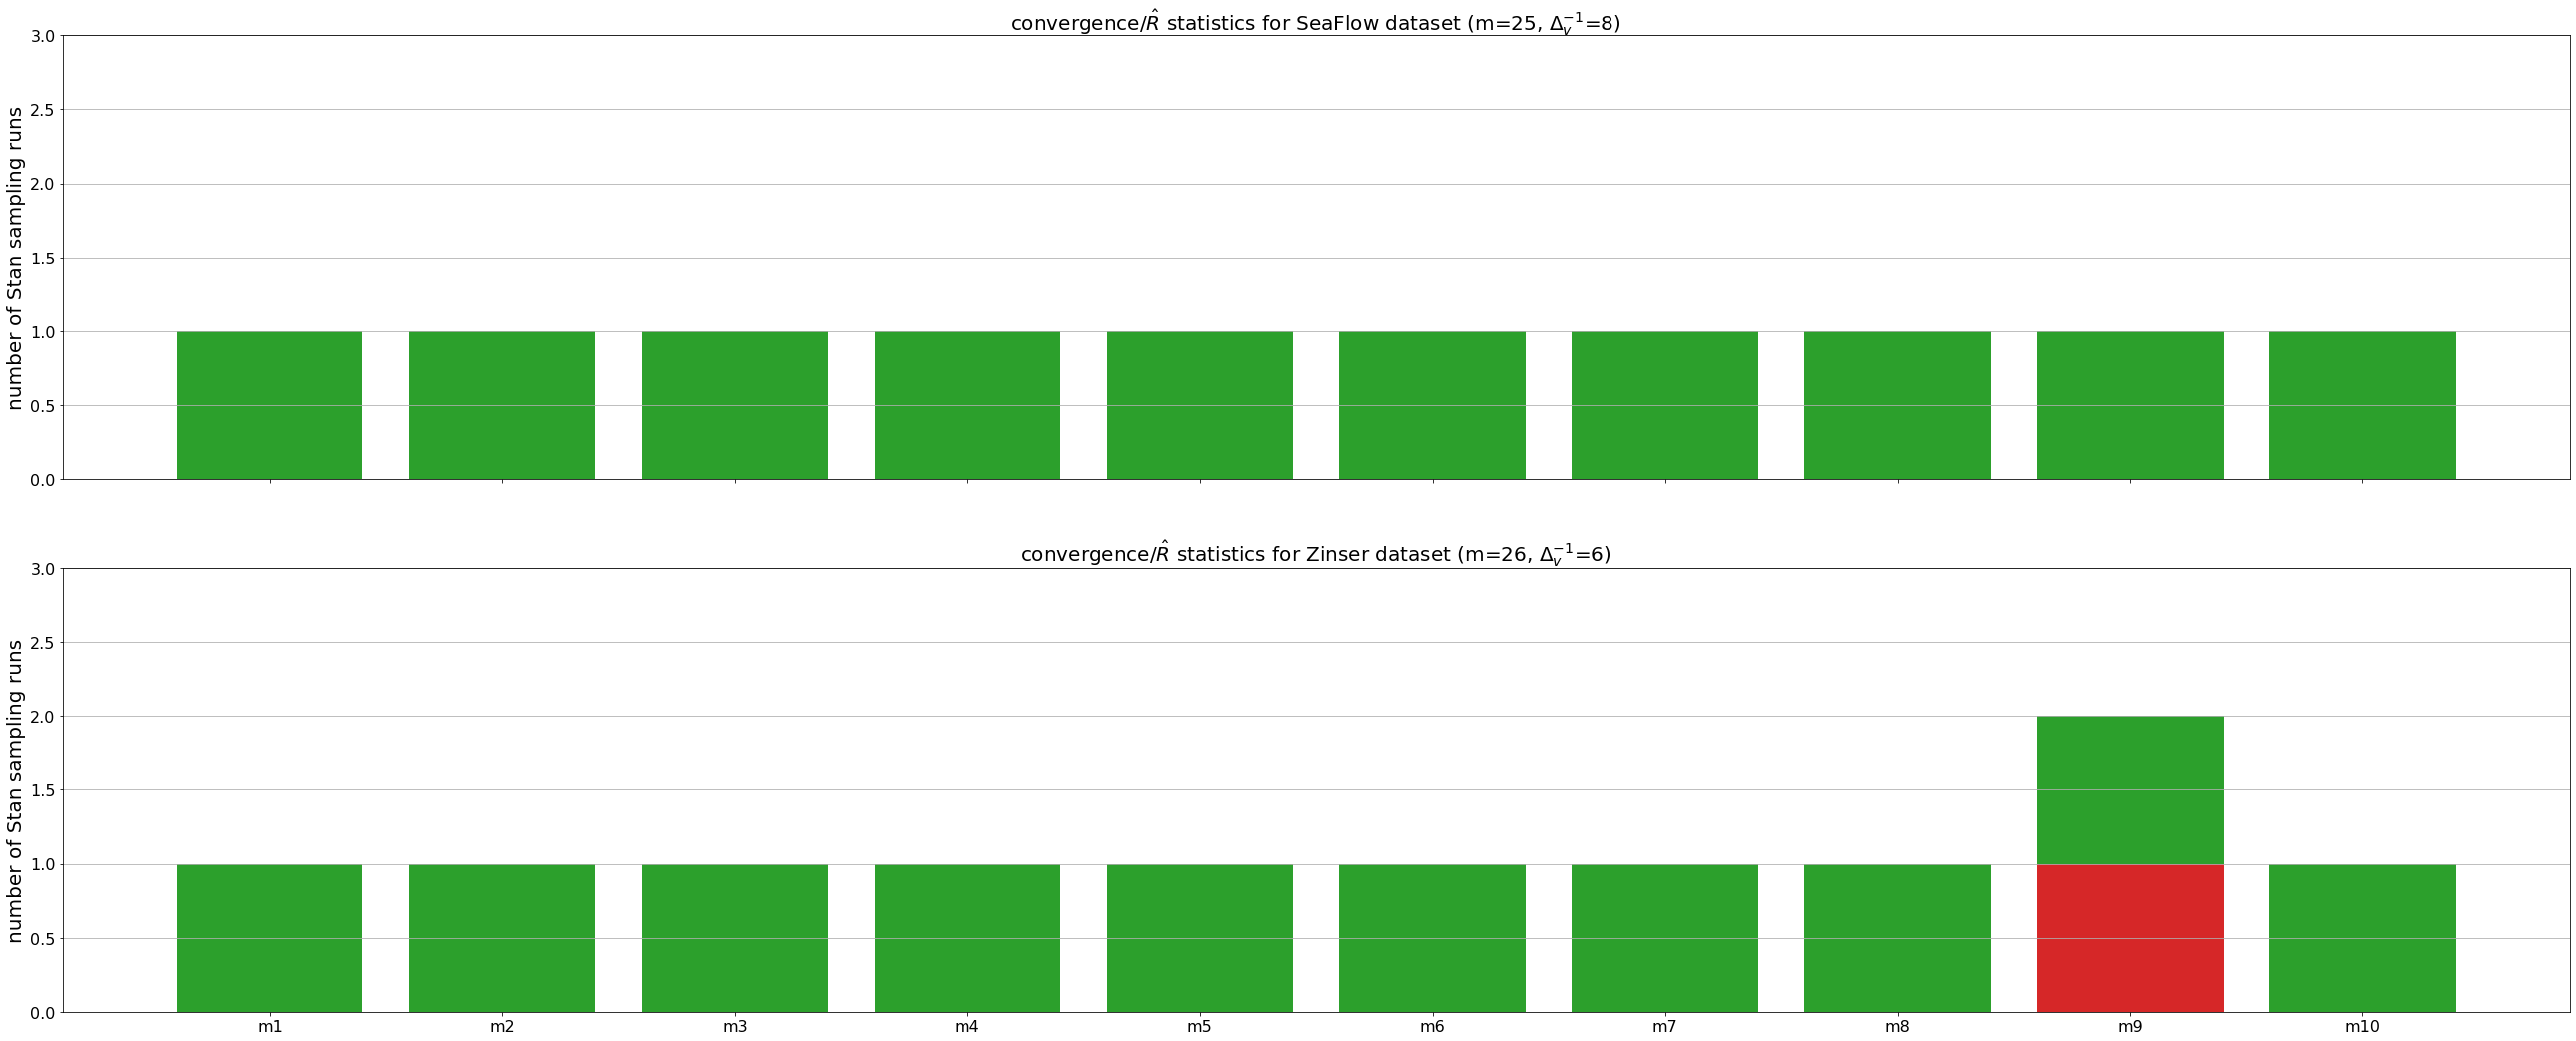

In [9]:
ylim_top = 0
for dataname in data:
    for model in mcmcs:
        ylim_top = max(ylim_top, len(maxrhats[model][dataname]))
ylim_top += 1

fig, axs = plt.subplots(nrows=len(data), figsize=(max(24,len(mcmcs)*4.5),len(data)*9), sharex=True, sharey=True)
for ax,dataname in zip(axs.flat,data):
    xticks = []
    xticklabels = []
    for i,model in enumerate(mcmcs):
        
        height_bad = sum(rh > 1.1 for rh in maxrhats[model][dataname])
        height_good = len(maxrhats[model][dataname]) - height_bad
        
        x = i
        ax.bar(x=x, height=height_bad, color='tab:red', label='max $\\\\hat{R}$ > 1.1')
        ax.bar(x=x, height=height_good, bottom=height_bad, color='tab:green', label='max $\\hat{R} \le$ 1.1')
        xticks.append(x)
        xticklabels.append(desc_model[model].replace(',',',\n'))
    
    ax.set(ylabel='number of Stan sampling runs', xticks=xticks, ylim=(0, ylim_top))
    ax.set_title('convergence/$\hat{R}$ statistics for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

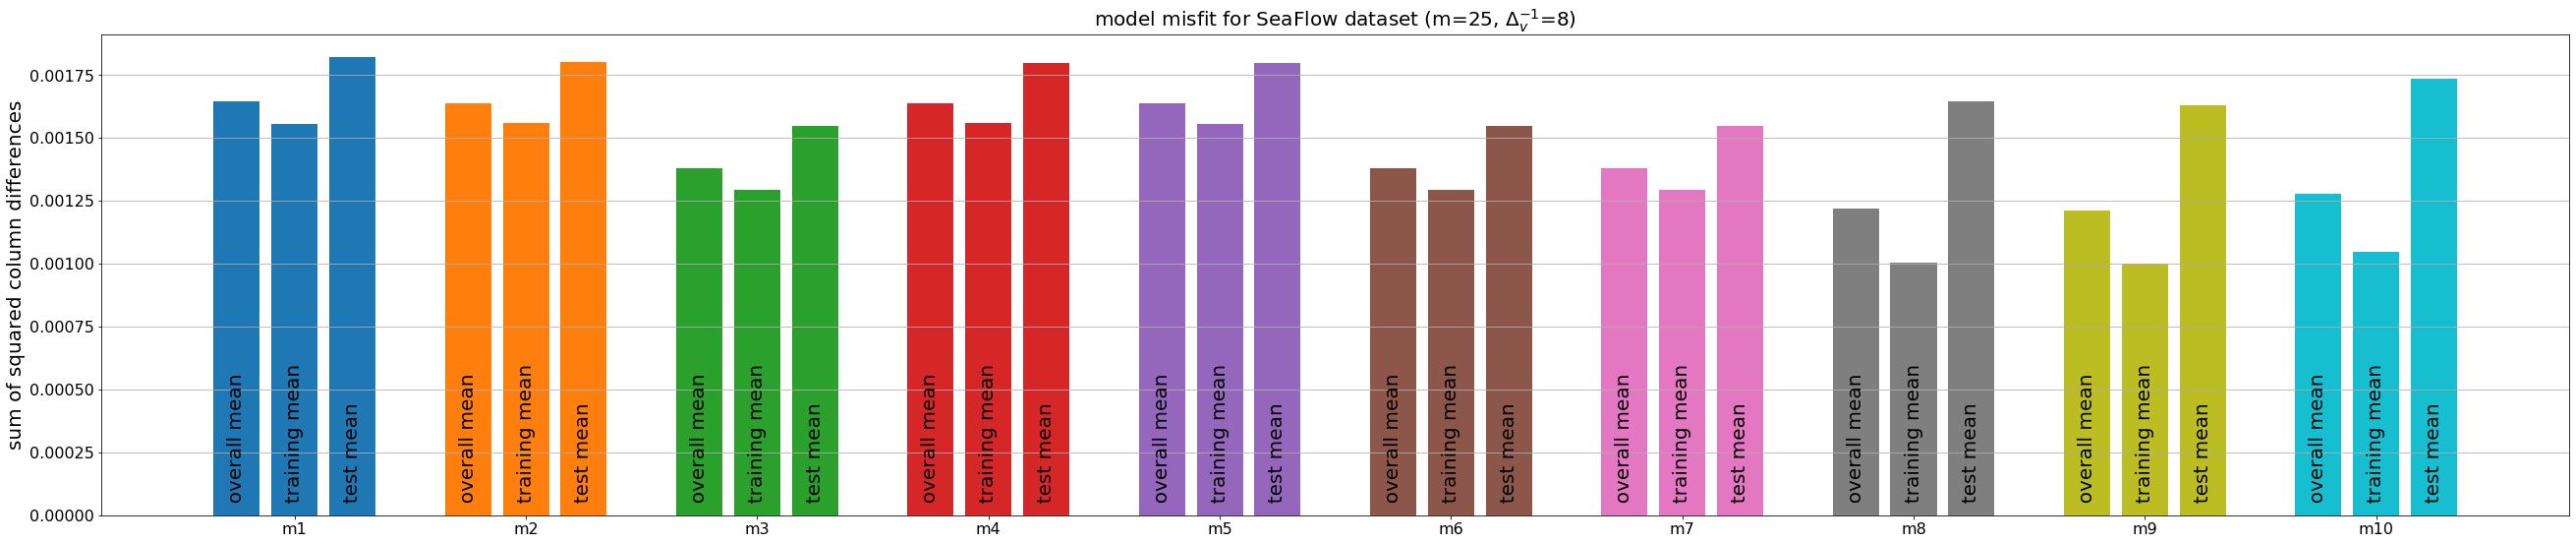

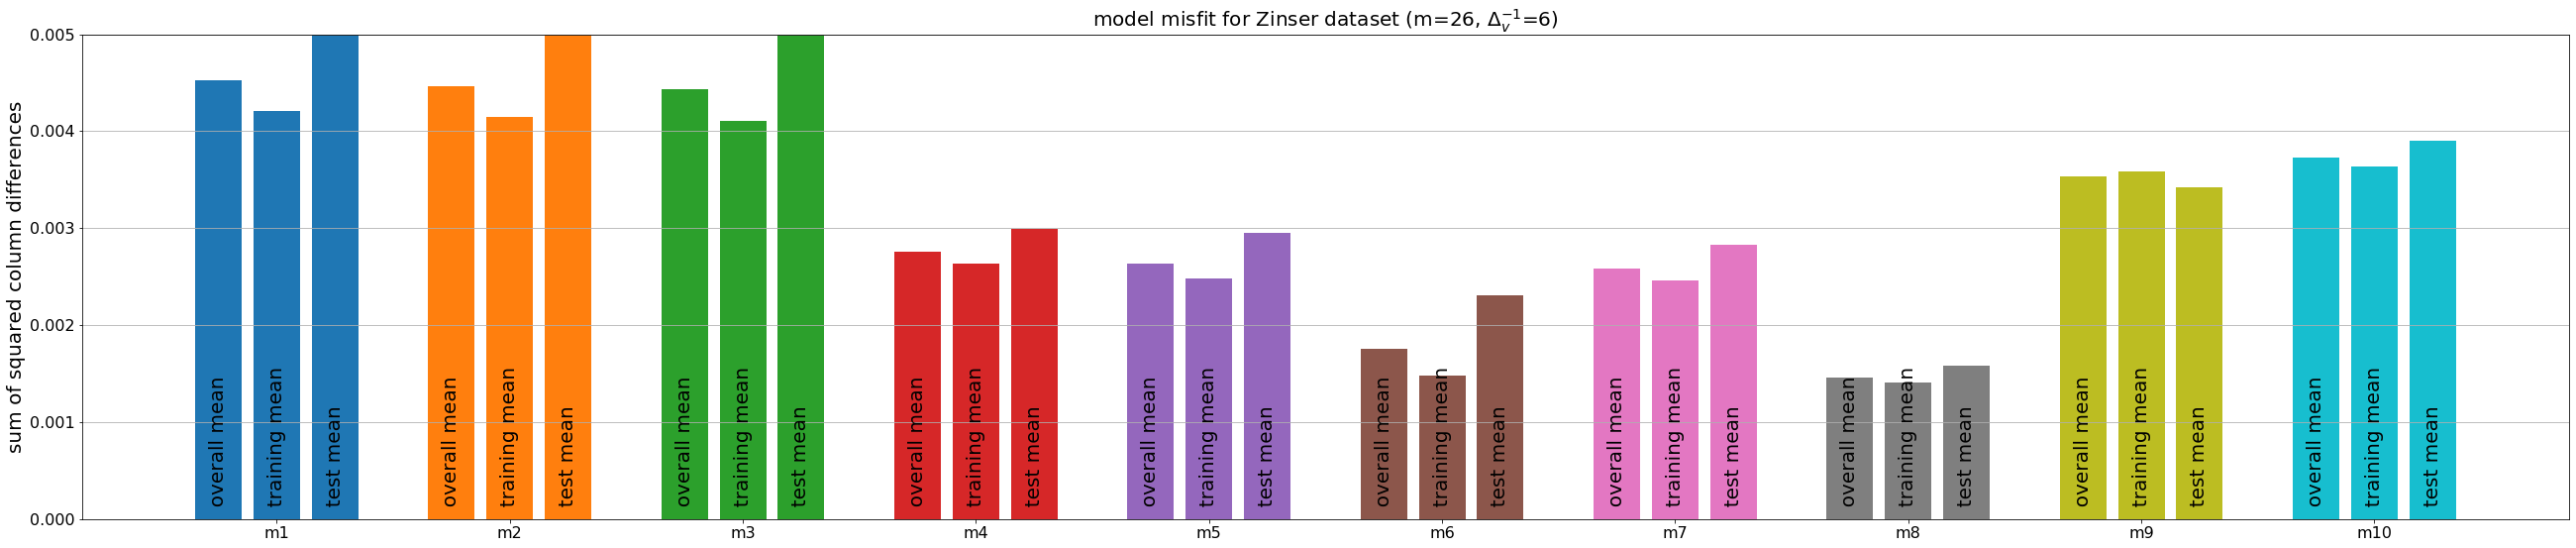

In [10]:
# updated code can handle all data[dataname]['i_test'] == 0 and draw only a single bar
if np.all(data[dataname]['i_test'] == 0):
    num_bars = 1
else:
    num_bars = 3

height = np.zeros(num_bars)
for dataname in data:
    obs = data[dataname]['obs']
    
    fig, ax = plt.subplots(figsize=(max(24,len(mcmcs)*4.5),9))
    xticks = []
    xticklabels = []
    for i,model in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[model][dataname]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[model],e)
        
        height[0] = np.mean(e)
        if num_bars > 1:
            height[1] = np.mean(e[data[dataname]['i_test'] == 0])
            height[2] = np.mean(e[data[dataname]['i_test'] == 1])
        
        x = (num_bars+1)*i+np.arange(num_bars)
        ax.bar(x=x, height=height, color=colors_model[model])
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=20)
        if maxrhats_final[model][dataname] > 1.1:
            ax.text(x[num_bars//3], 0, '  no convergence ($\\hat{R}>1.1$)', rotation=45, ha='center', va='bottom', size=30, color='darkred')
        xticks.append(x[num_bars//3])
        xticklabels.append(desc_model[model].replace(',',',\n').replace('(','\n('))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title('model misfit for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

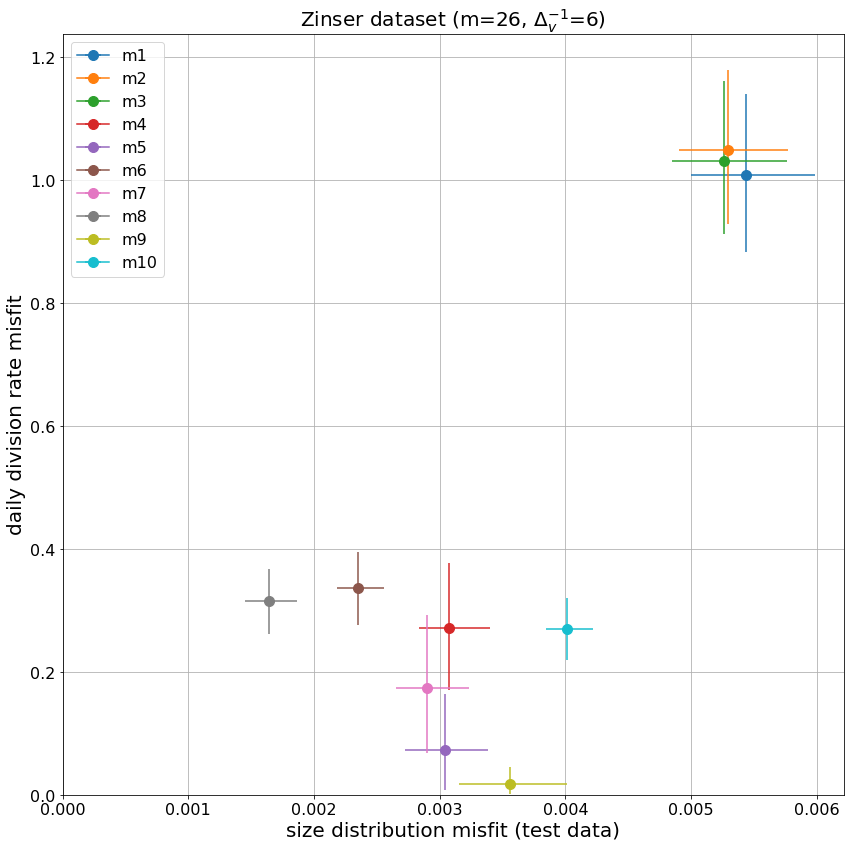

In [11]:
for dataname in data:
    if 'zinser' in dataname:
        fig, ax = plt.subplots(figsize=(14,14))
        ax.set_title(desc[dataname], size=20)
        
        for model in mcmcs:
            # misfit to data

            obs = data[dataname]['obs']

            tmp = mcmcs[model][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2
            
            if np.all(data[dataname]['i_test'] == 0):
                e0 = np.mean(np.sum(tmp, axis=1), axis=1)
                xlabel_suffix = ''
            else:
                e0 = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
                xlabel_suffix = ' (test data)'
            
            # misfit to division rate

            e1 = np.abs(mcmcs[model][dataname]['divrate'] - reference_values[dataname]['divrate'])
        
            q0 = np.percentile(e0, q=(5,25,50,75,95))
            q1 = np.percentile(e1, q=(5,25,50,75,95))
            
            eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label=desc_model[model], color=colors_model[model])
            ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())
            if maxrhats_final[model][dataname] > 1.1:
                ax.plot(q0[2], q1[2], marker='x', color='darkred', zorder=10, markersize=30, markeredgewidth=3)
        ax.grid(True)
        ax.legend()
        ax.set(xlabel='size distribution misfit'+xlabel_suffix, ylabel='daily division rate misfit')
        ax.set_xlim(left=0.0)
        ax.set_ylim(bottom=0.0)

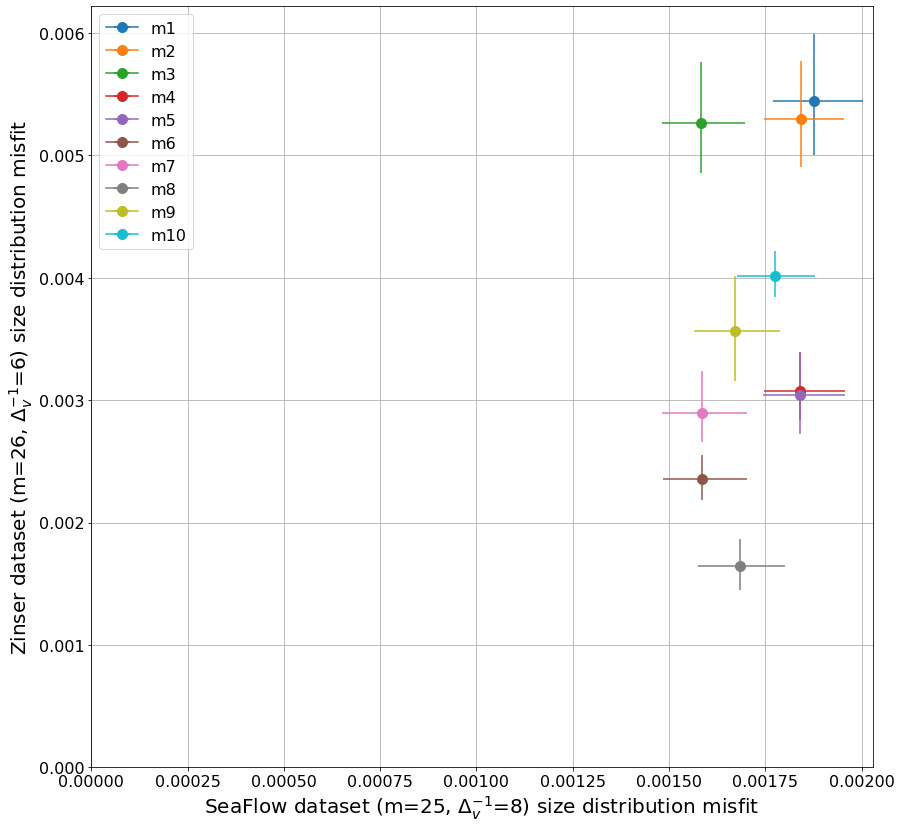

In [12]:
fig, ax = plt.subplots(figsize=(14,14))

datanames = tuple(data.keys())
for model in mcmcs:
    qq = {}
    # misfit to data
    for dataname in datanames:
        obs = data[dataname]['obs']

        tmp = mcmcs[model][dataname]['mod_obspos']
        tmp/= np.sum(tmp, axis=1)[:,None,:]
        tmp -= obs[None,:,:]
        tmp **= 2

        if np.all(data[dataname]['i_test'] == 0):
            e0 = np.mean(np.sum(tmp, axis=1), axis=1)
        else:
            e0 = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)

        qq[dataname] = np.percentile(e0, q=(5,25,50,75,95))
    
    q0 = qq[datanames[0]]
    q1 = qq[datanames[1]]
    
    eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label=desc_model[model], color=colors_model[model])
    ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())
    if maxrhats_final[model][dataname] > 1.1:
        ax.plot(q0[2], q1[2], marker='x', color='darkred', zorder=10, markersize=30, markeredgewidth=3)
    
ax.grid(True)
ax.legend()
ax.set(xlabel='{} size distribution misfit'.format(desc[datanames[0]]), 
       ylabel='{} size distribution misfit'.format(desc[datanames[1]]))
ax.set_xlim(left=0.0)
ax.set_ylim(bottom=0.0)
None

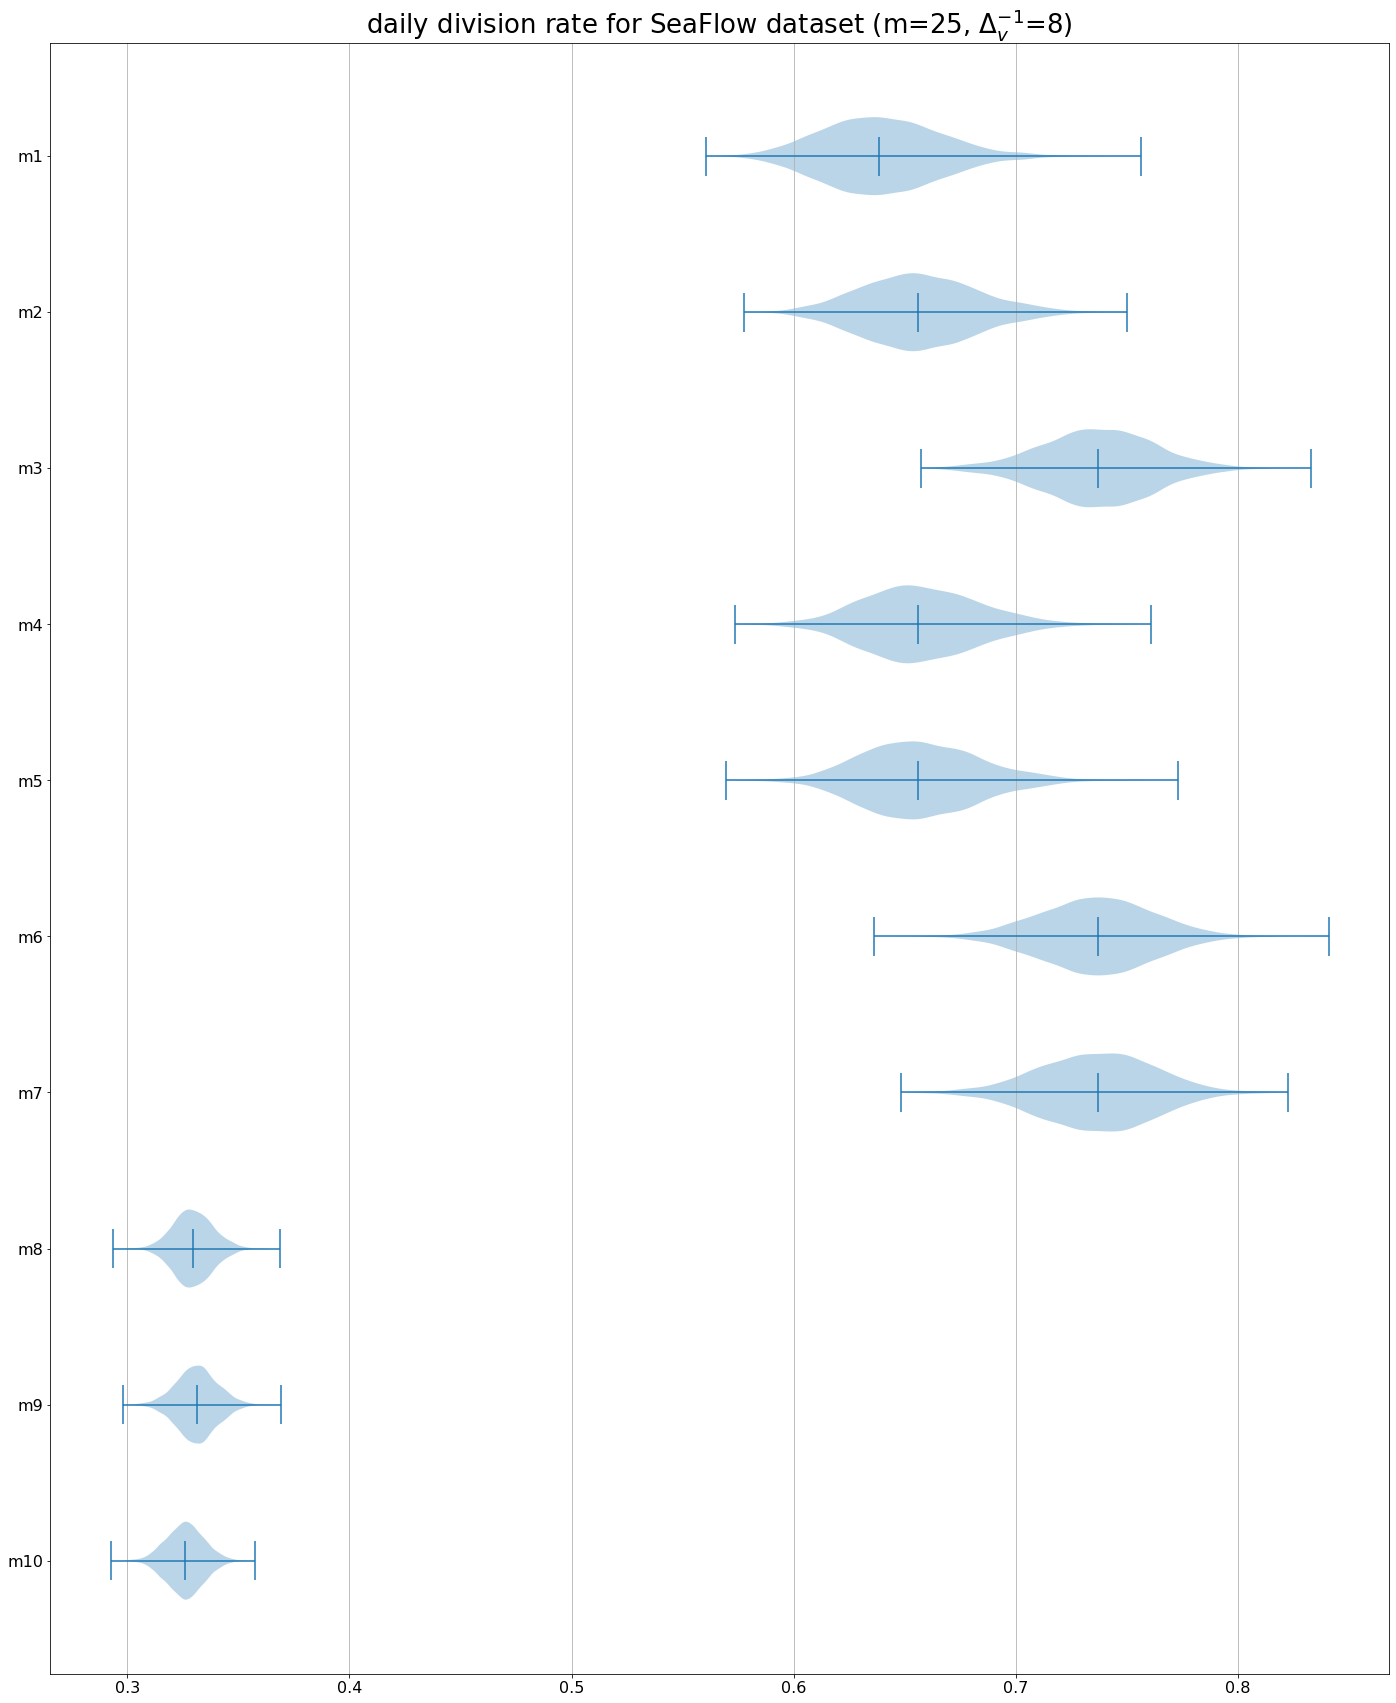

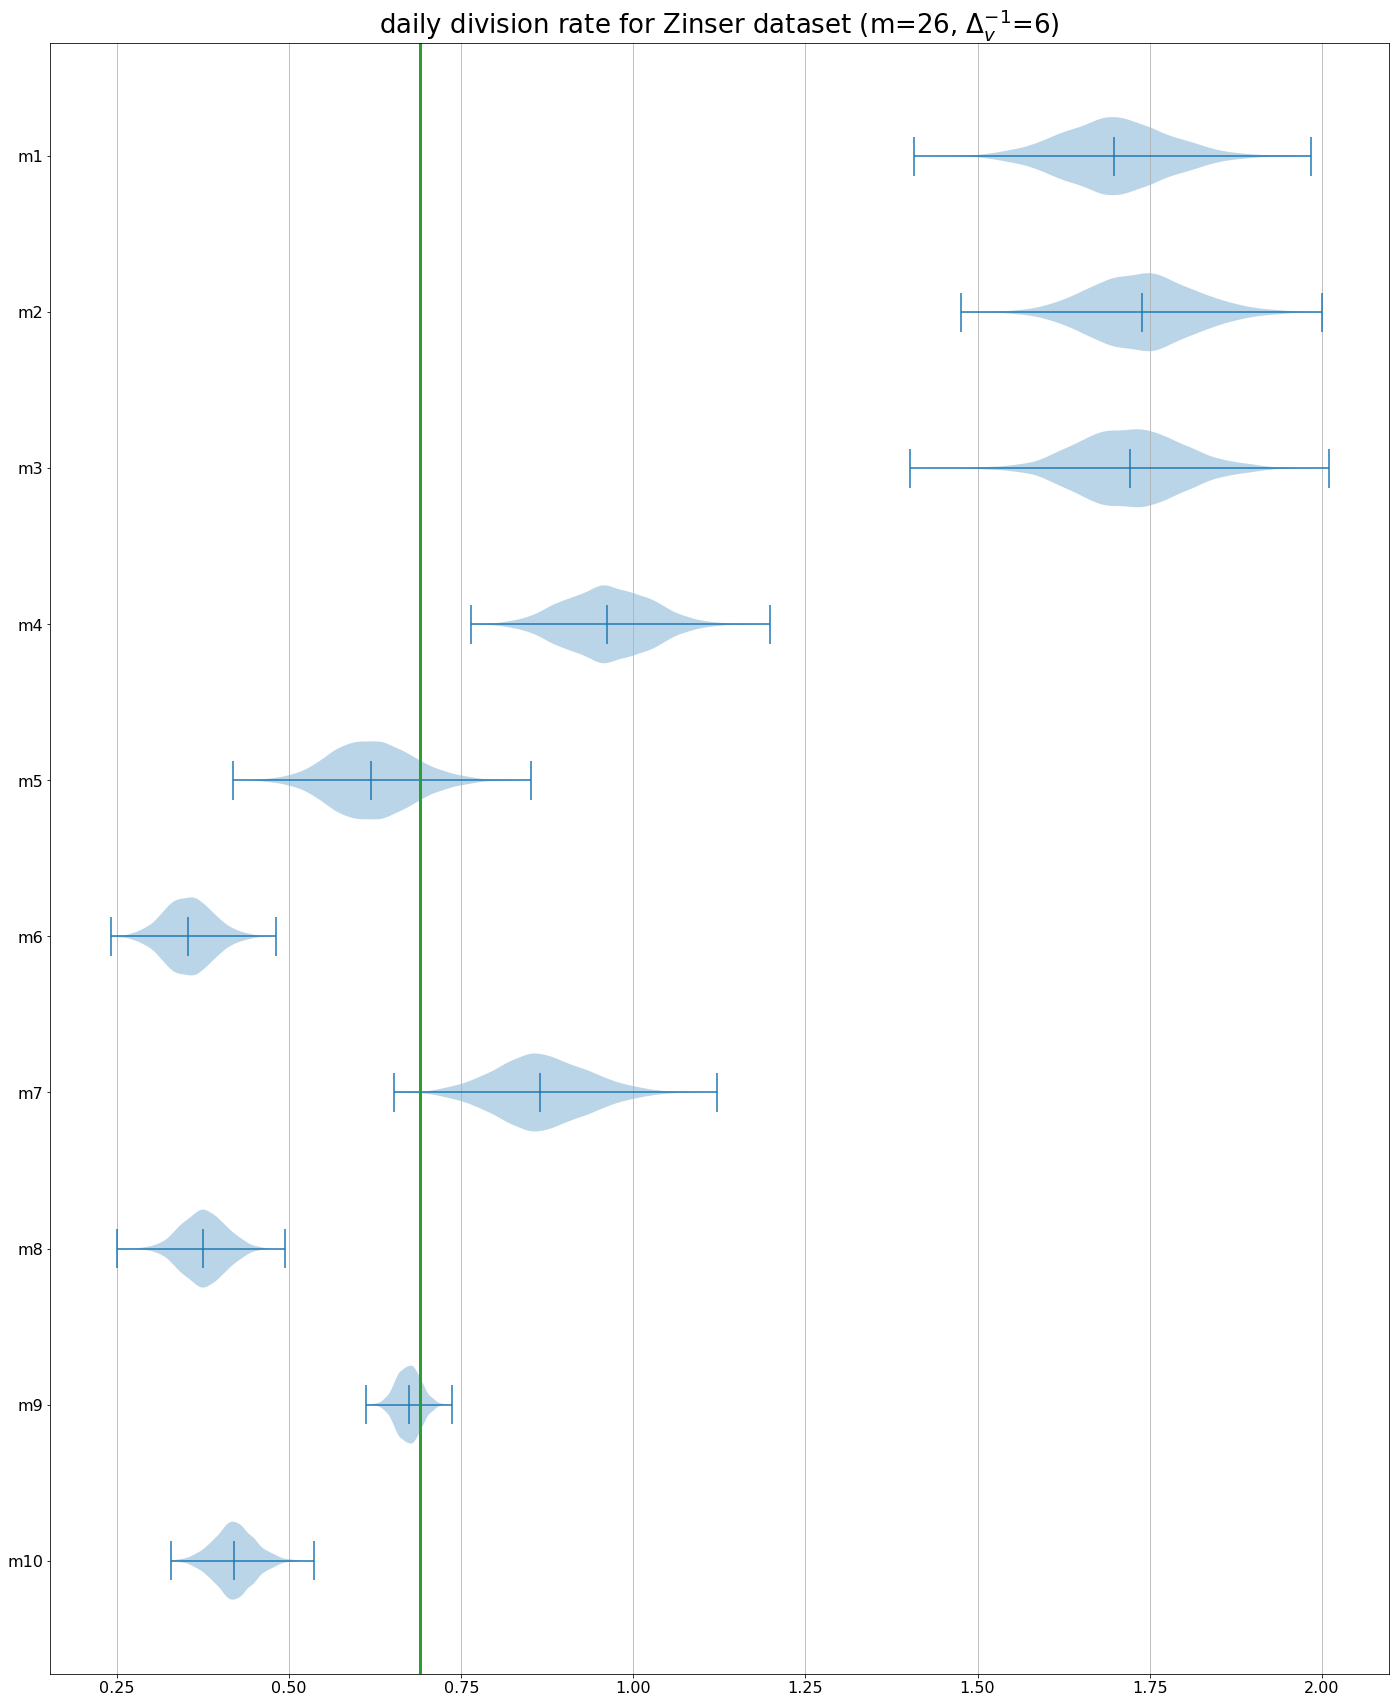

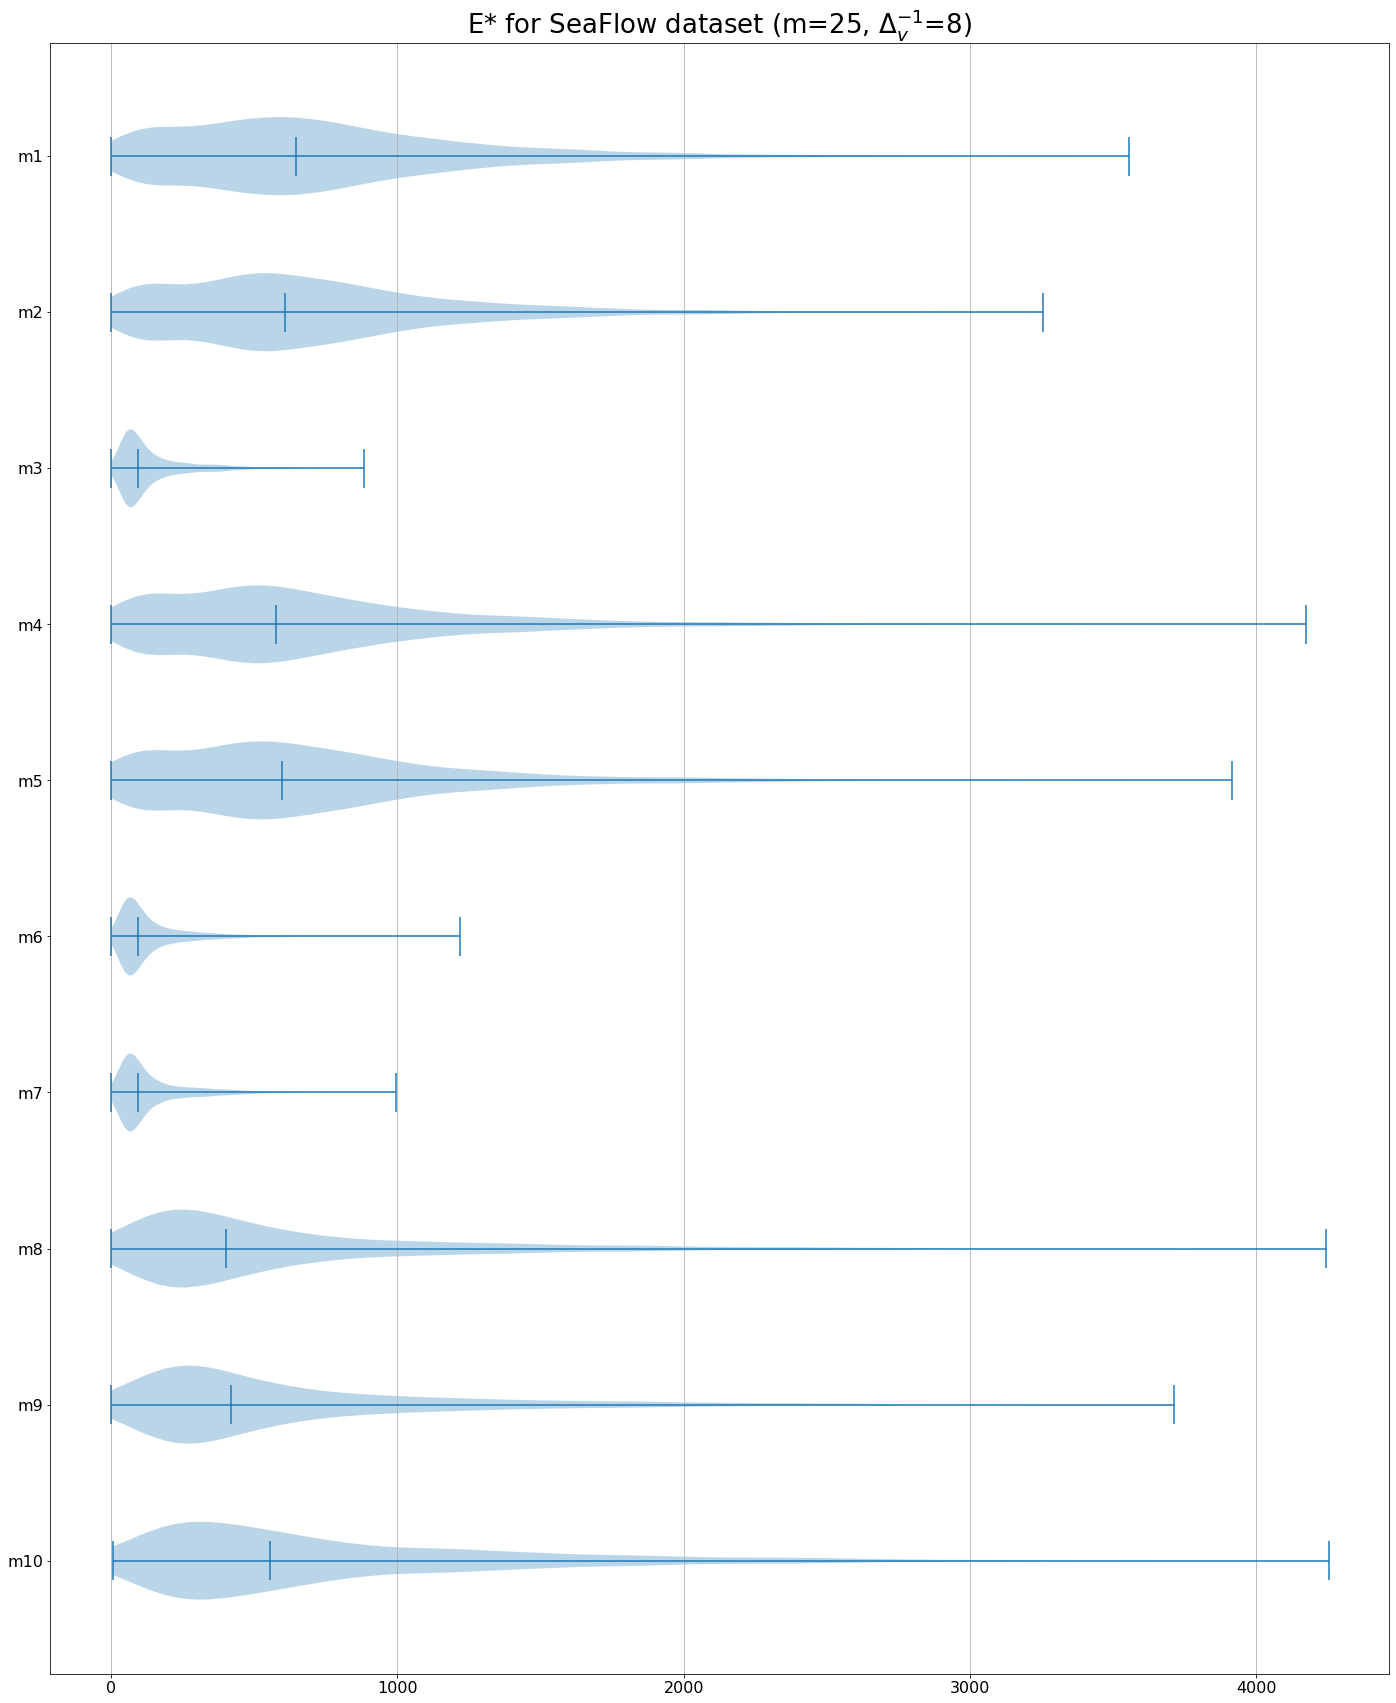

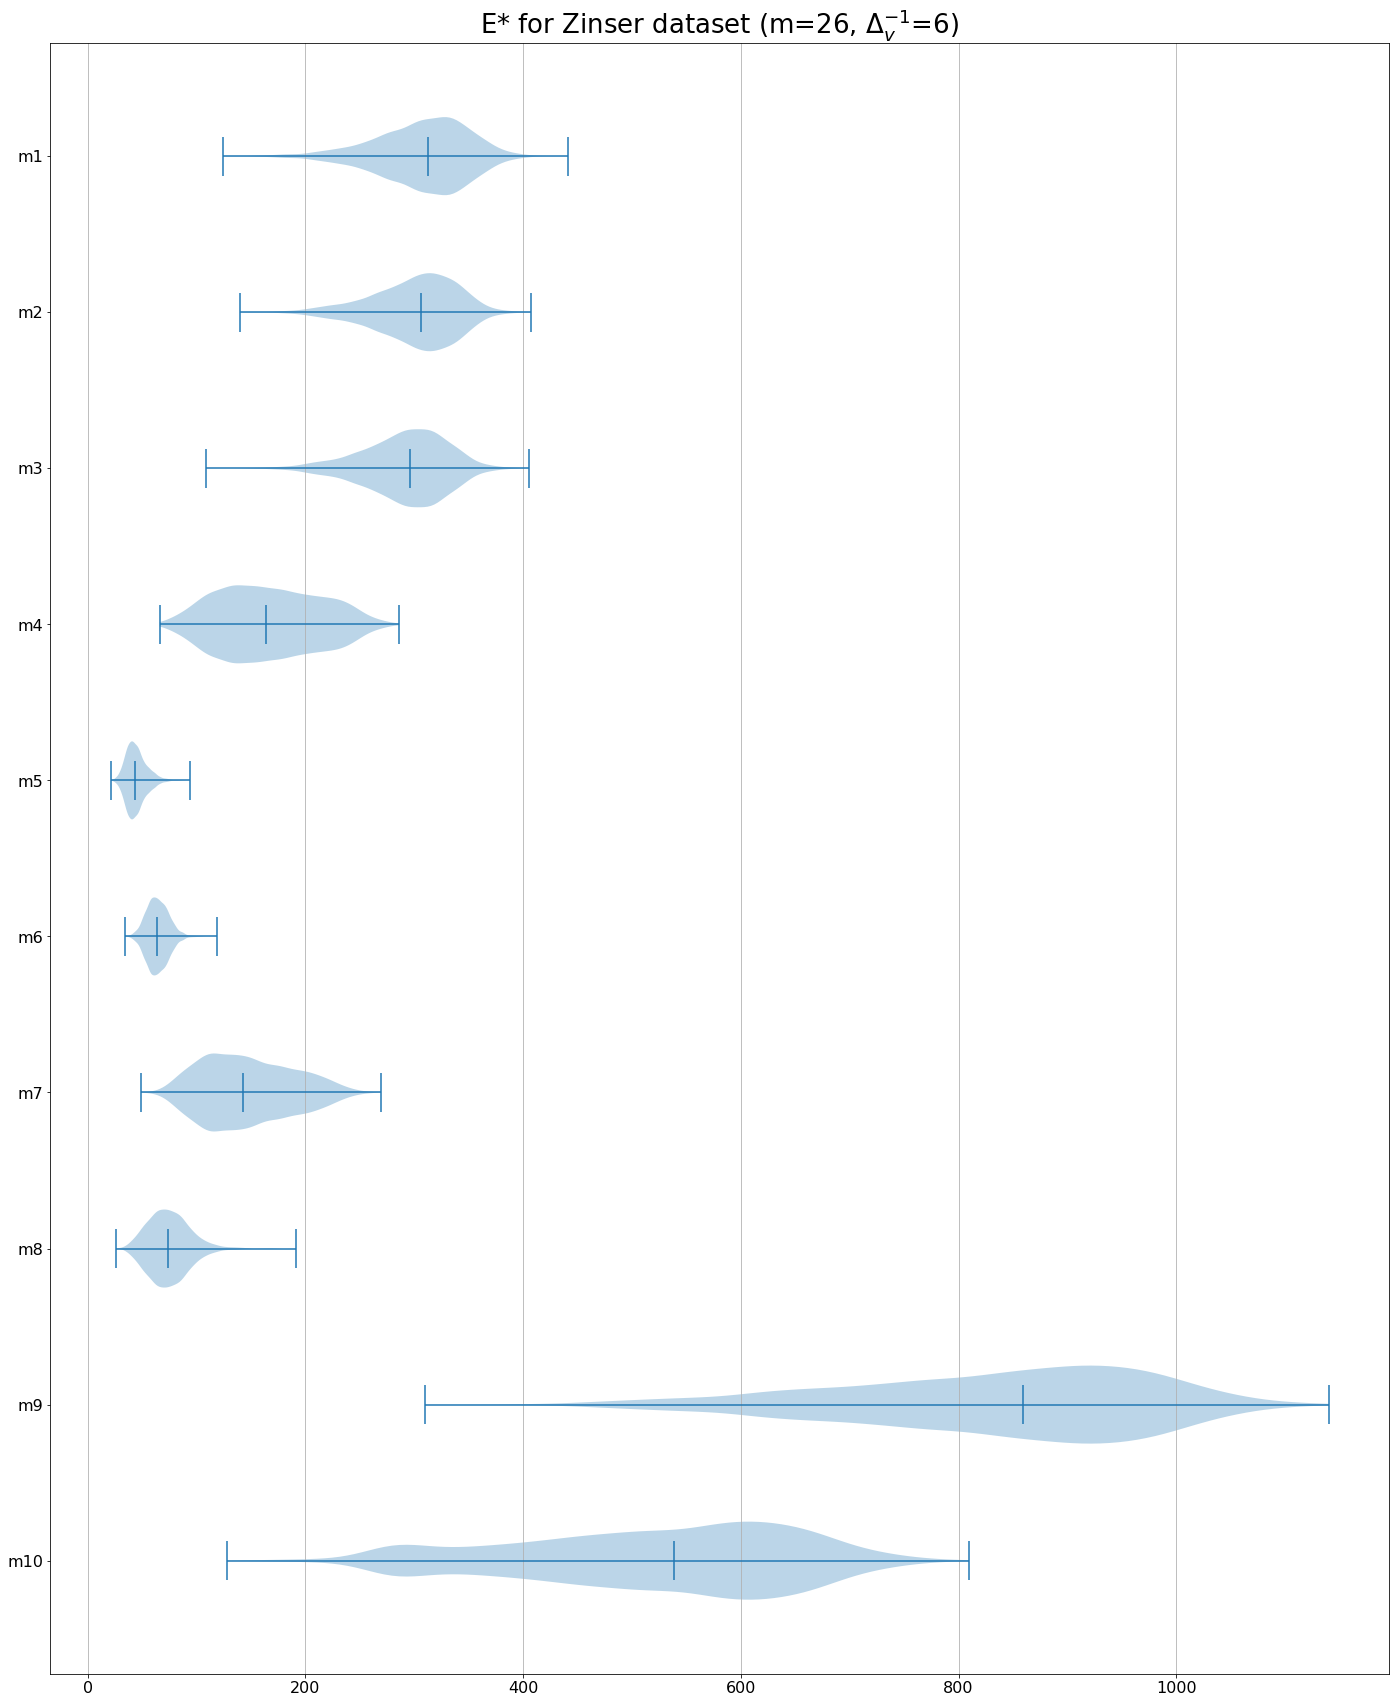

In [13]:
for param in ('divrate','E_star'):
    for dataname in data:
        num_mcmcs = len(mcmcs)
        fig, ax = plt.subplots(figsize=(24,3*num_mcmcs))
        ax.set_title('{} for {}'.format(param_desc[param], desc[dataname]))
        ax.violinplot([mcmcs[model][dataname][param] for model in mcmcs], showmedians=True, vert=False)
        ax.invert_yaxis()
        ax.grid(axis='x')
        ax.set(yticks=np.arange(1,num_mcmcs+1), yticklabels=[desc_model[model].replace(',',',\n') for model in mcmcs])
        if dataname in reference_values and param in reference_values[dataname]:
            ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
        for i,model in enumerate(mcmcs):
            if maxrhats_final[model][dataname] > 1.1:
                ax.text(0.5, i+1, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.get_yaxis_transform(), ha='center', va='center')

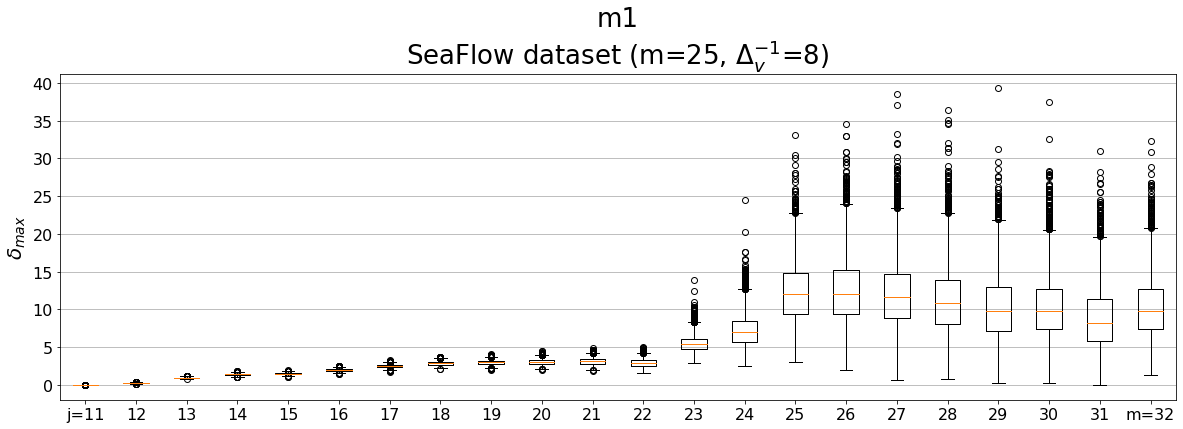

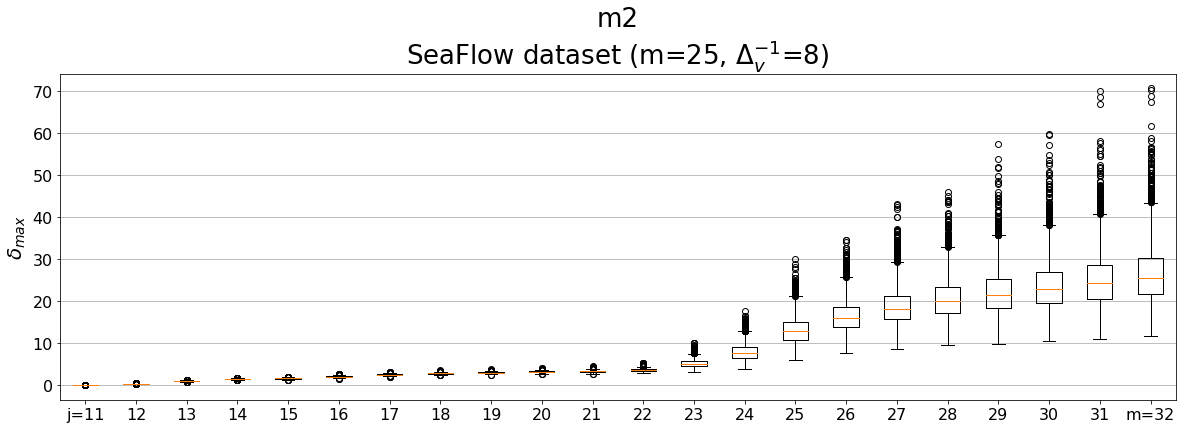

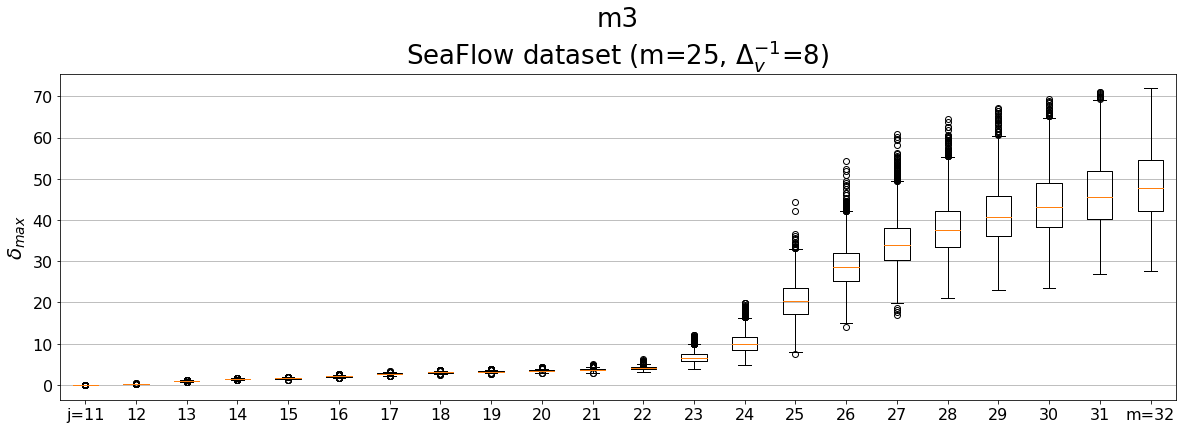

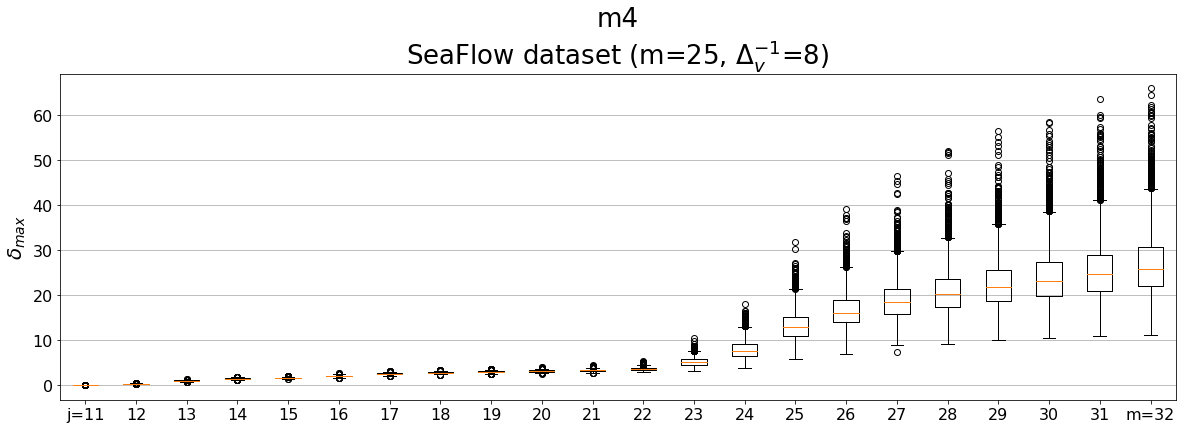

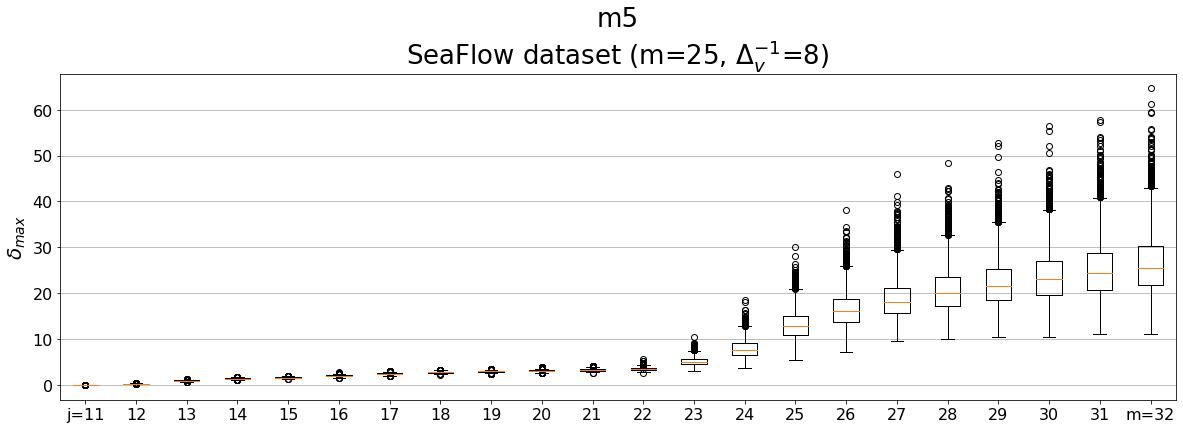

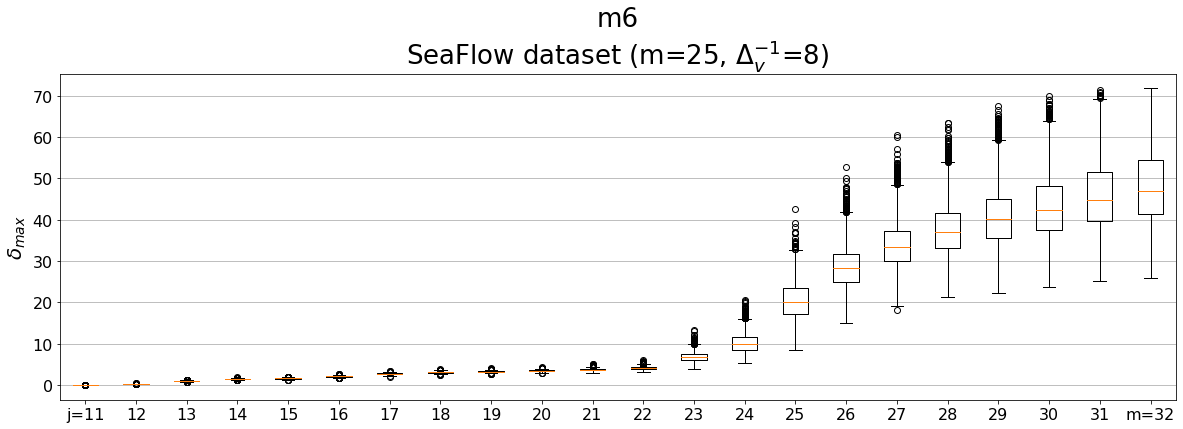

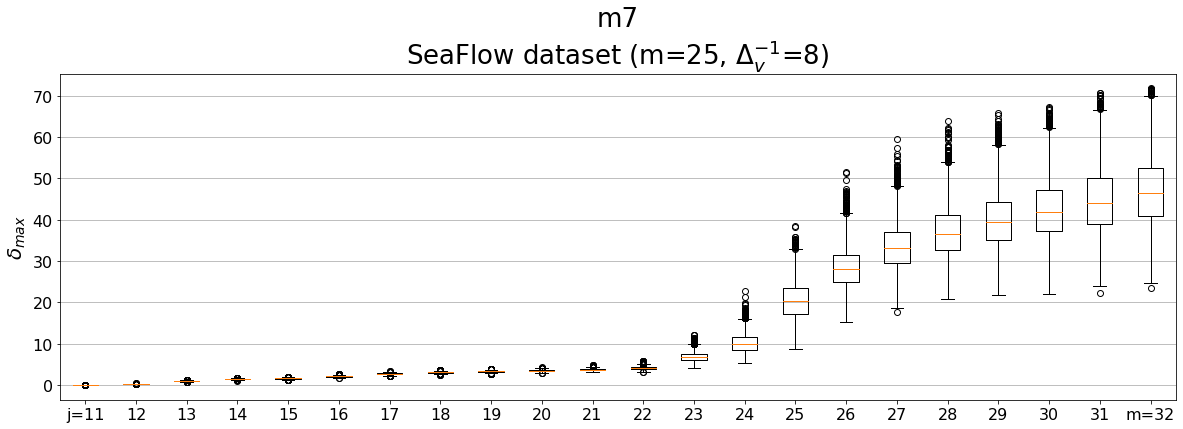

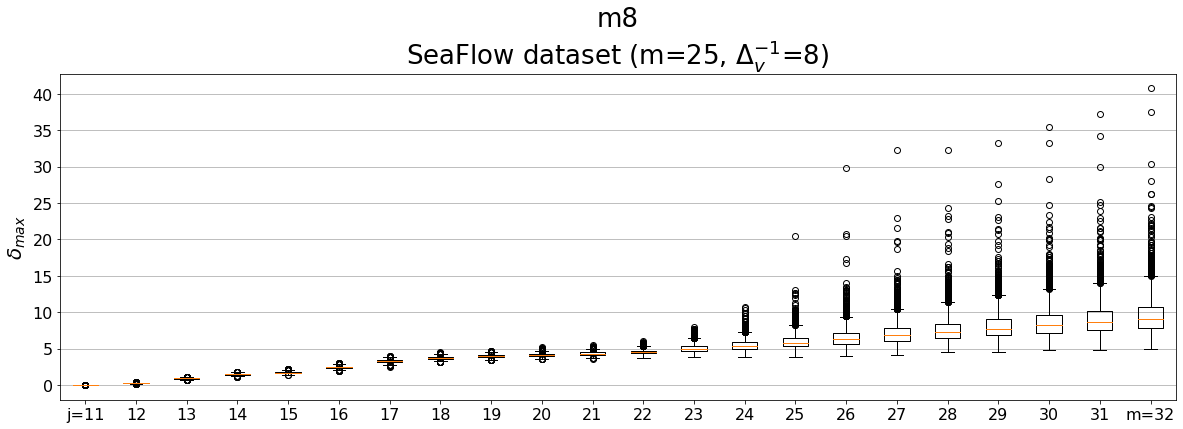

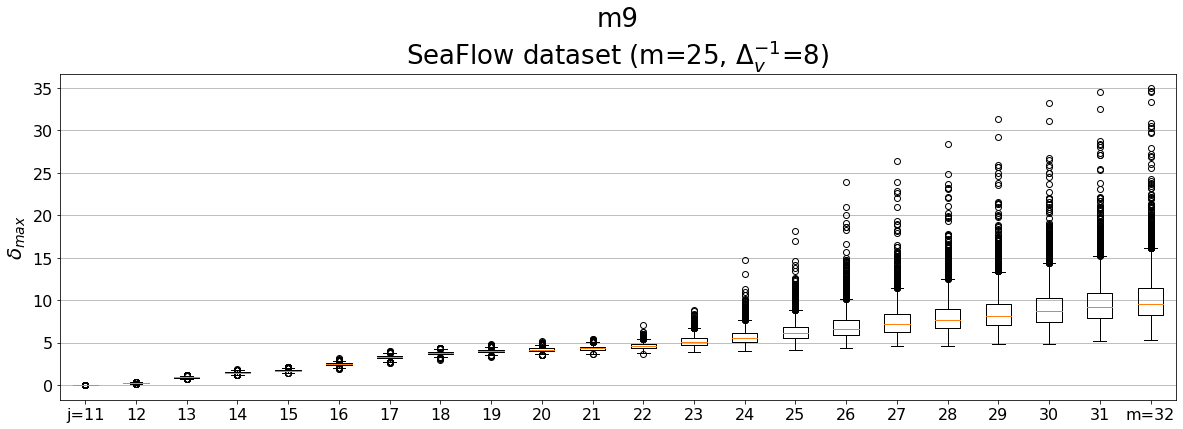

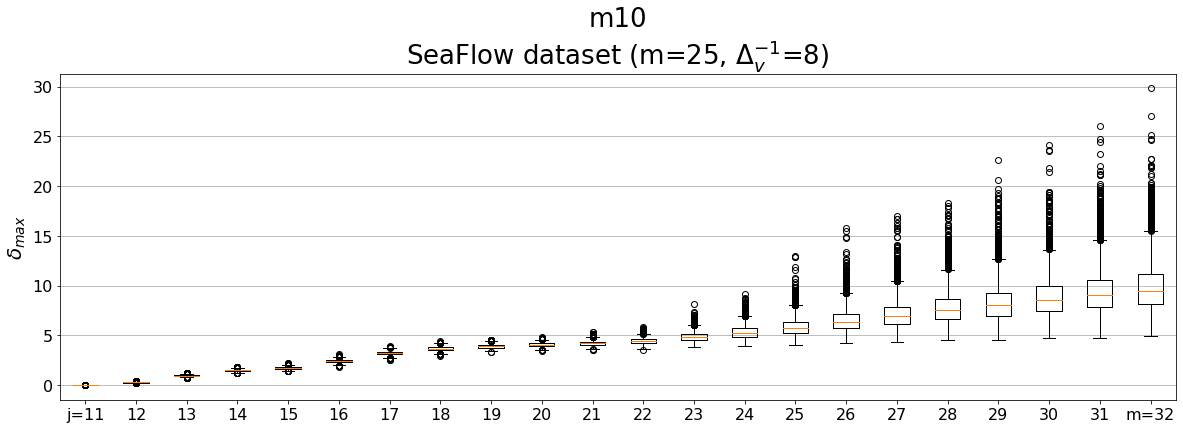

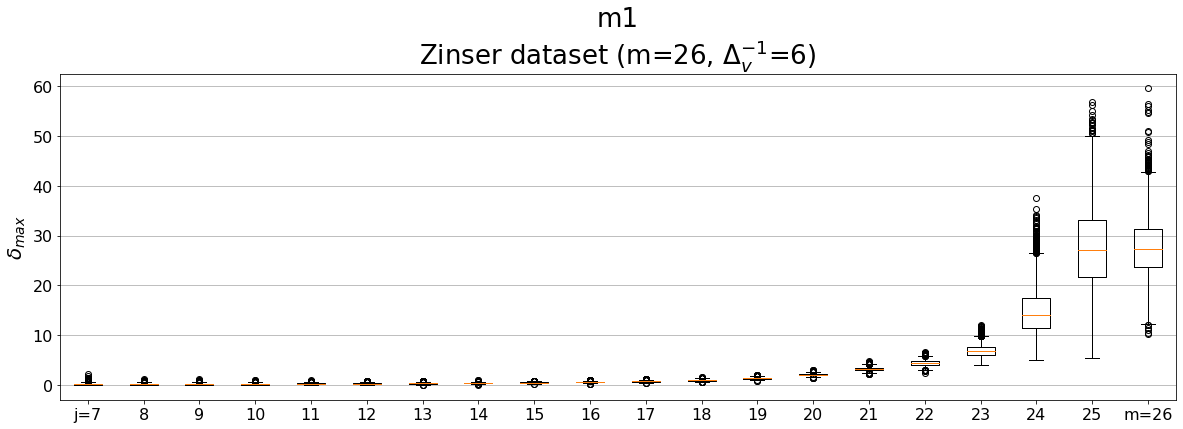

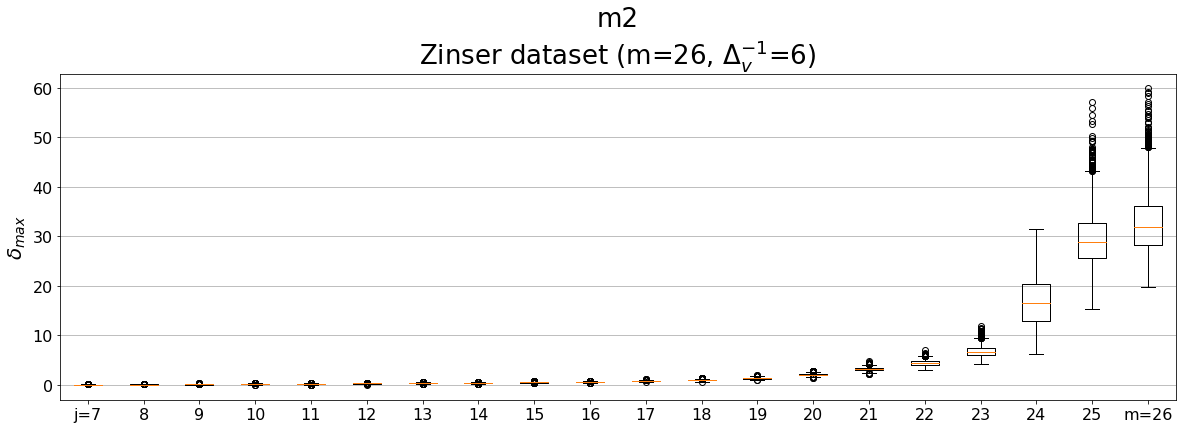

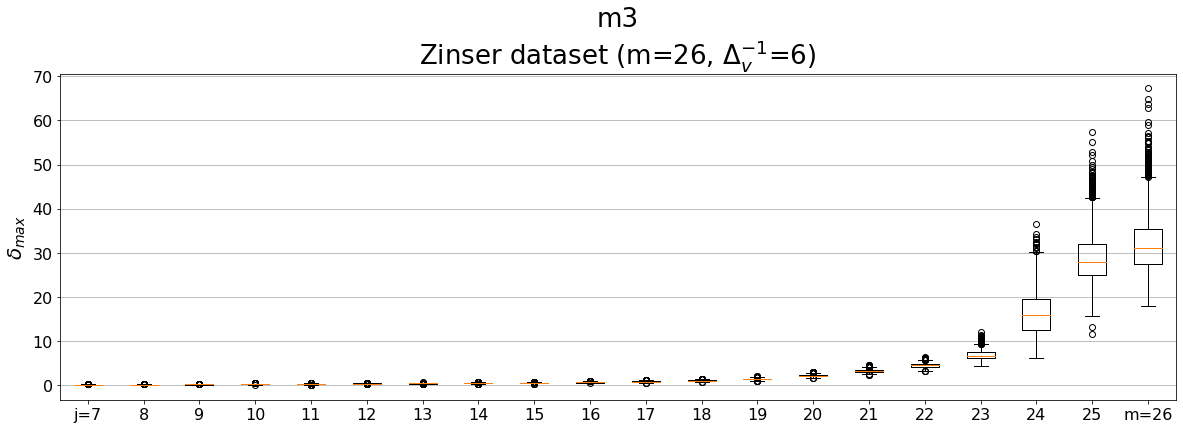

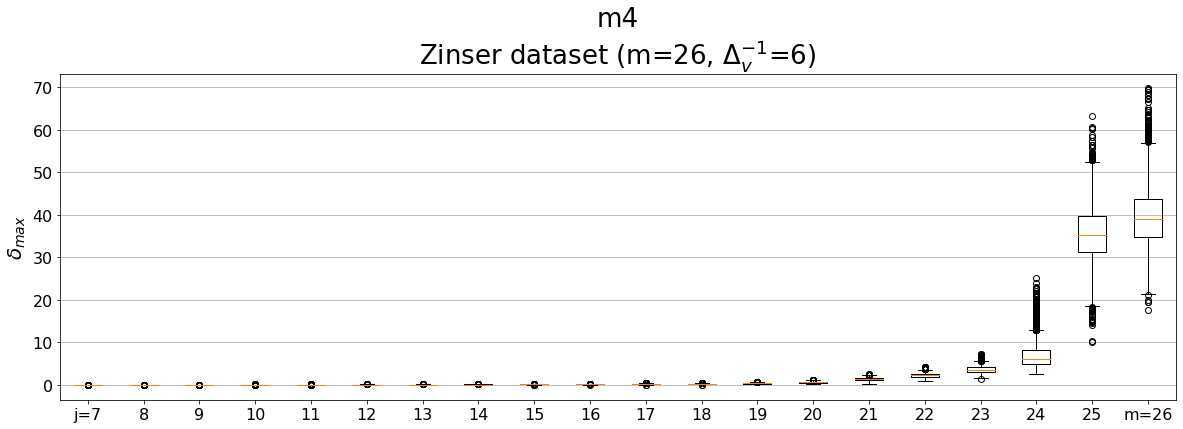

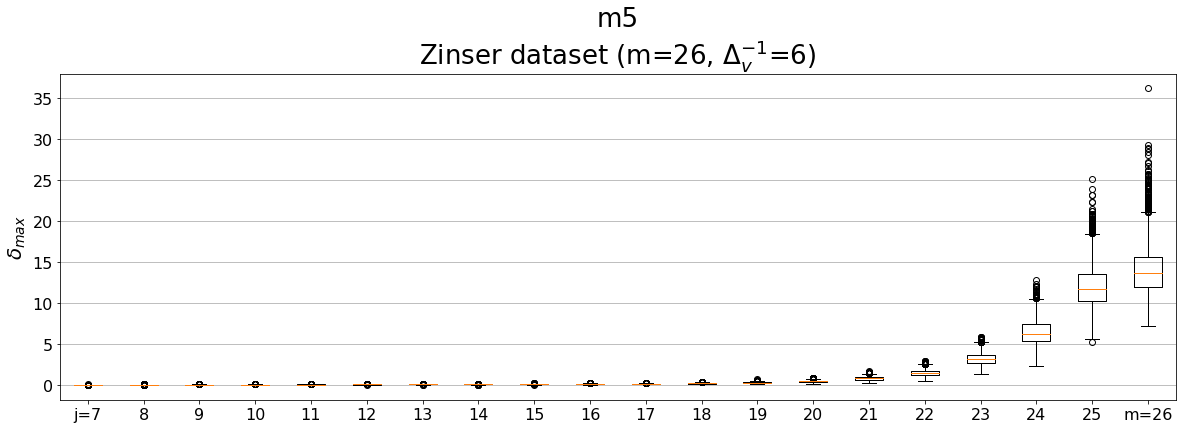

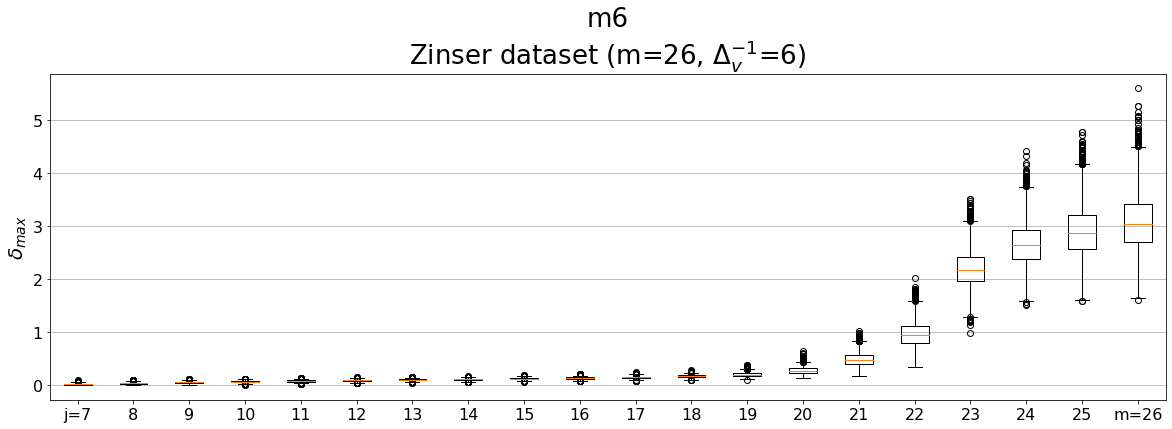

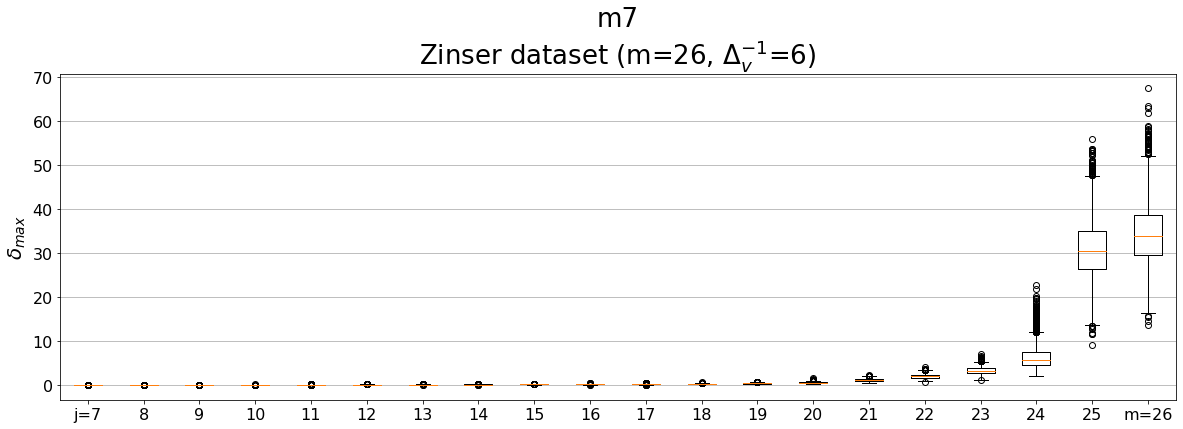

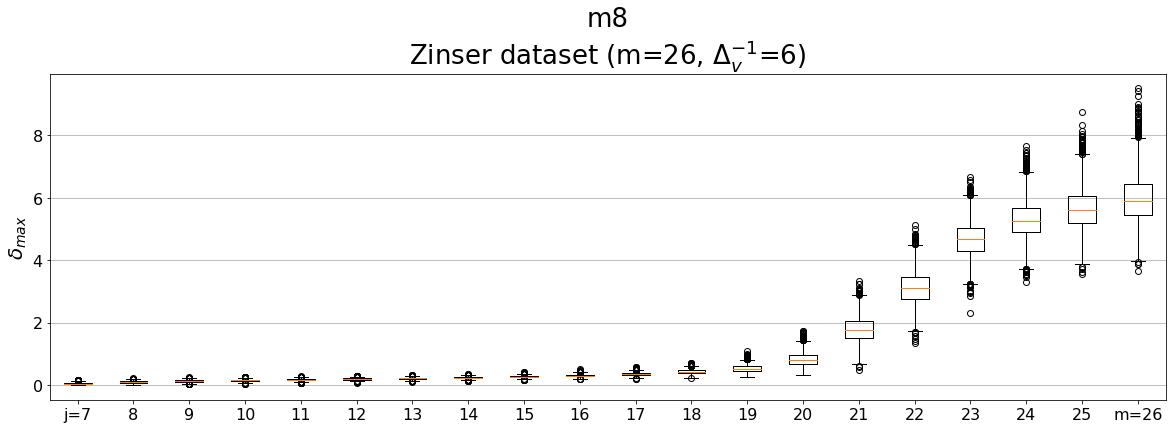

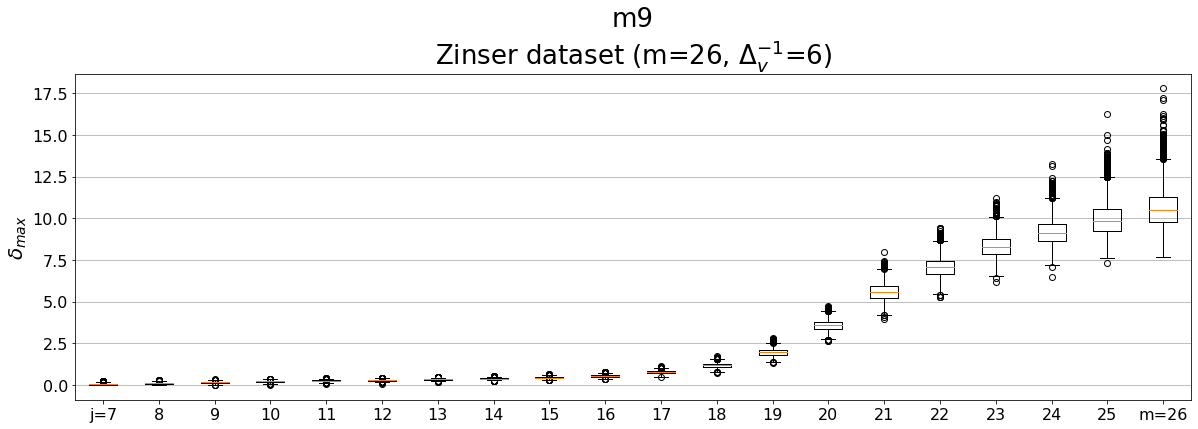

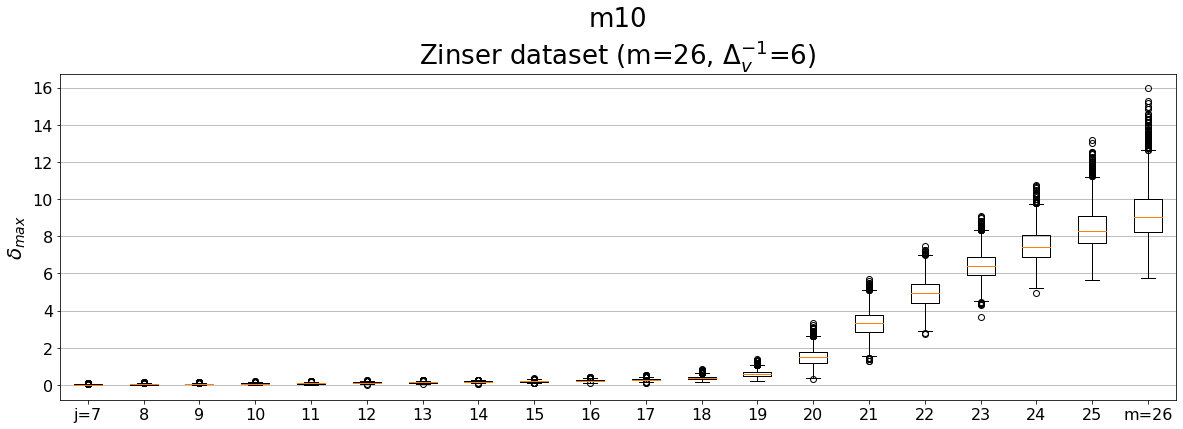

In [14]:
for dataname in data:
    for model,mcmc in mcmcs.items():
        j = data_gridded[dataname]['delta_v_inv'] + 1
        m = data_gridded[dataname]['m']

        fig, ax = plt.subplots(figsize=(20,6))
        ax.set_title(desc_model[model] + '\n' + desc[dataname])
        ax.boxplot(mcmc[dataname]['delta'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        ax.set_ylabel('$\\delta_{max}$')
        
        if maxrhats_final[model][dataname] > 1.1:
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
        None

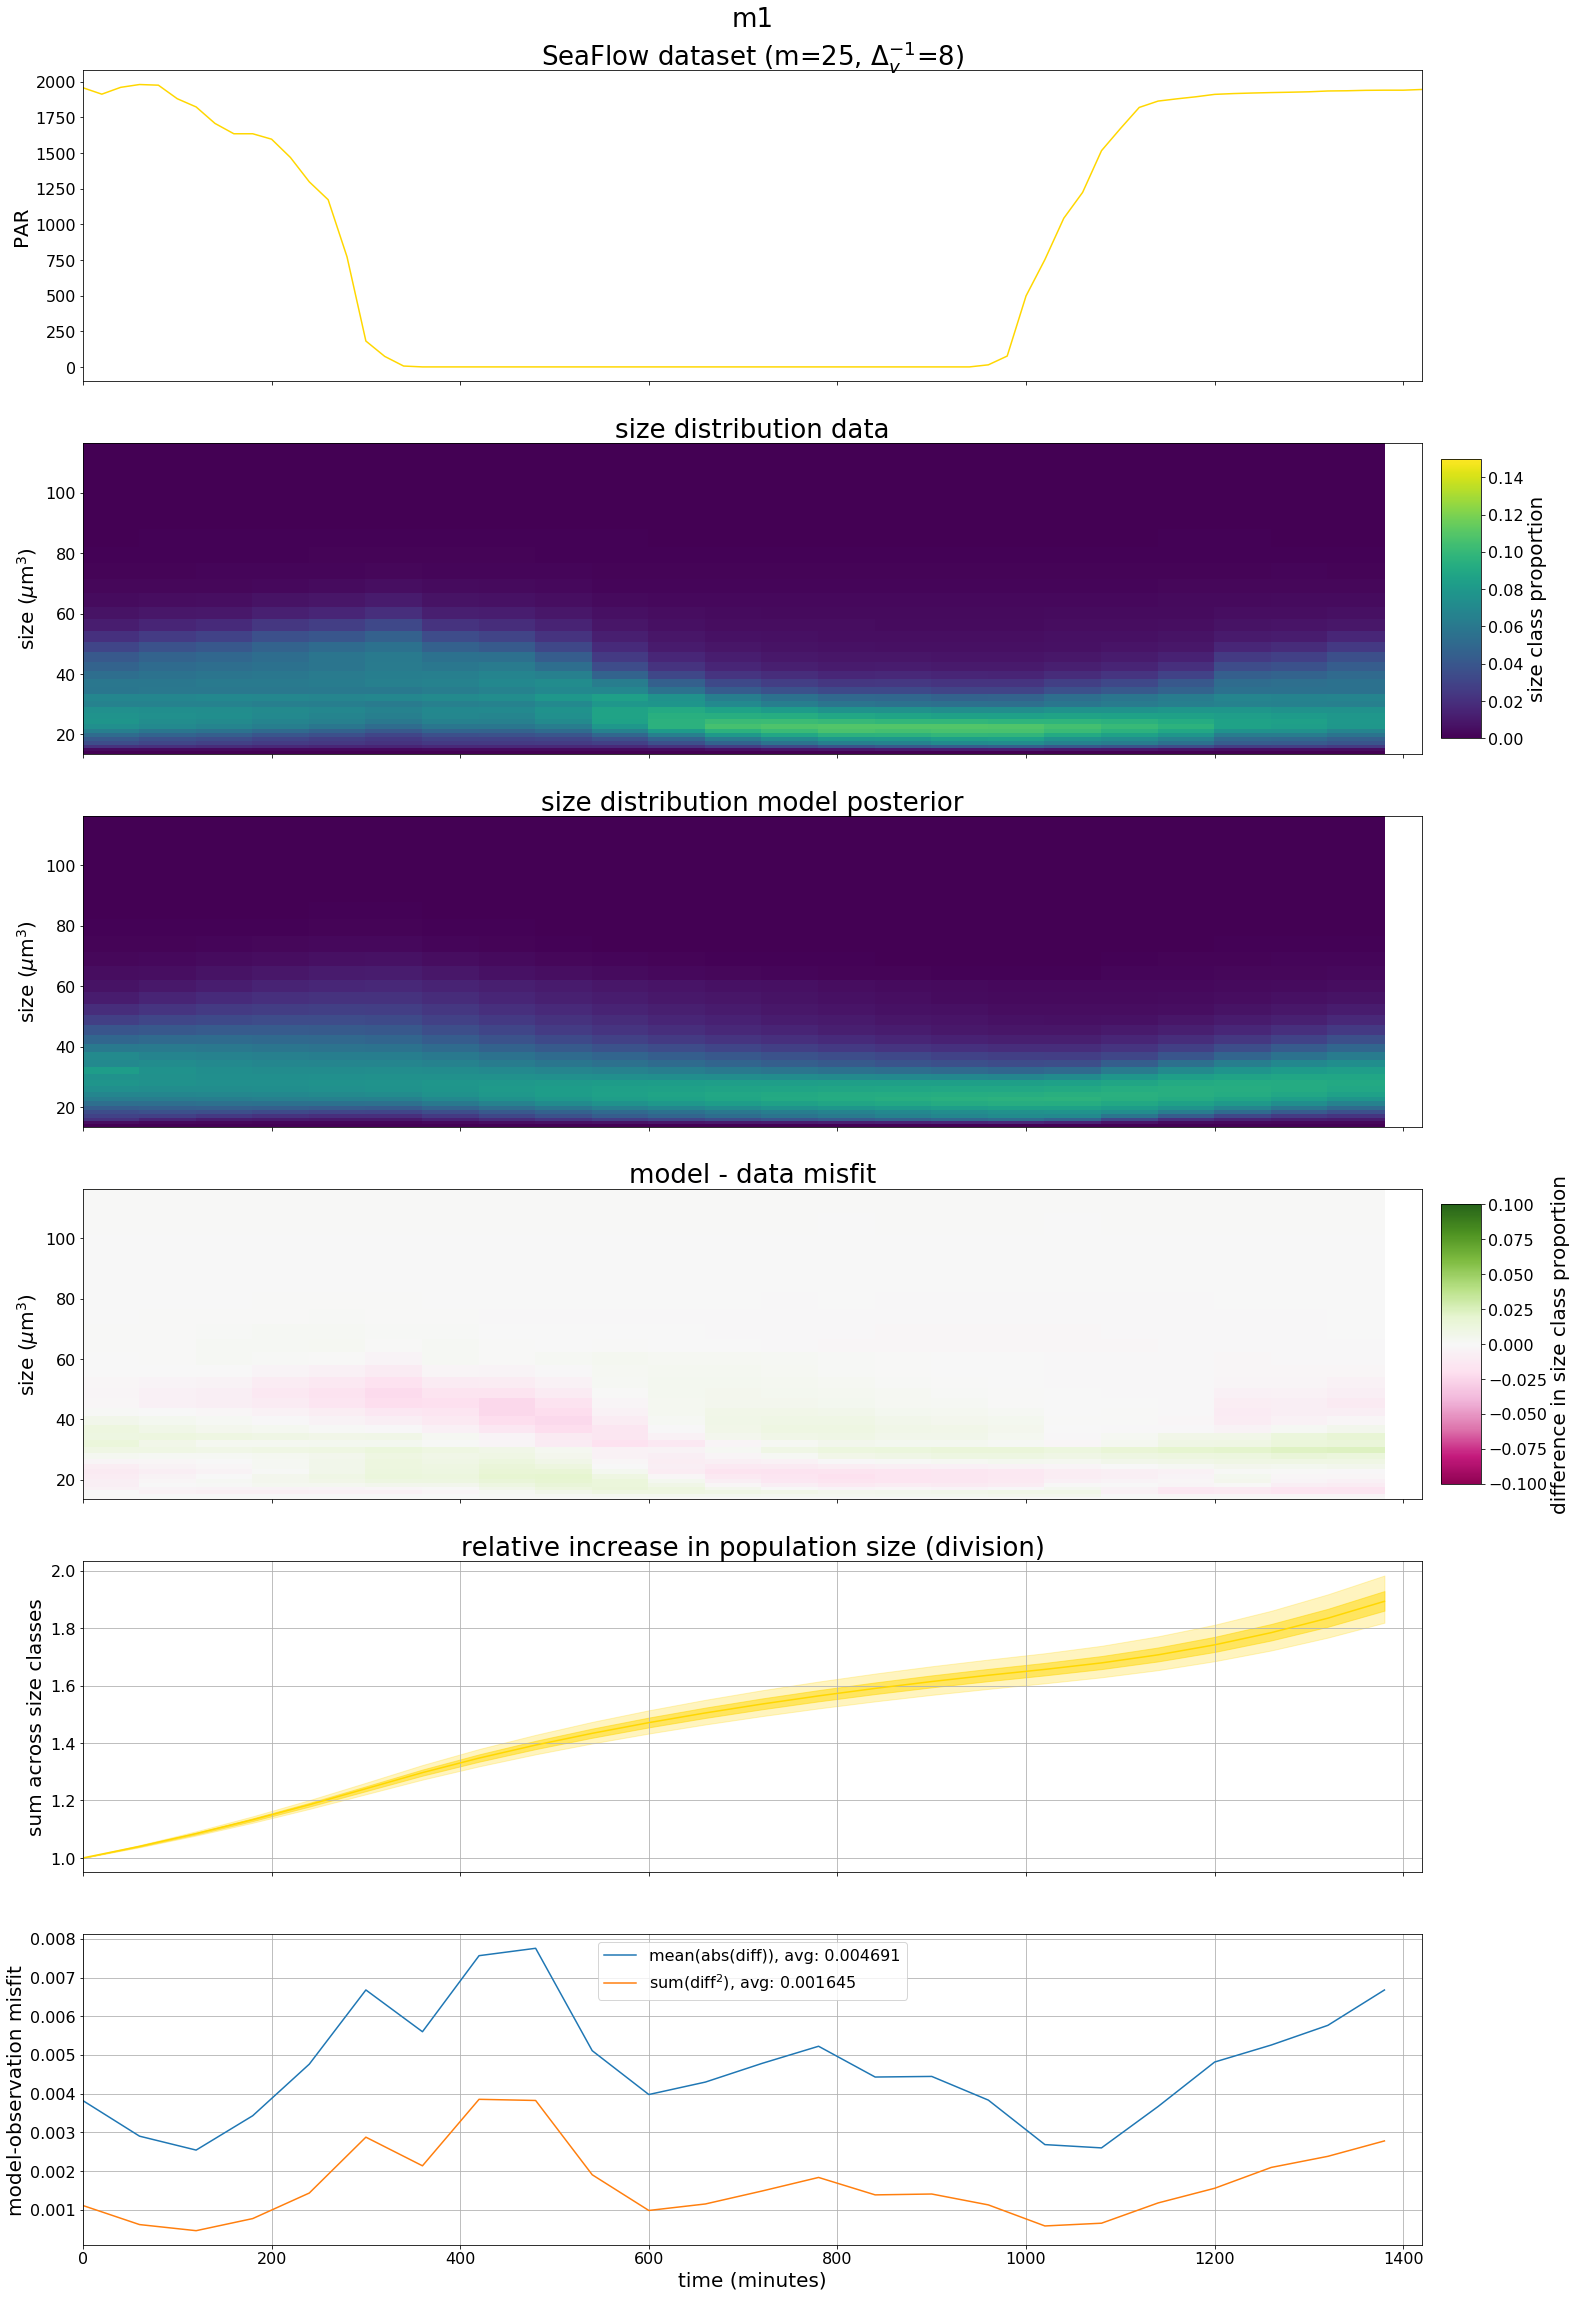

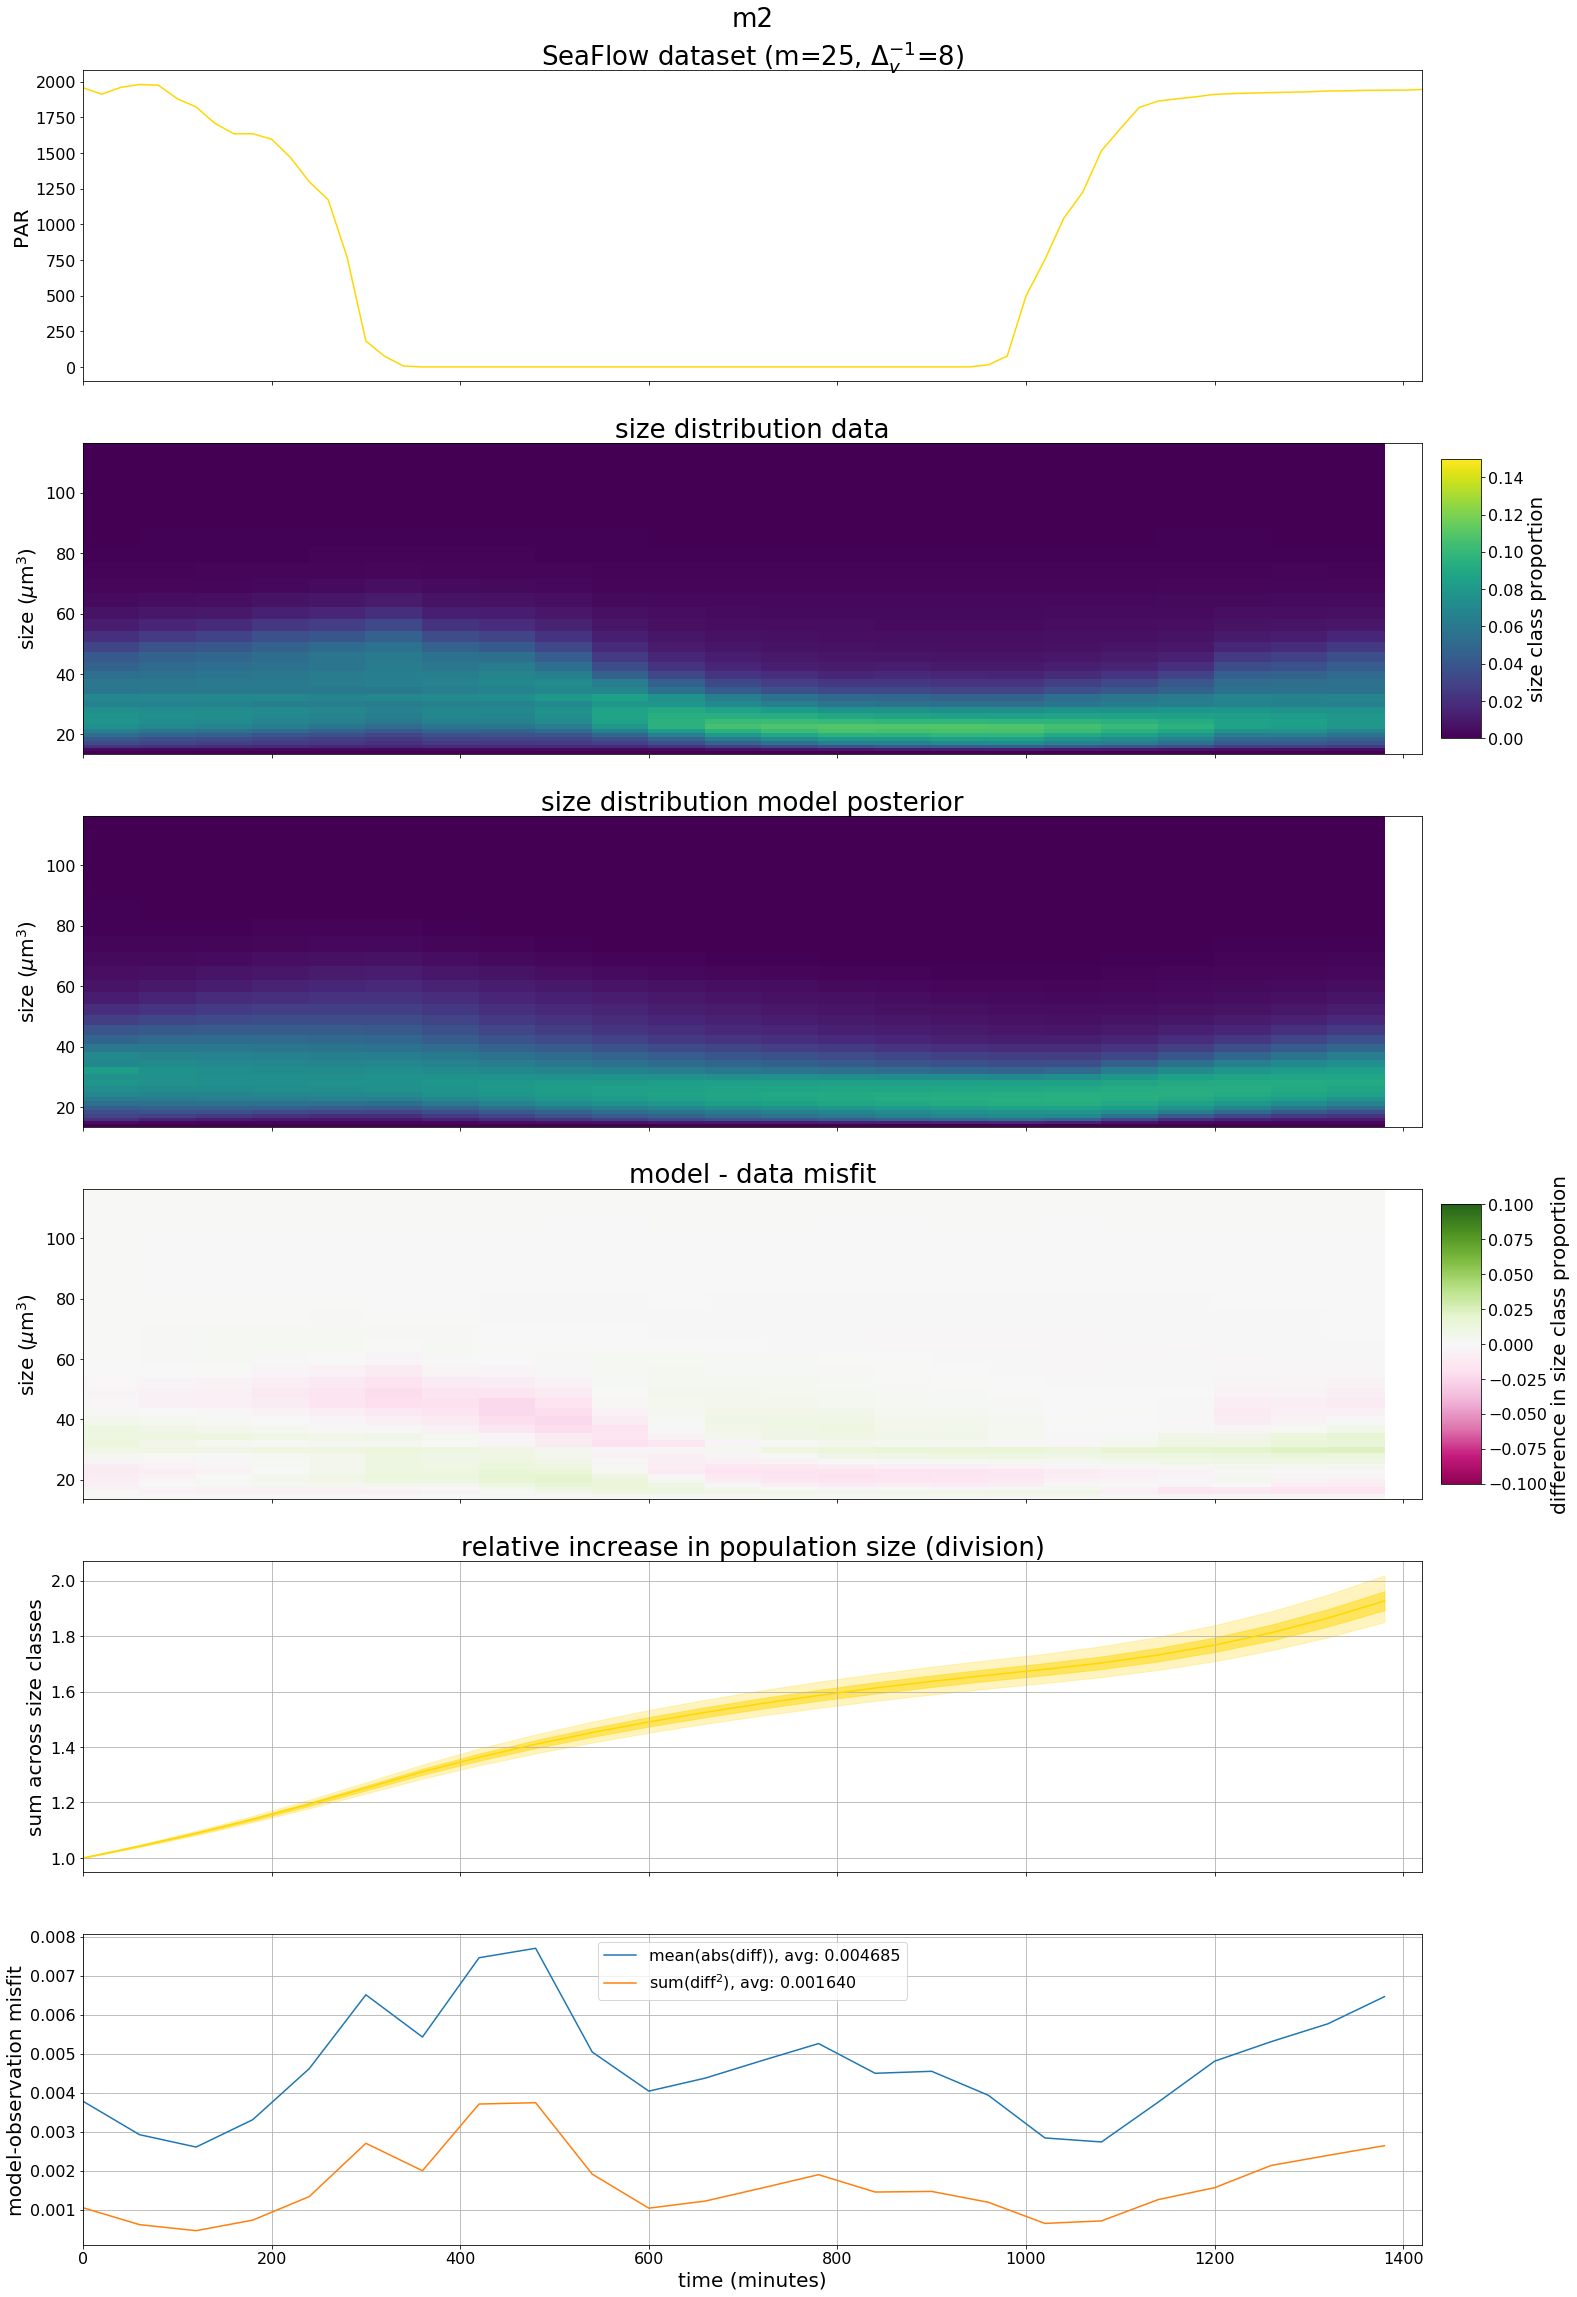

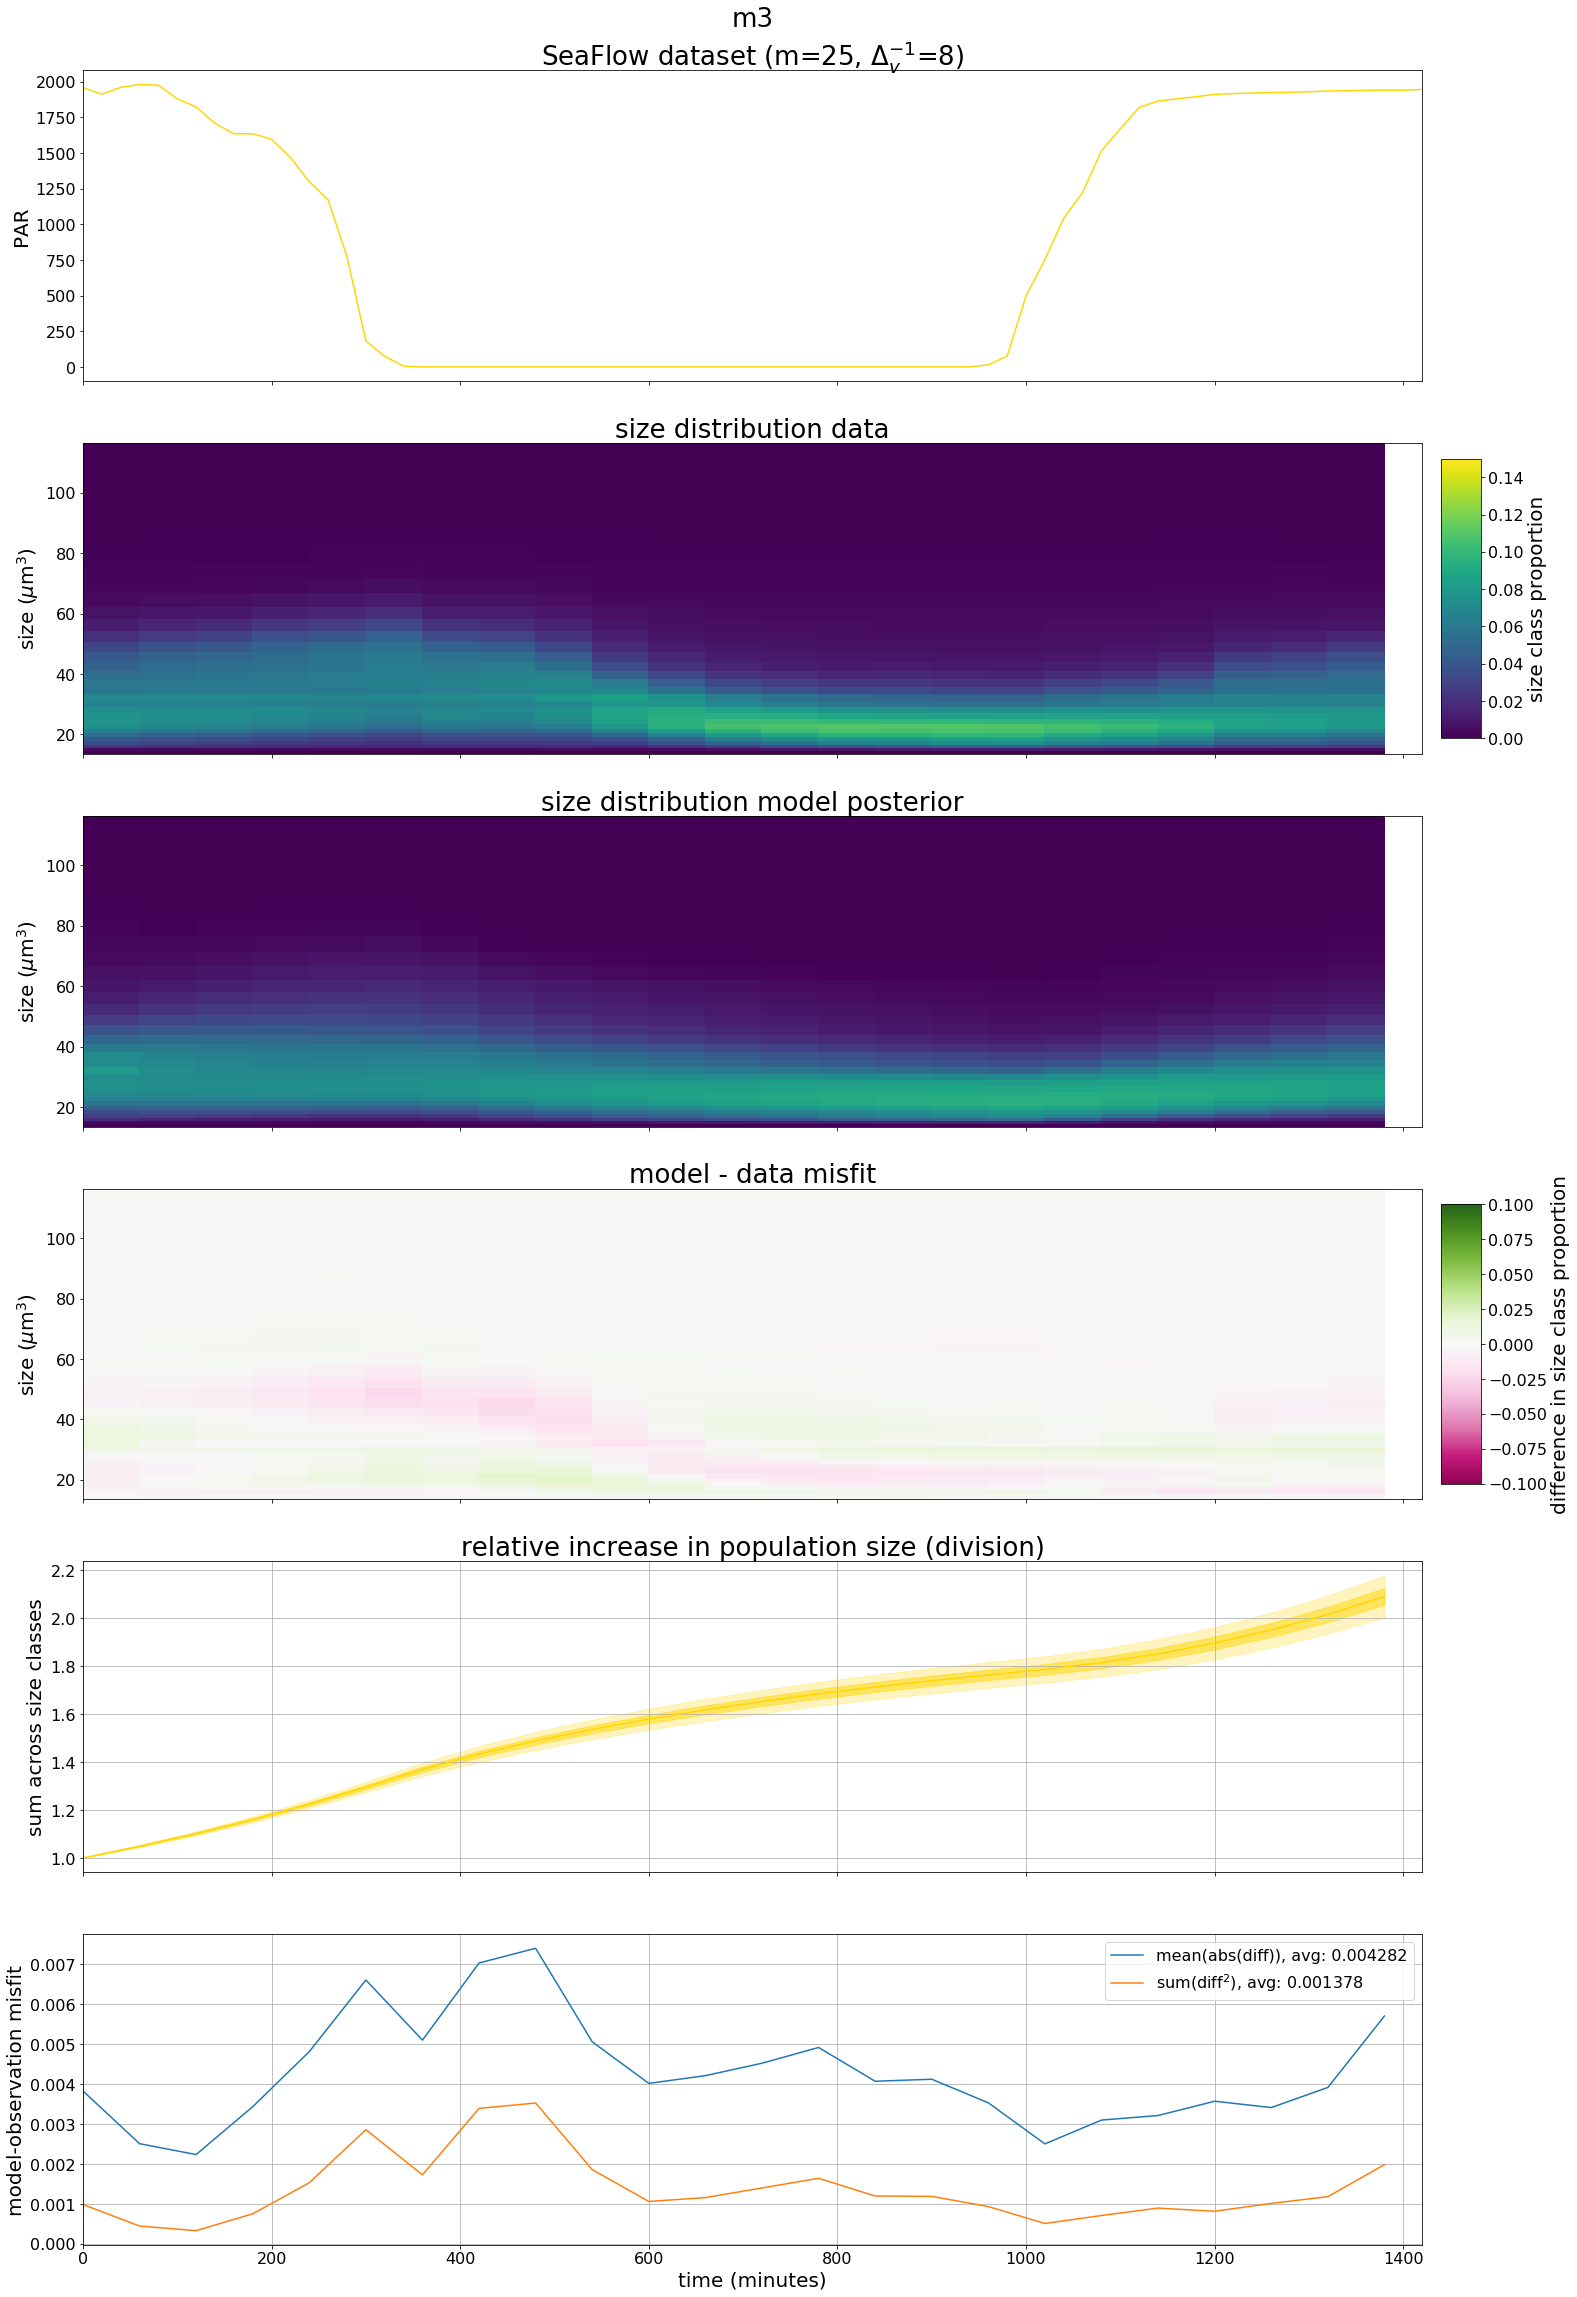

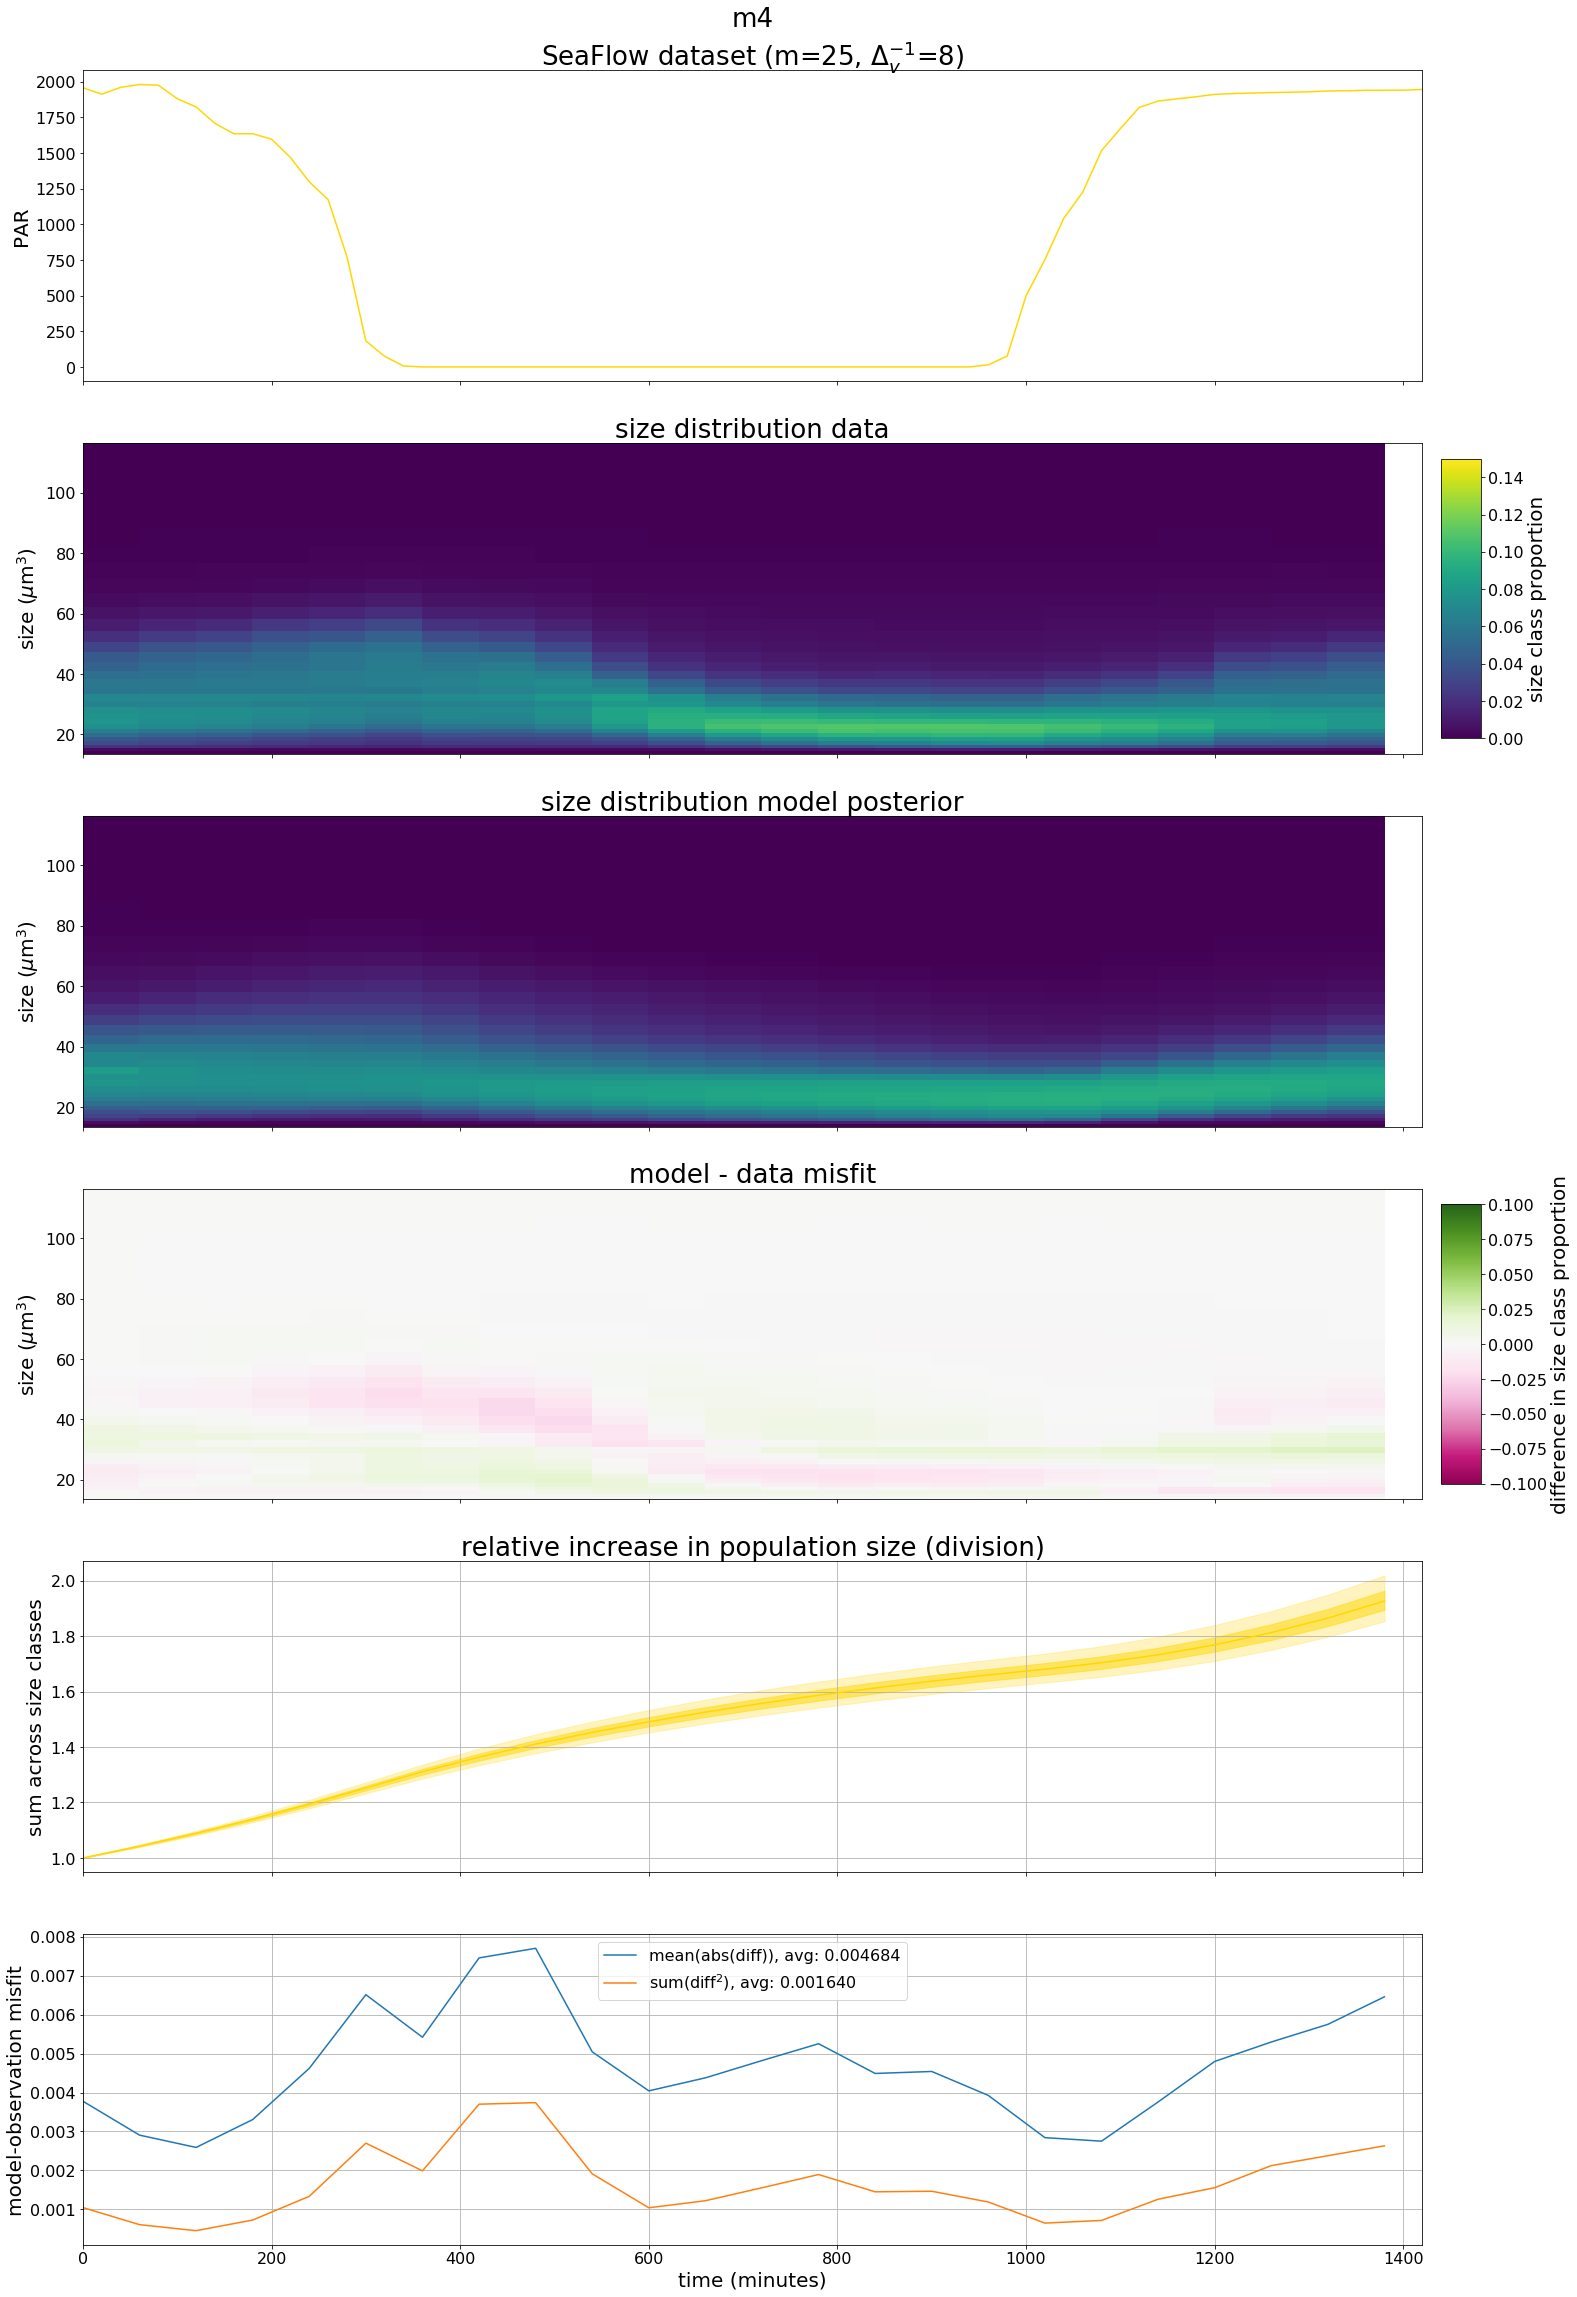

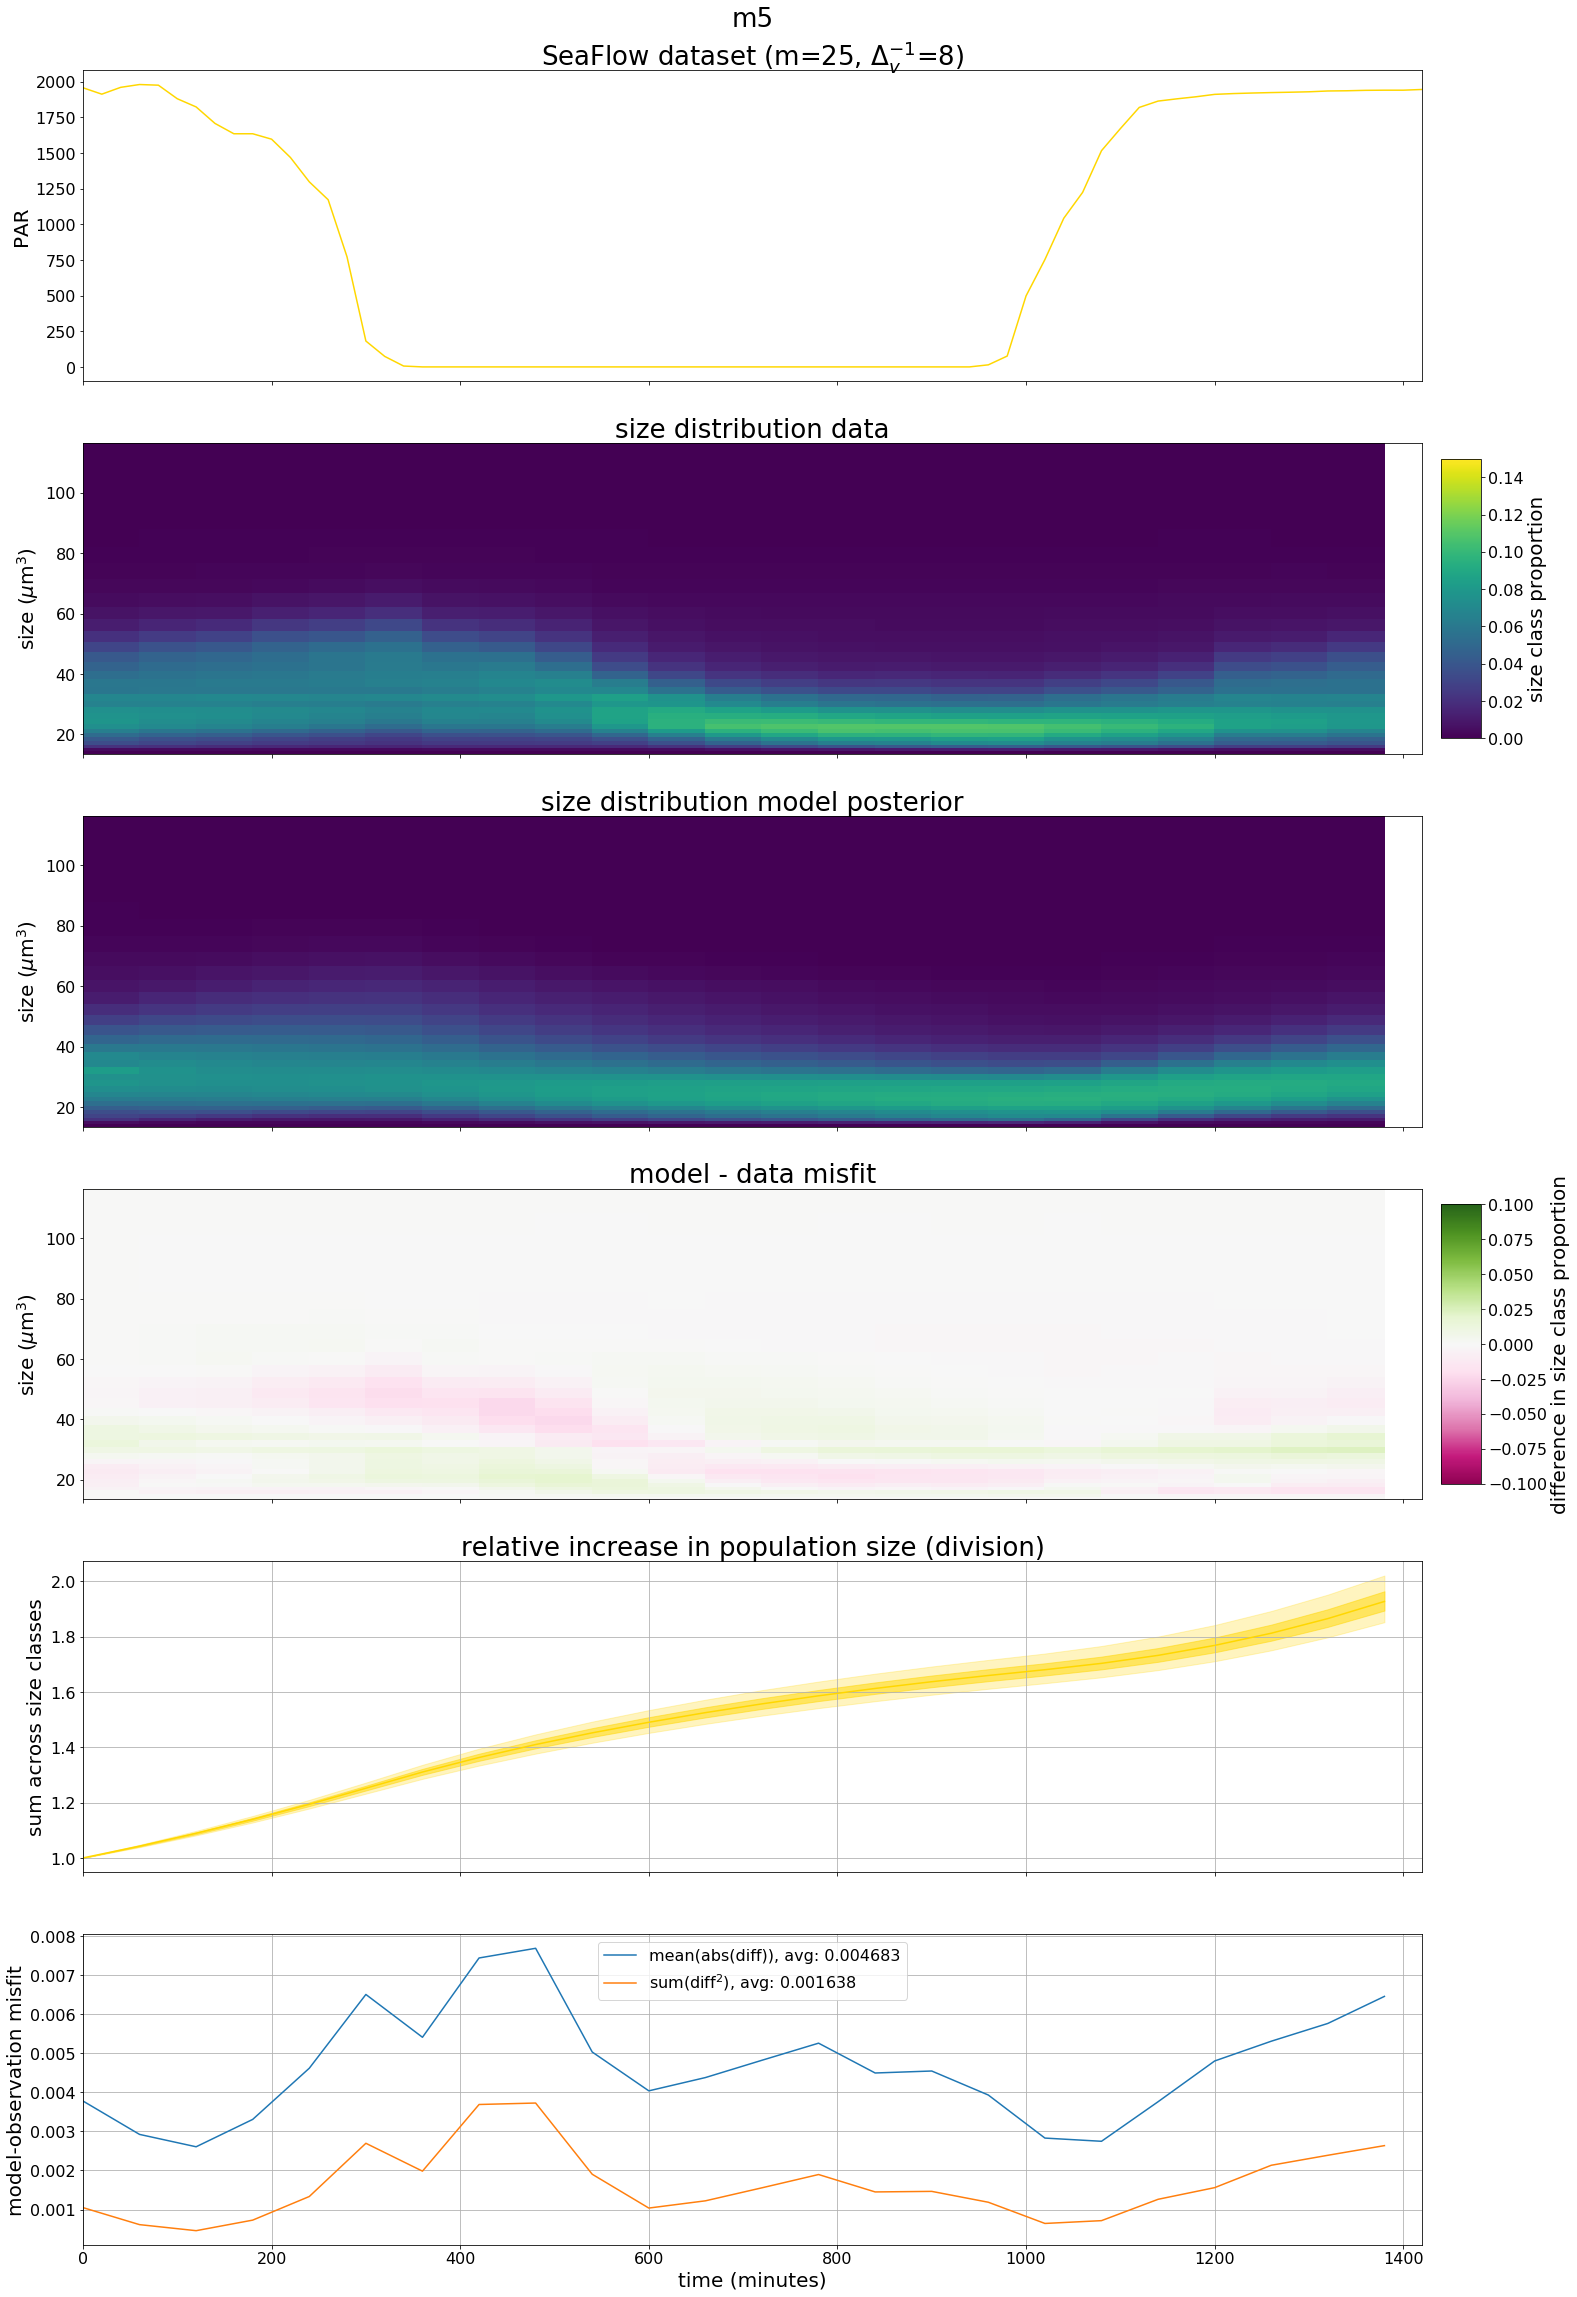

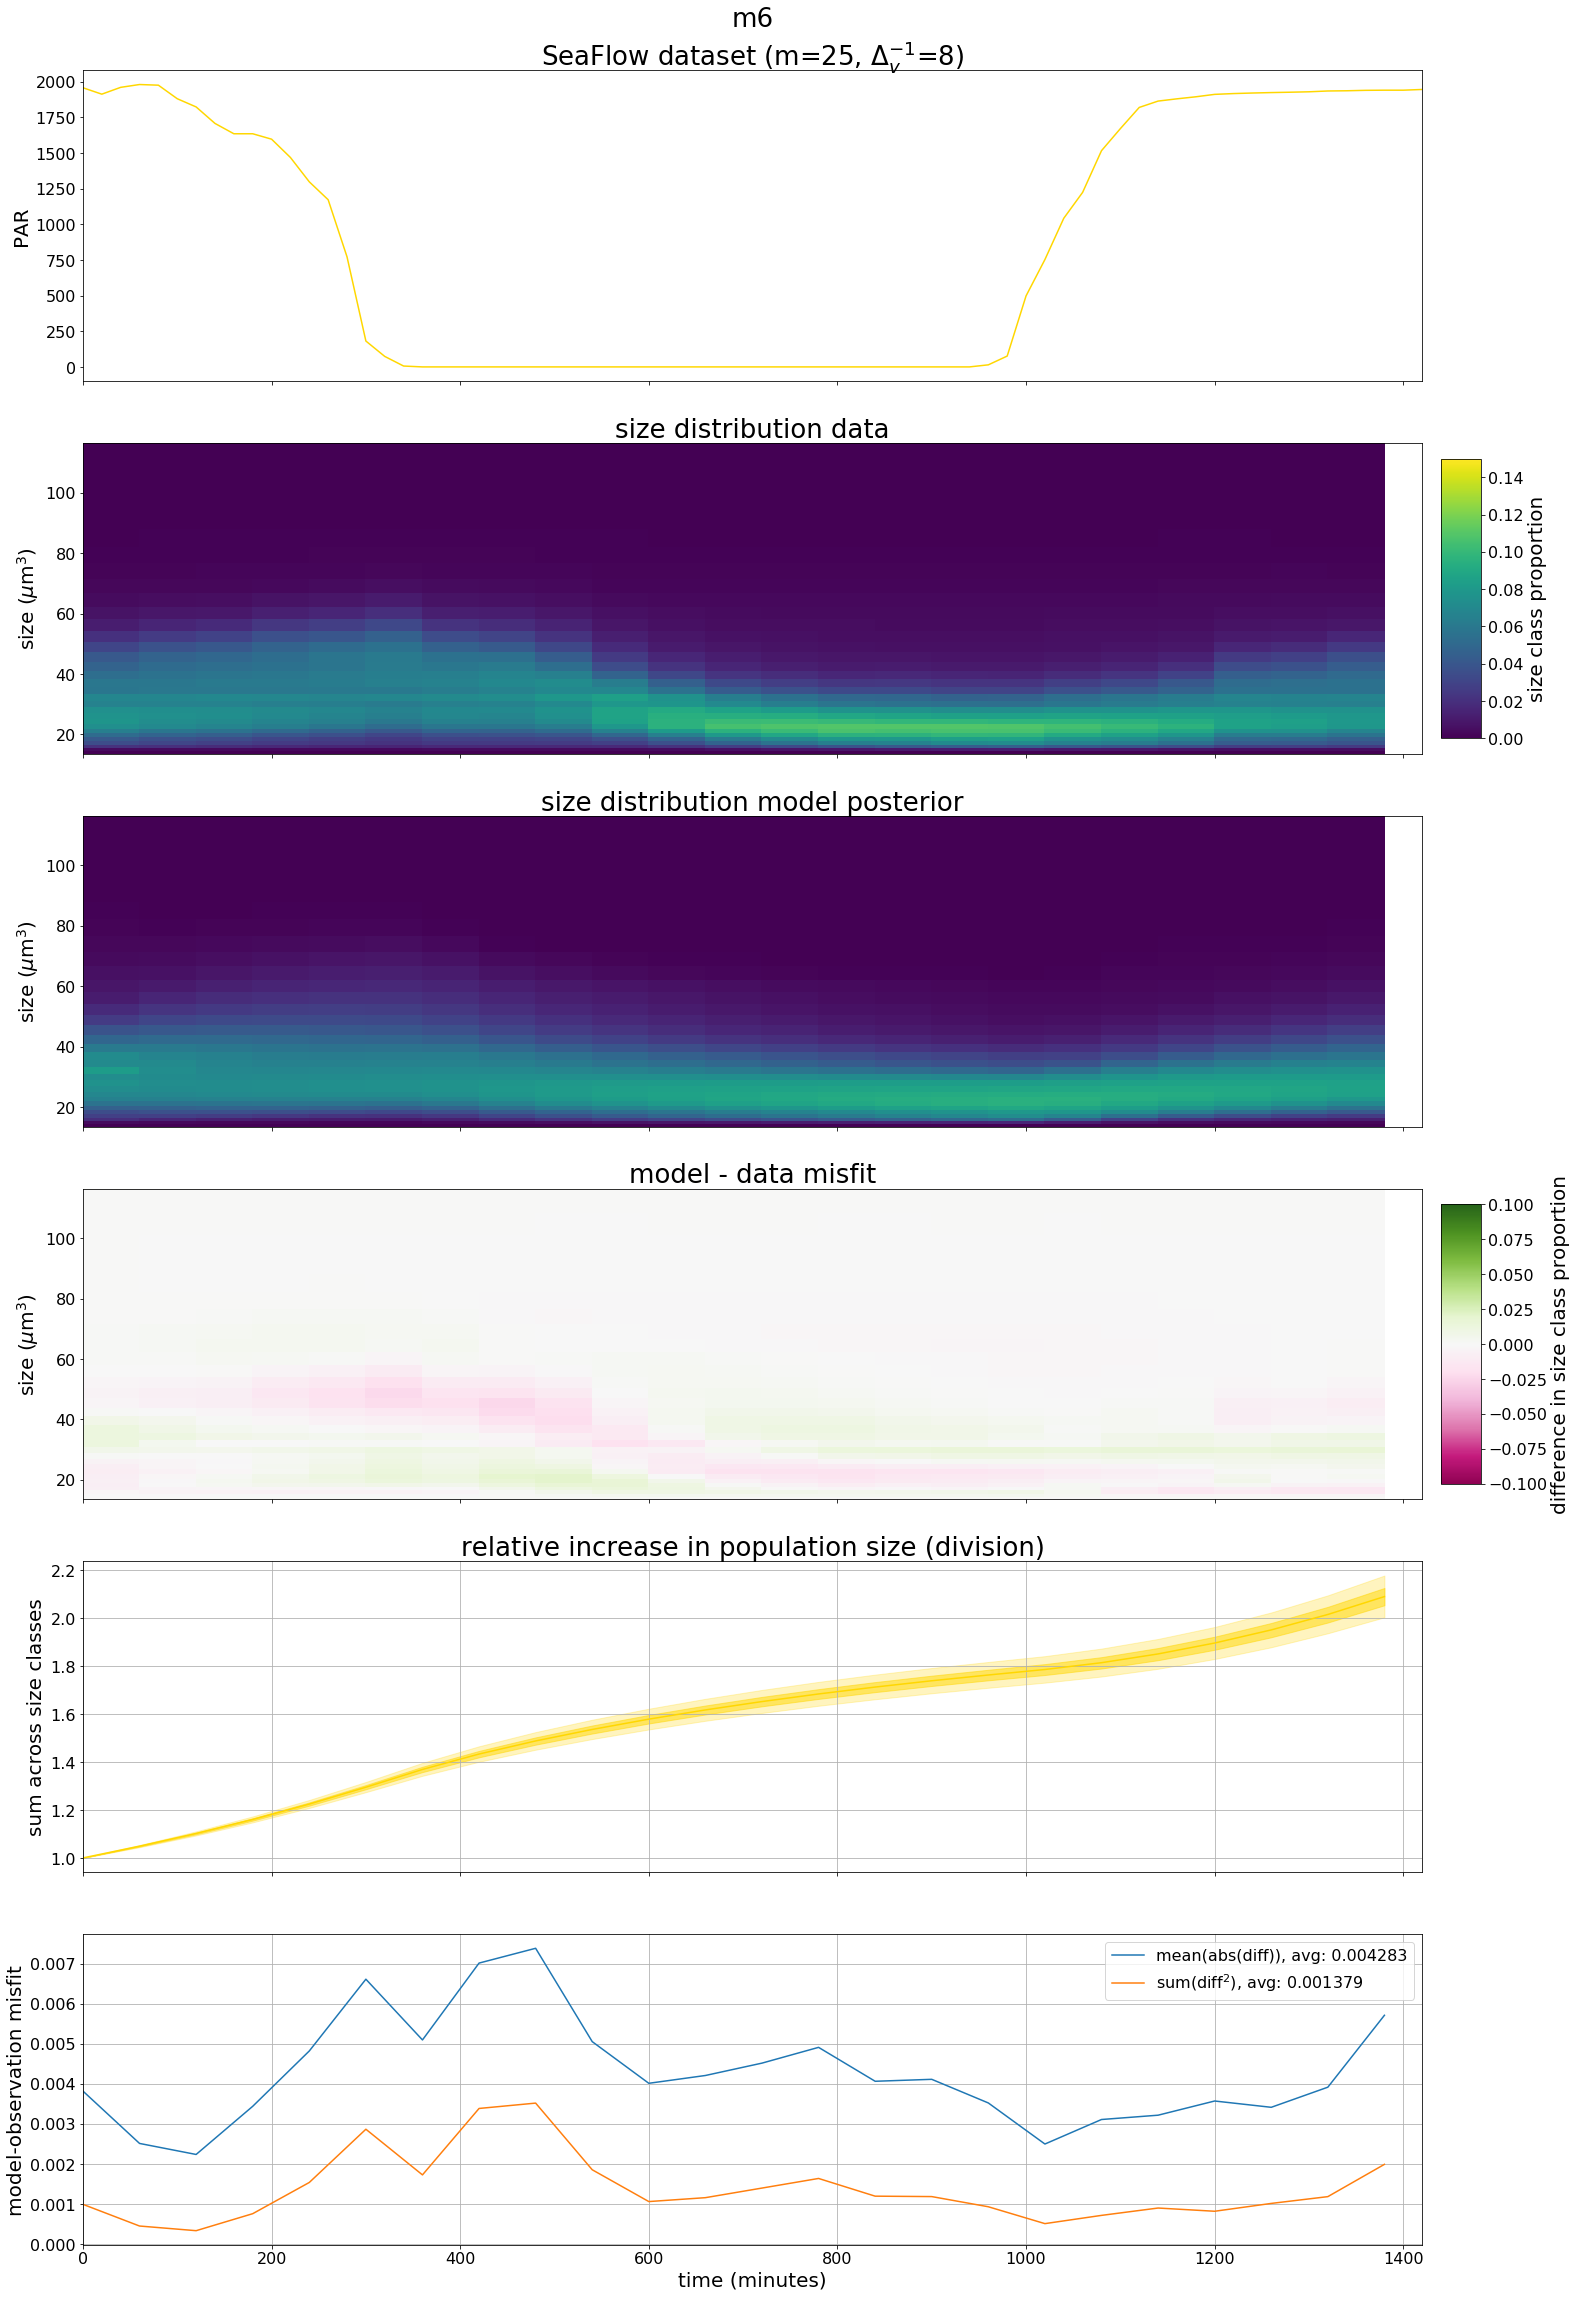

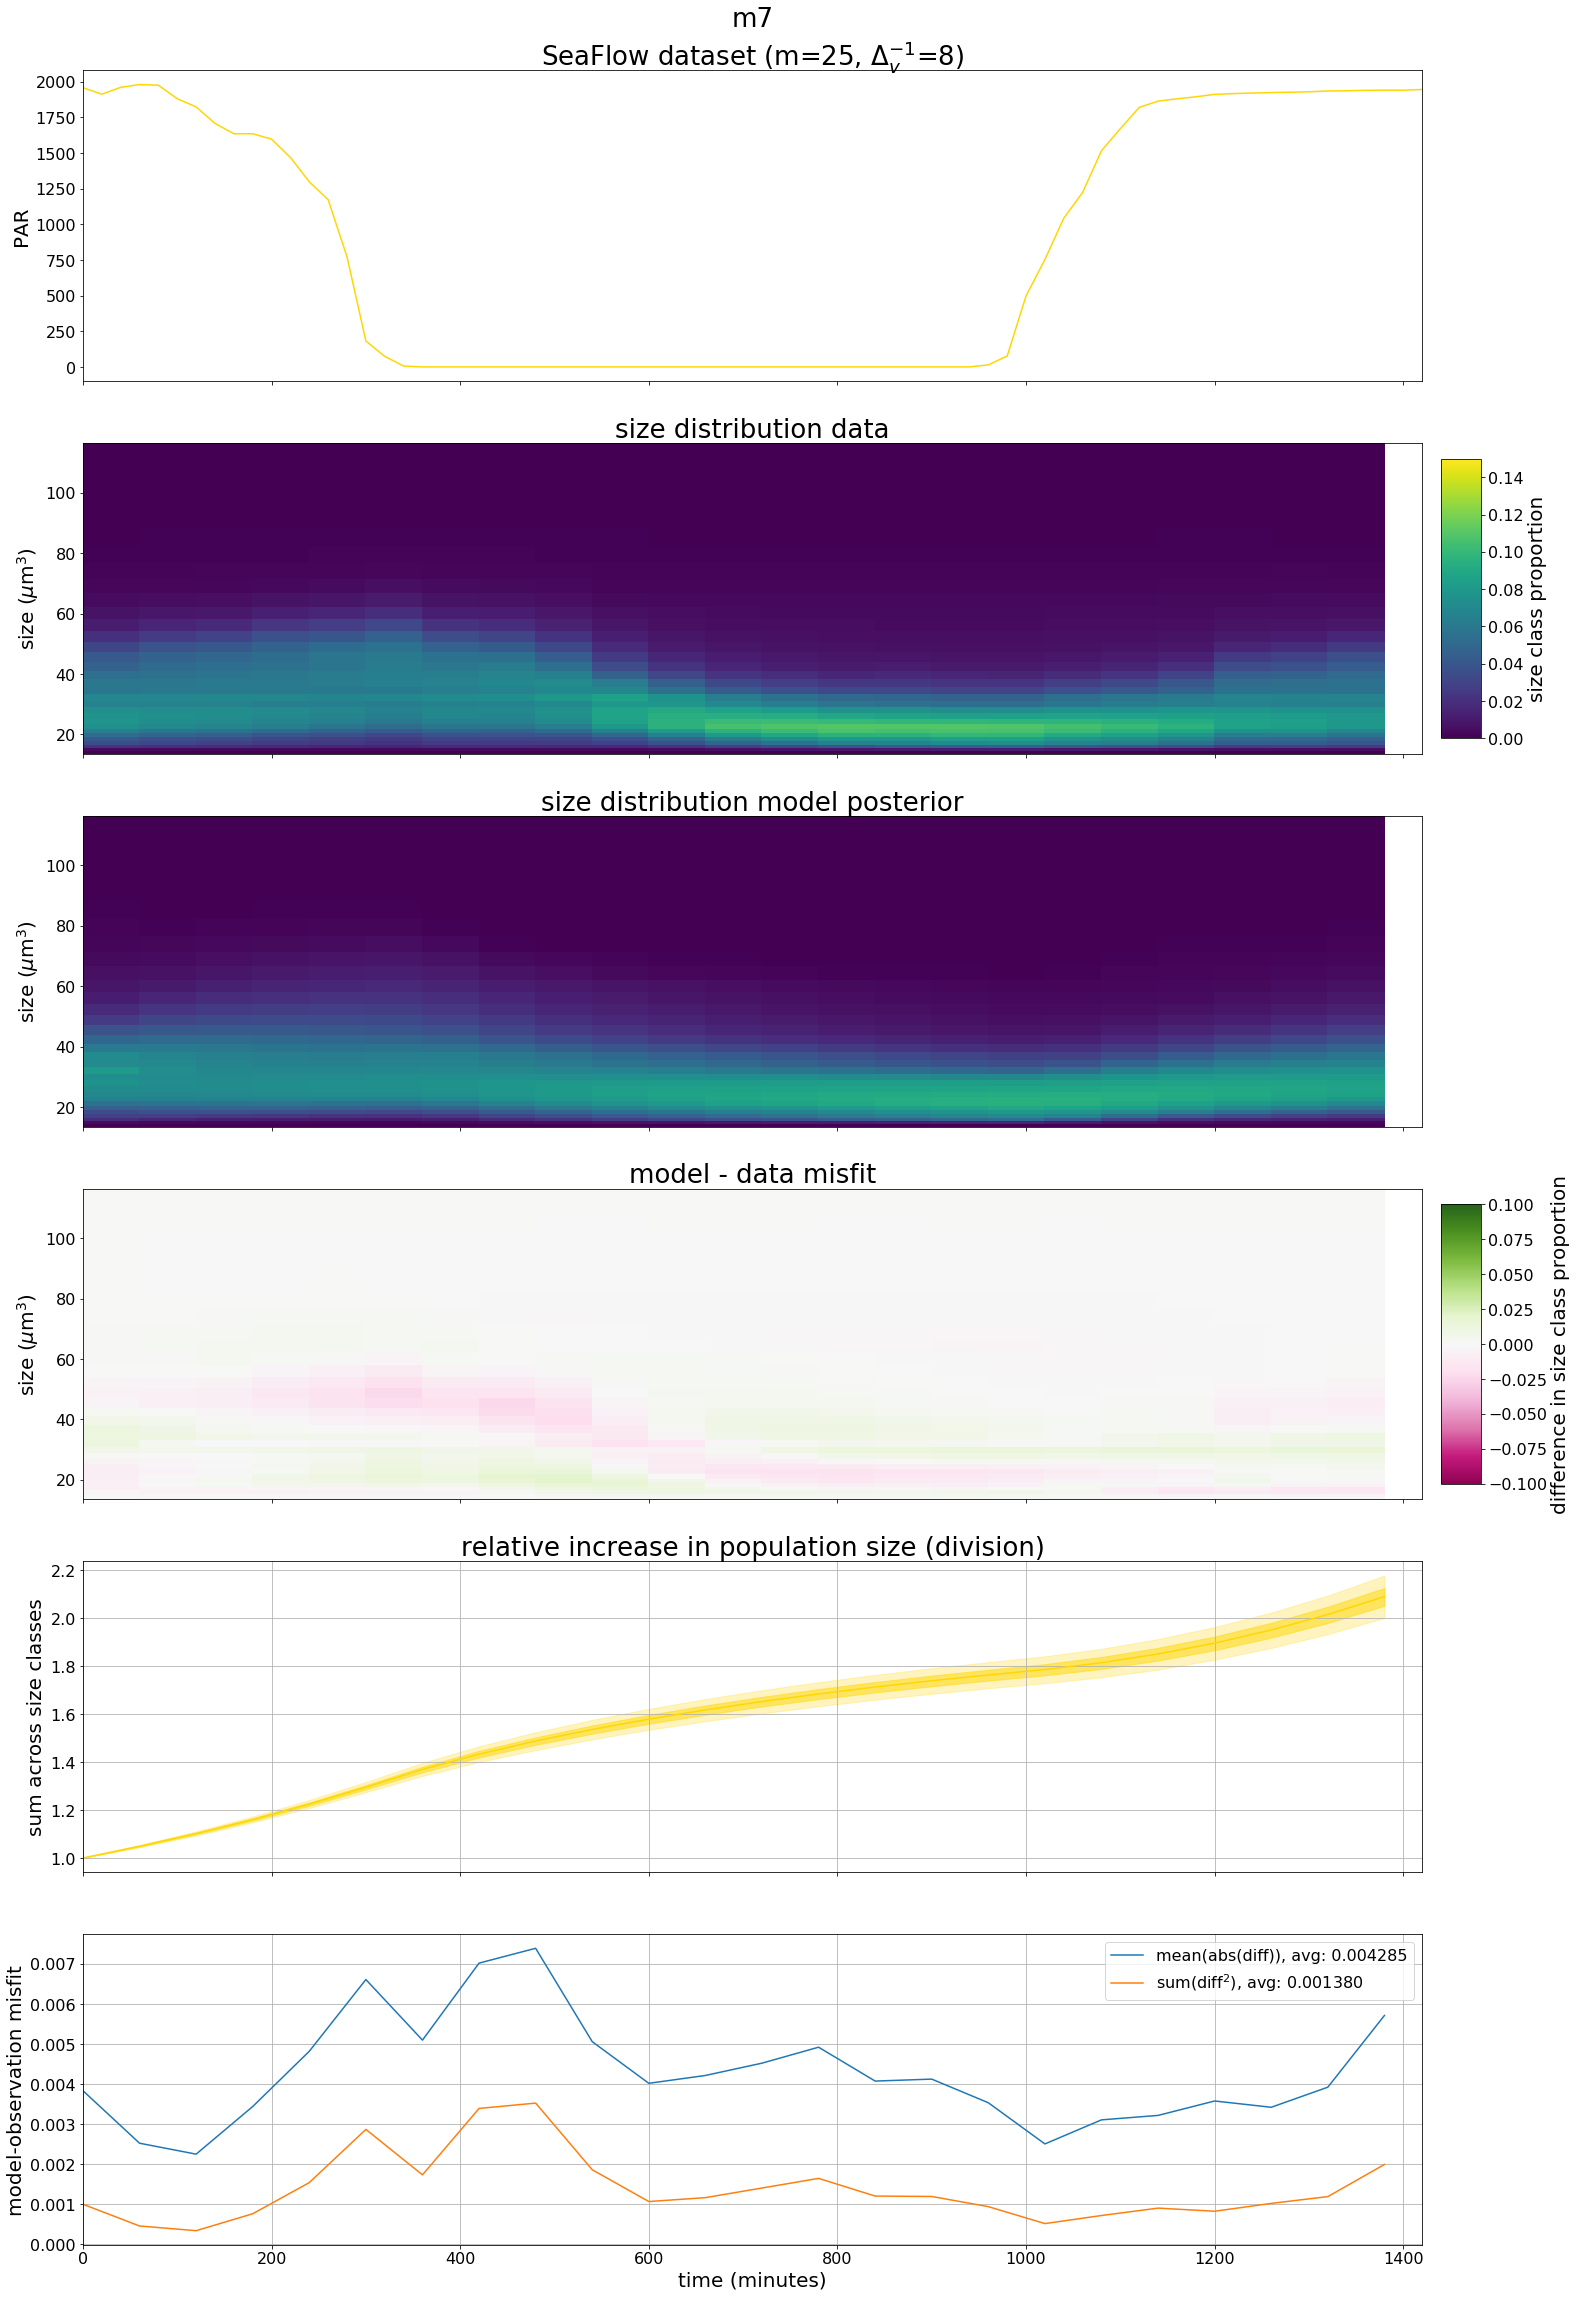

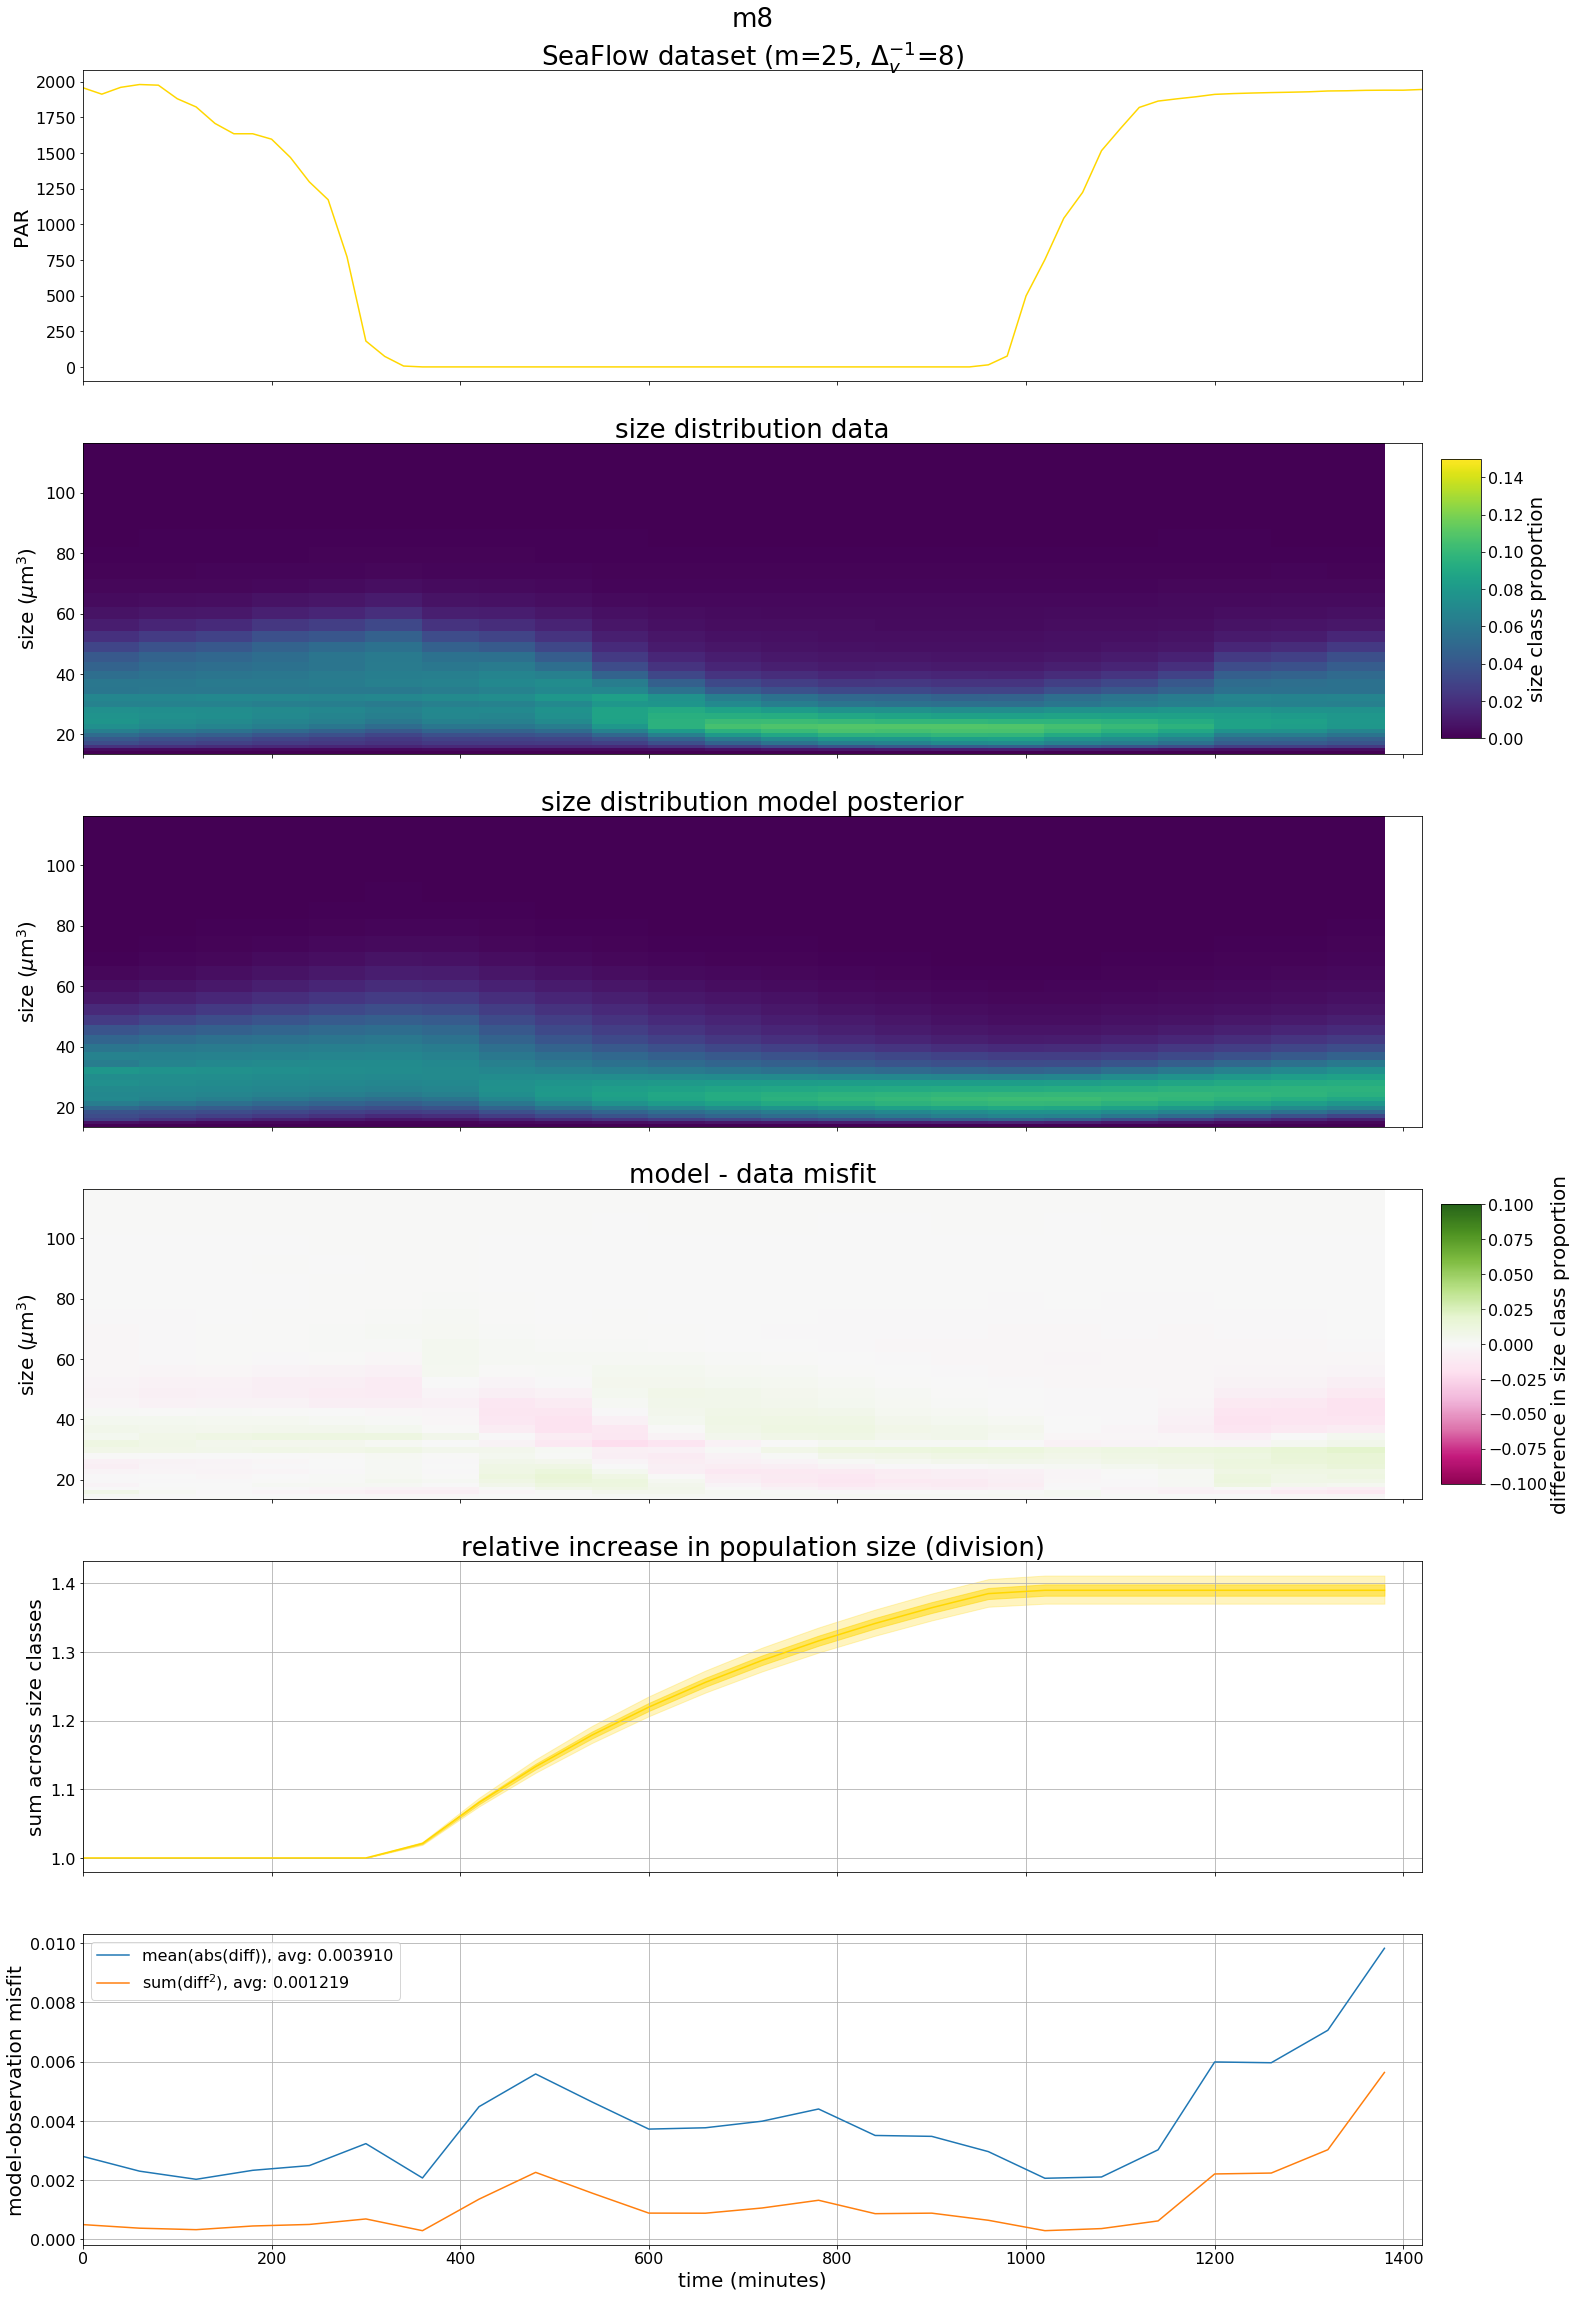

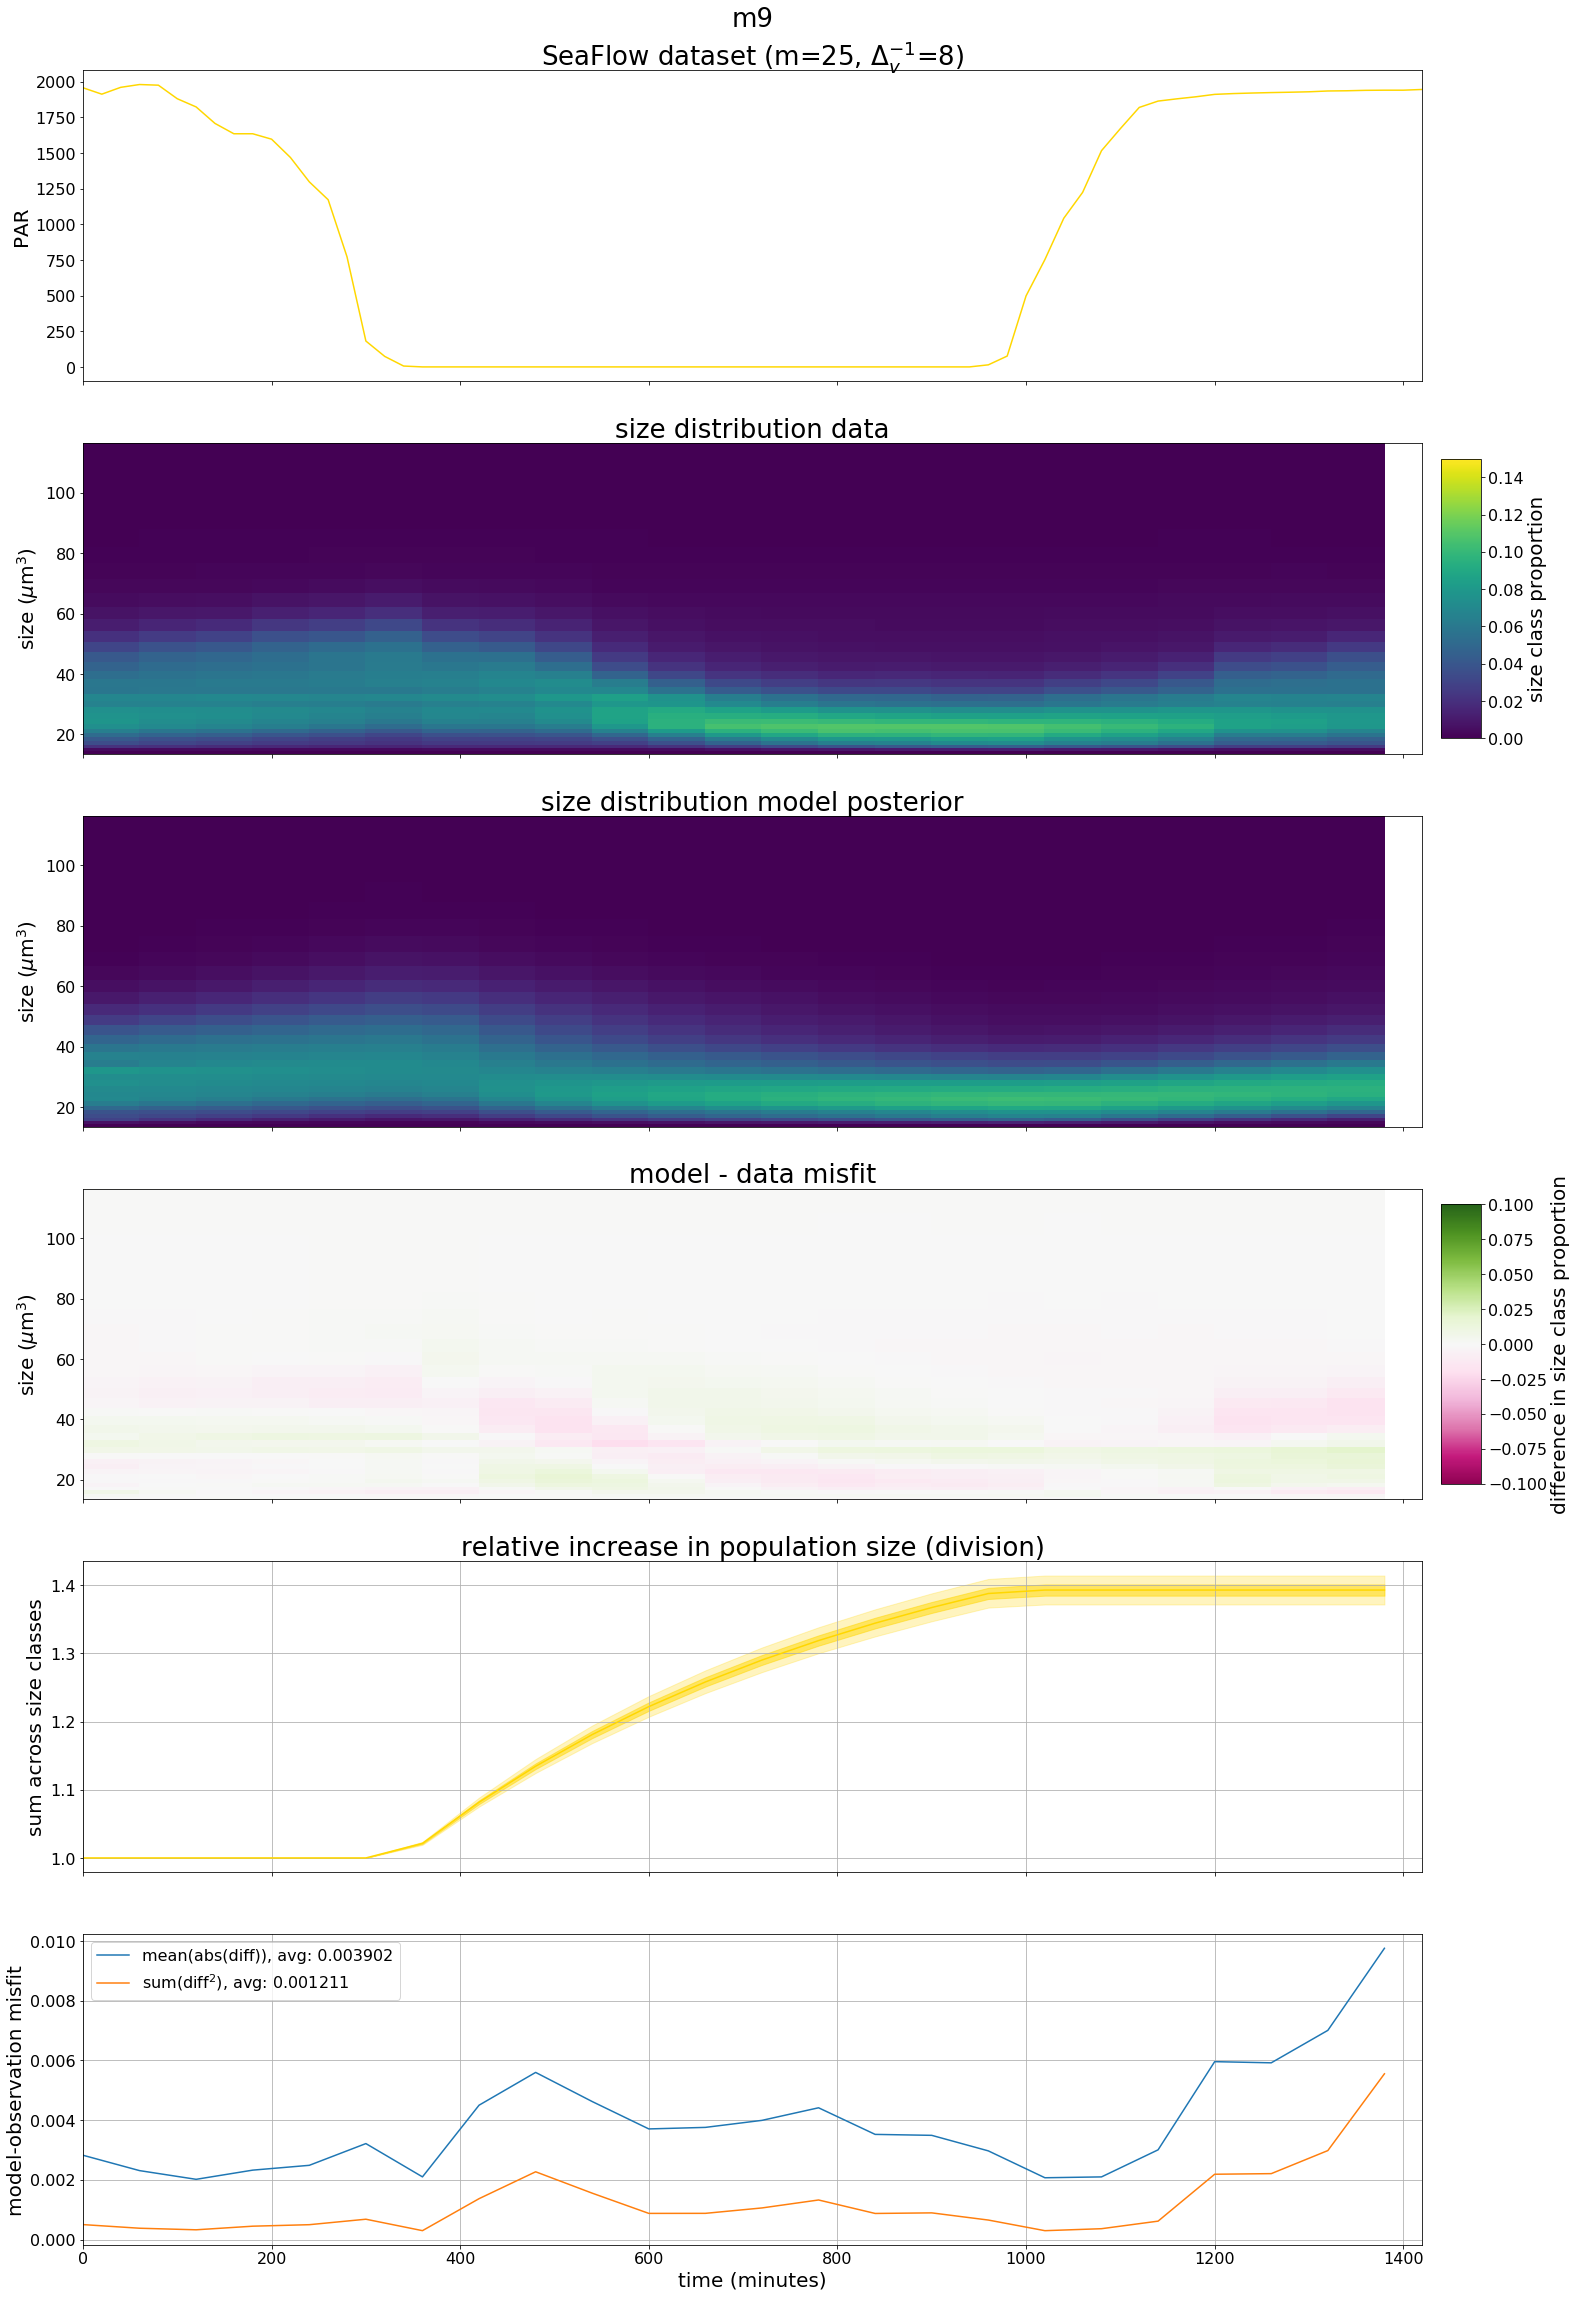

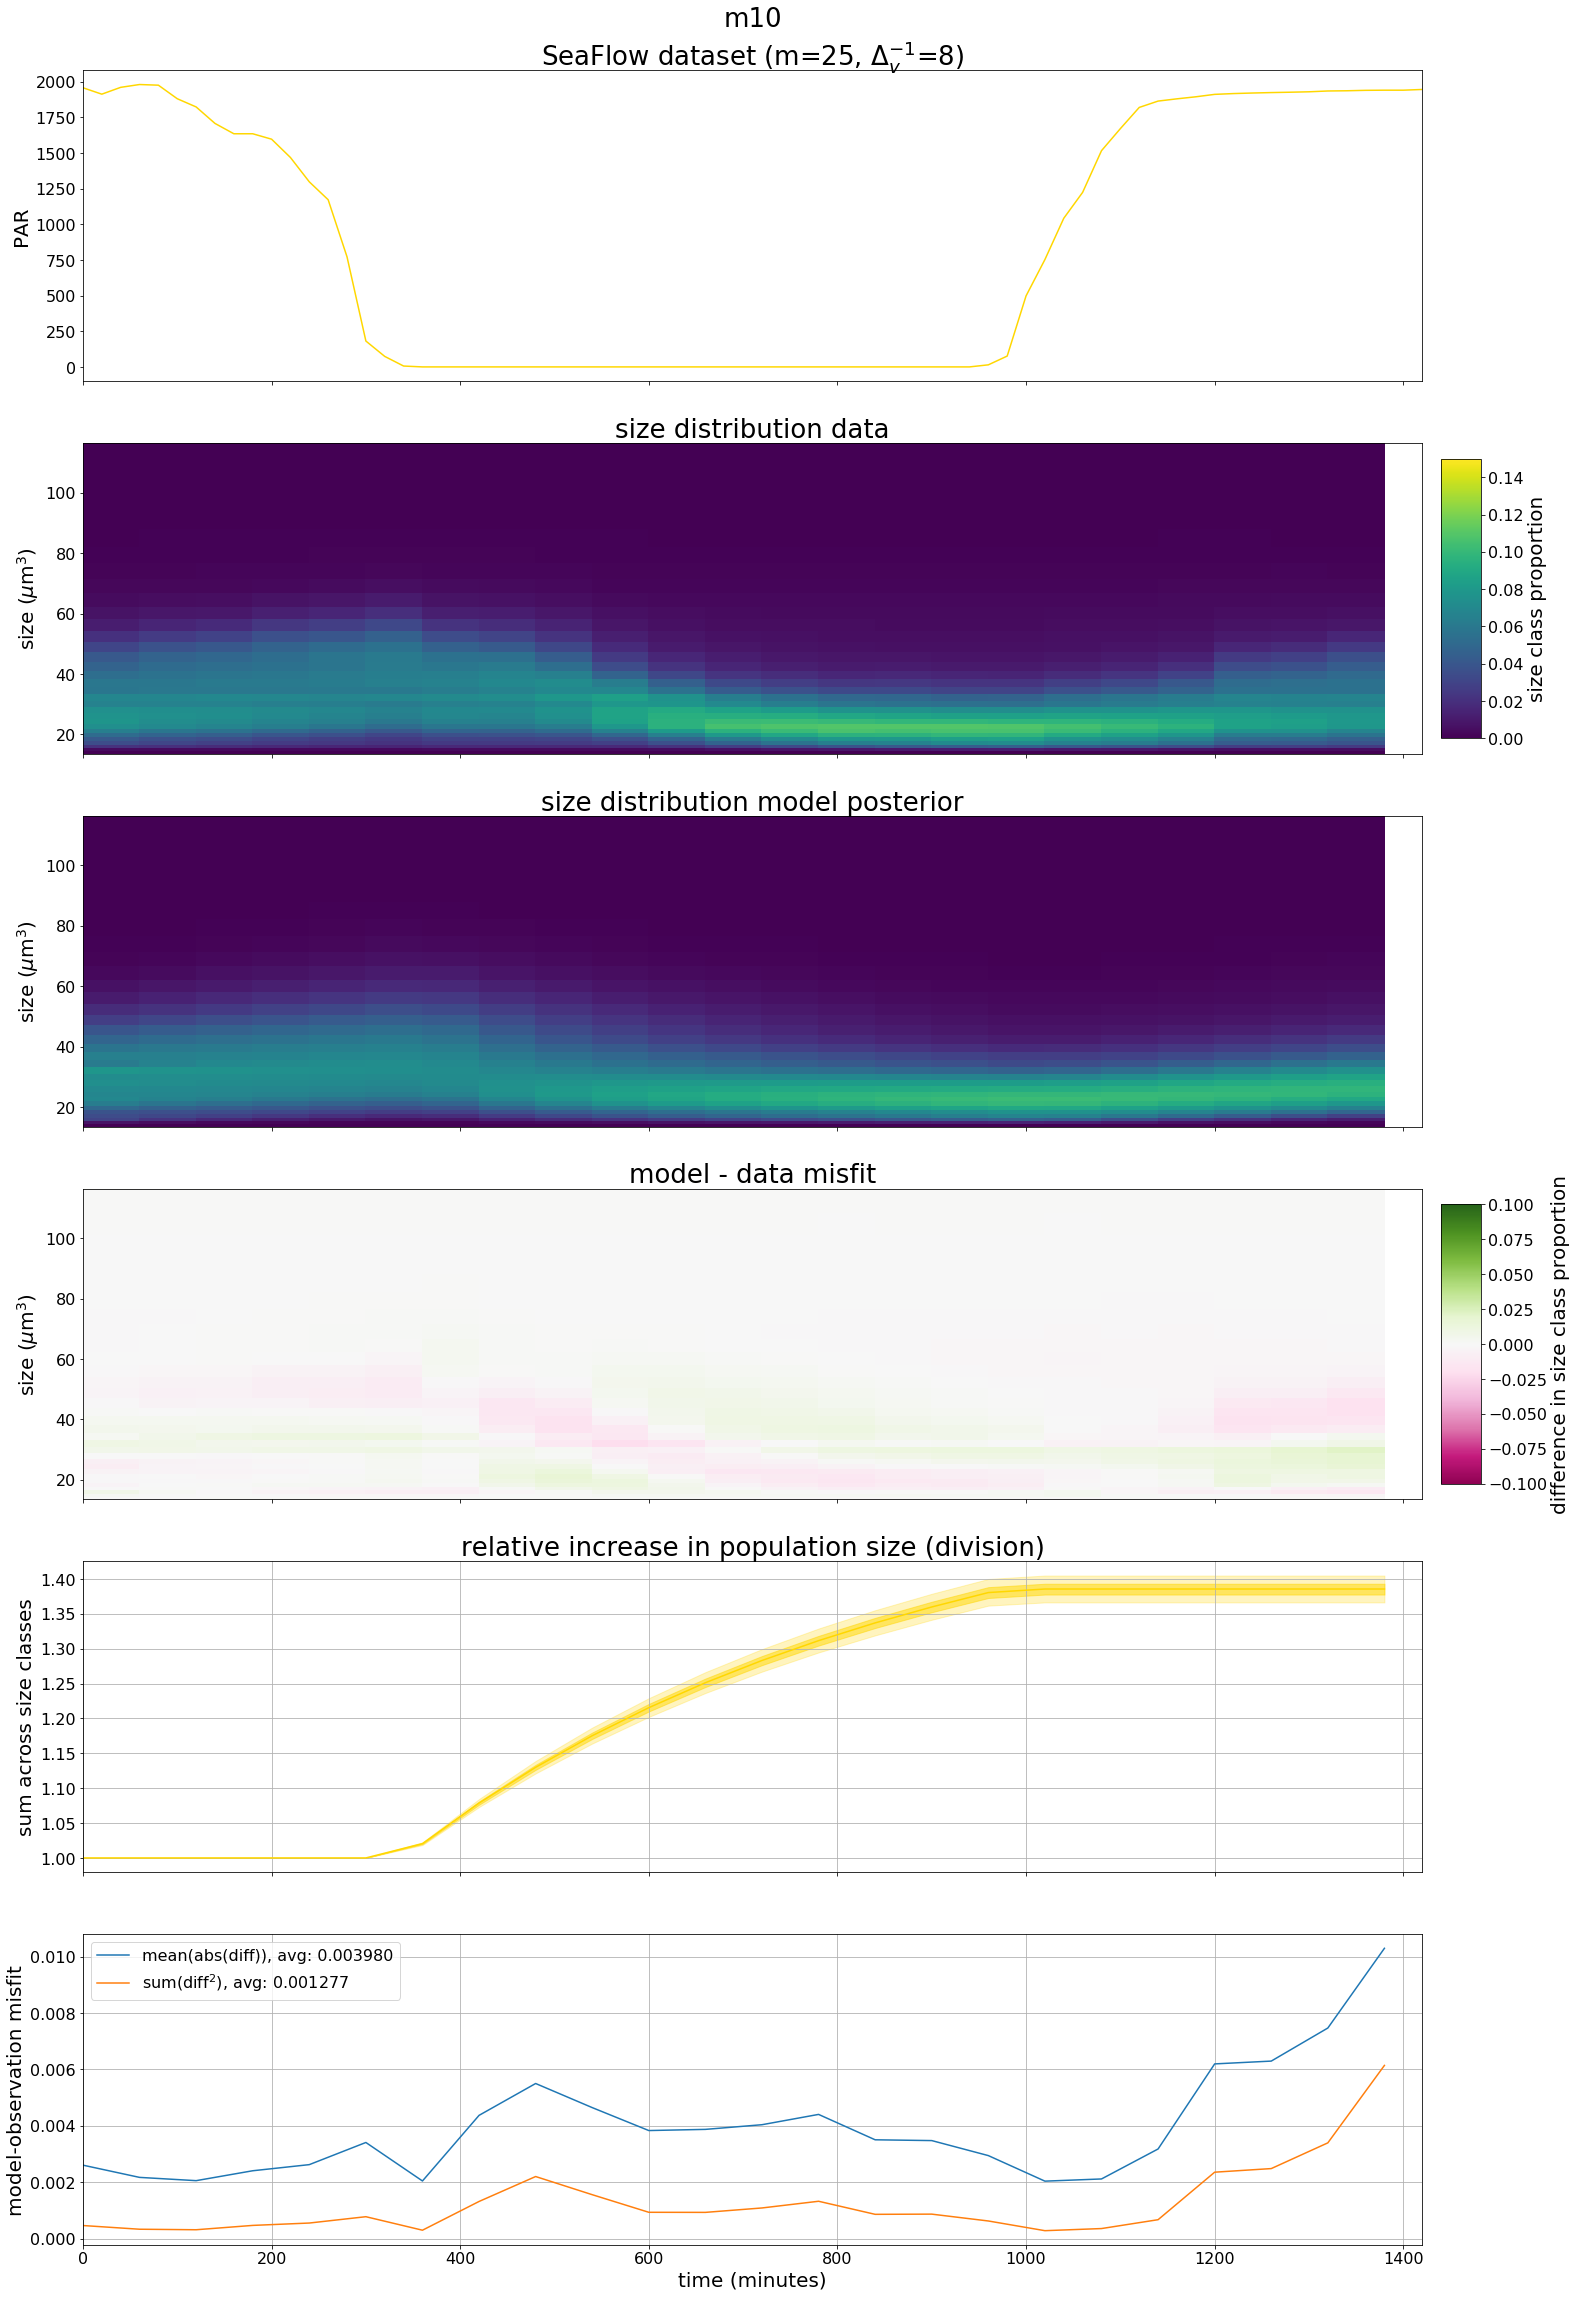

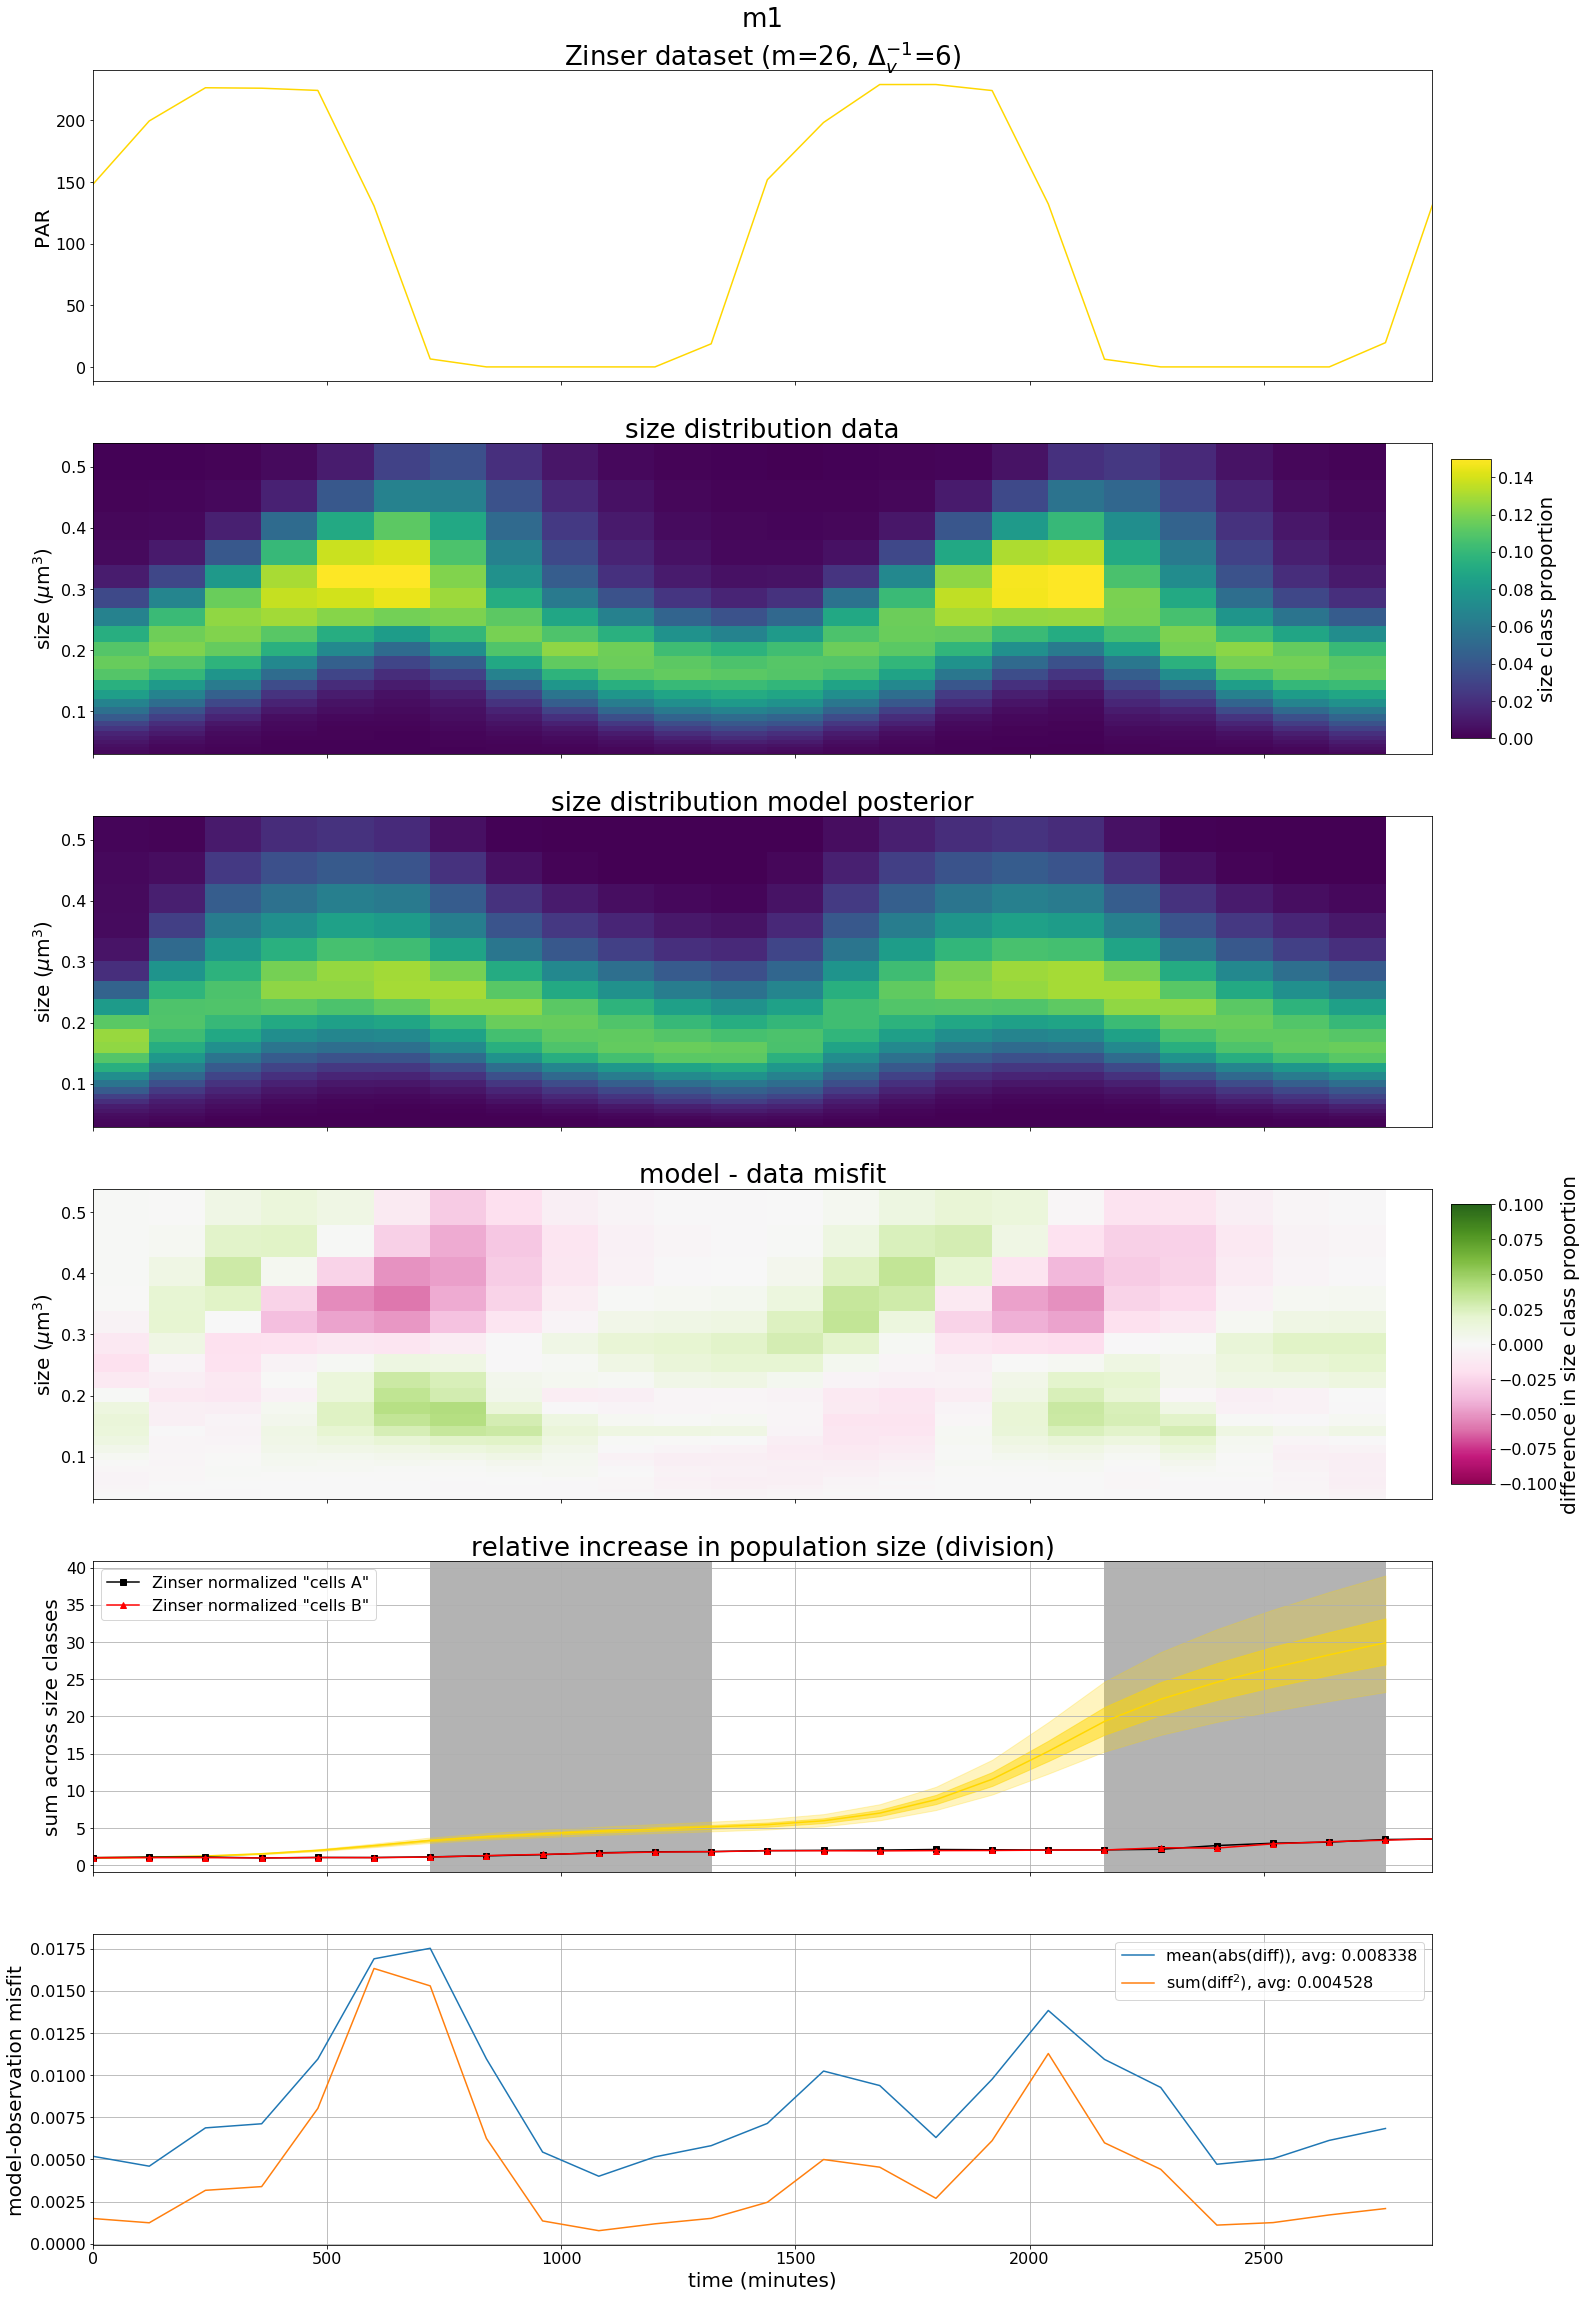

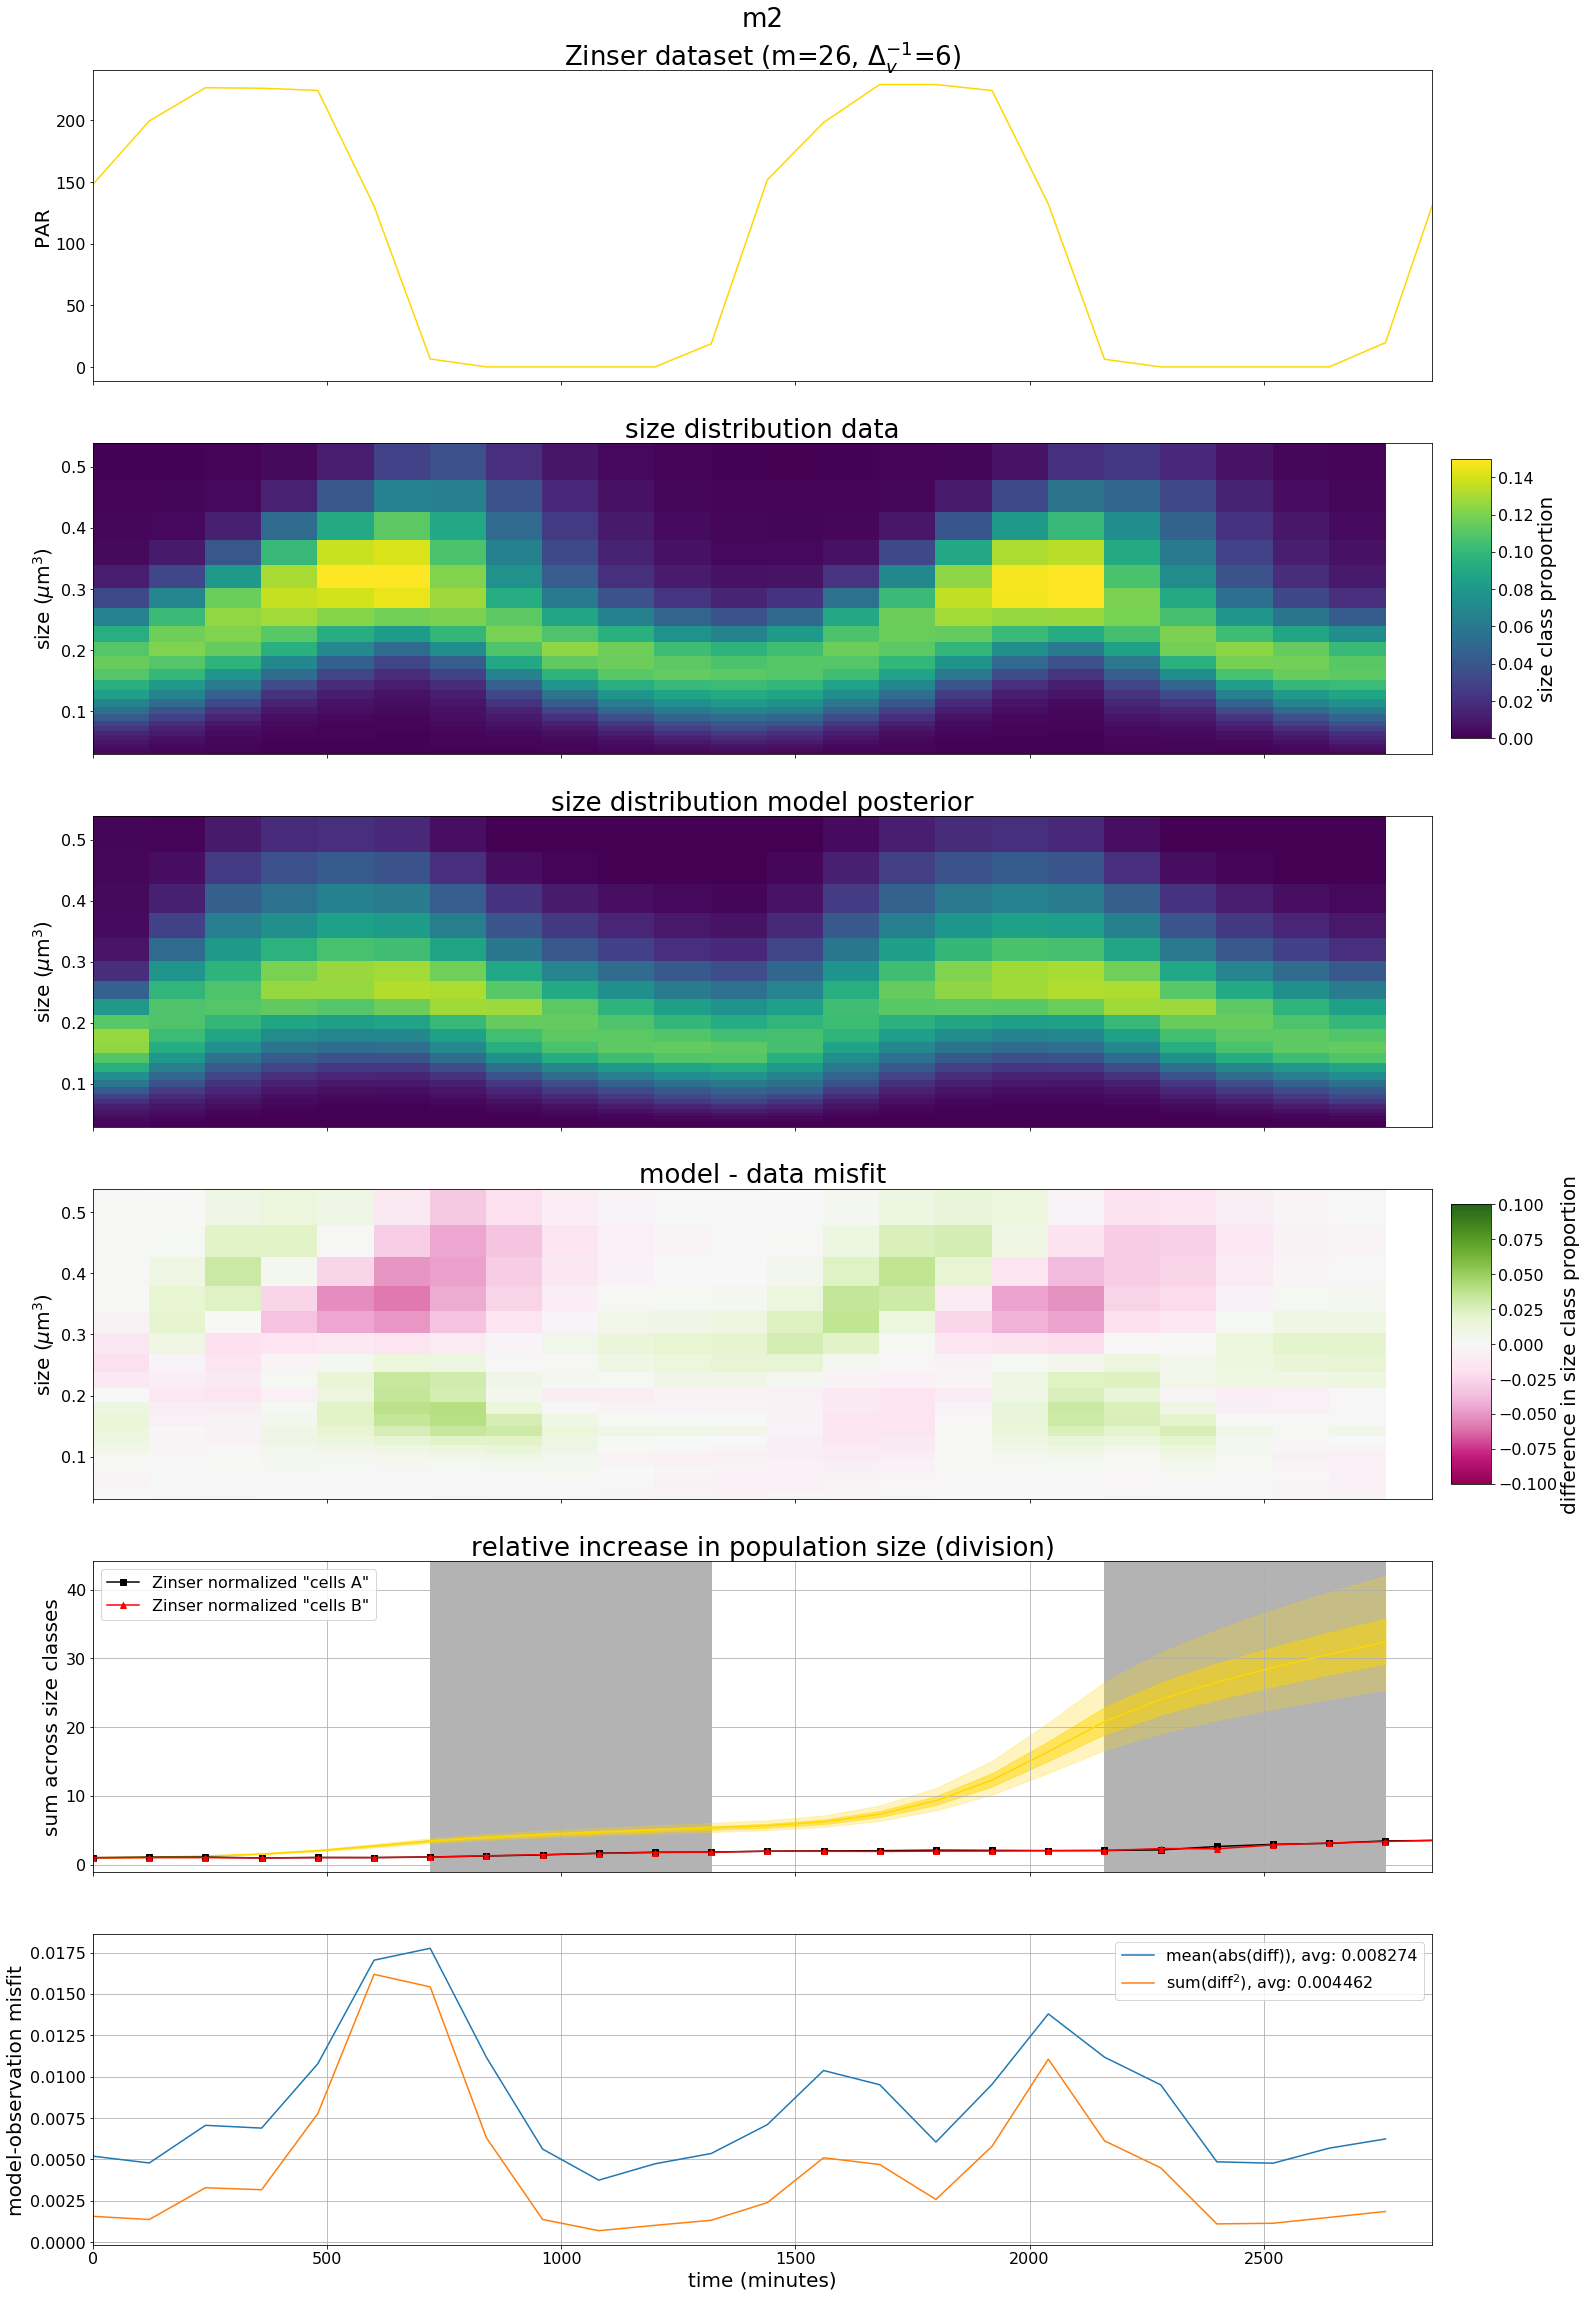

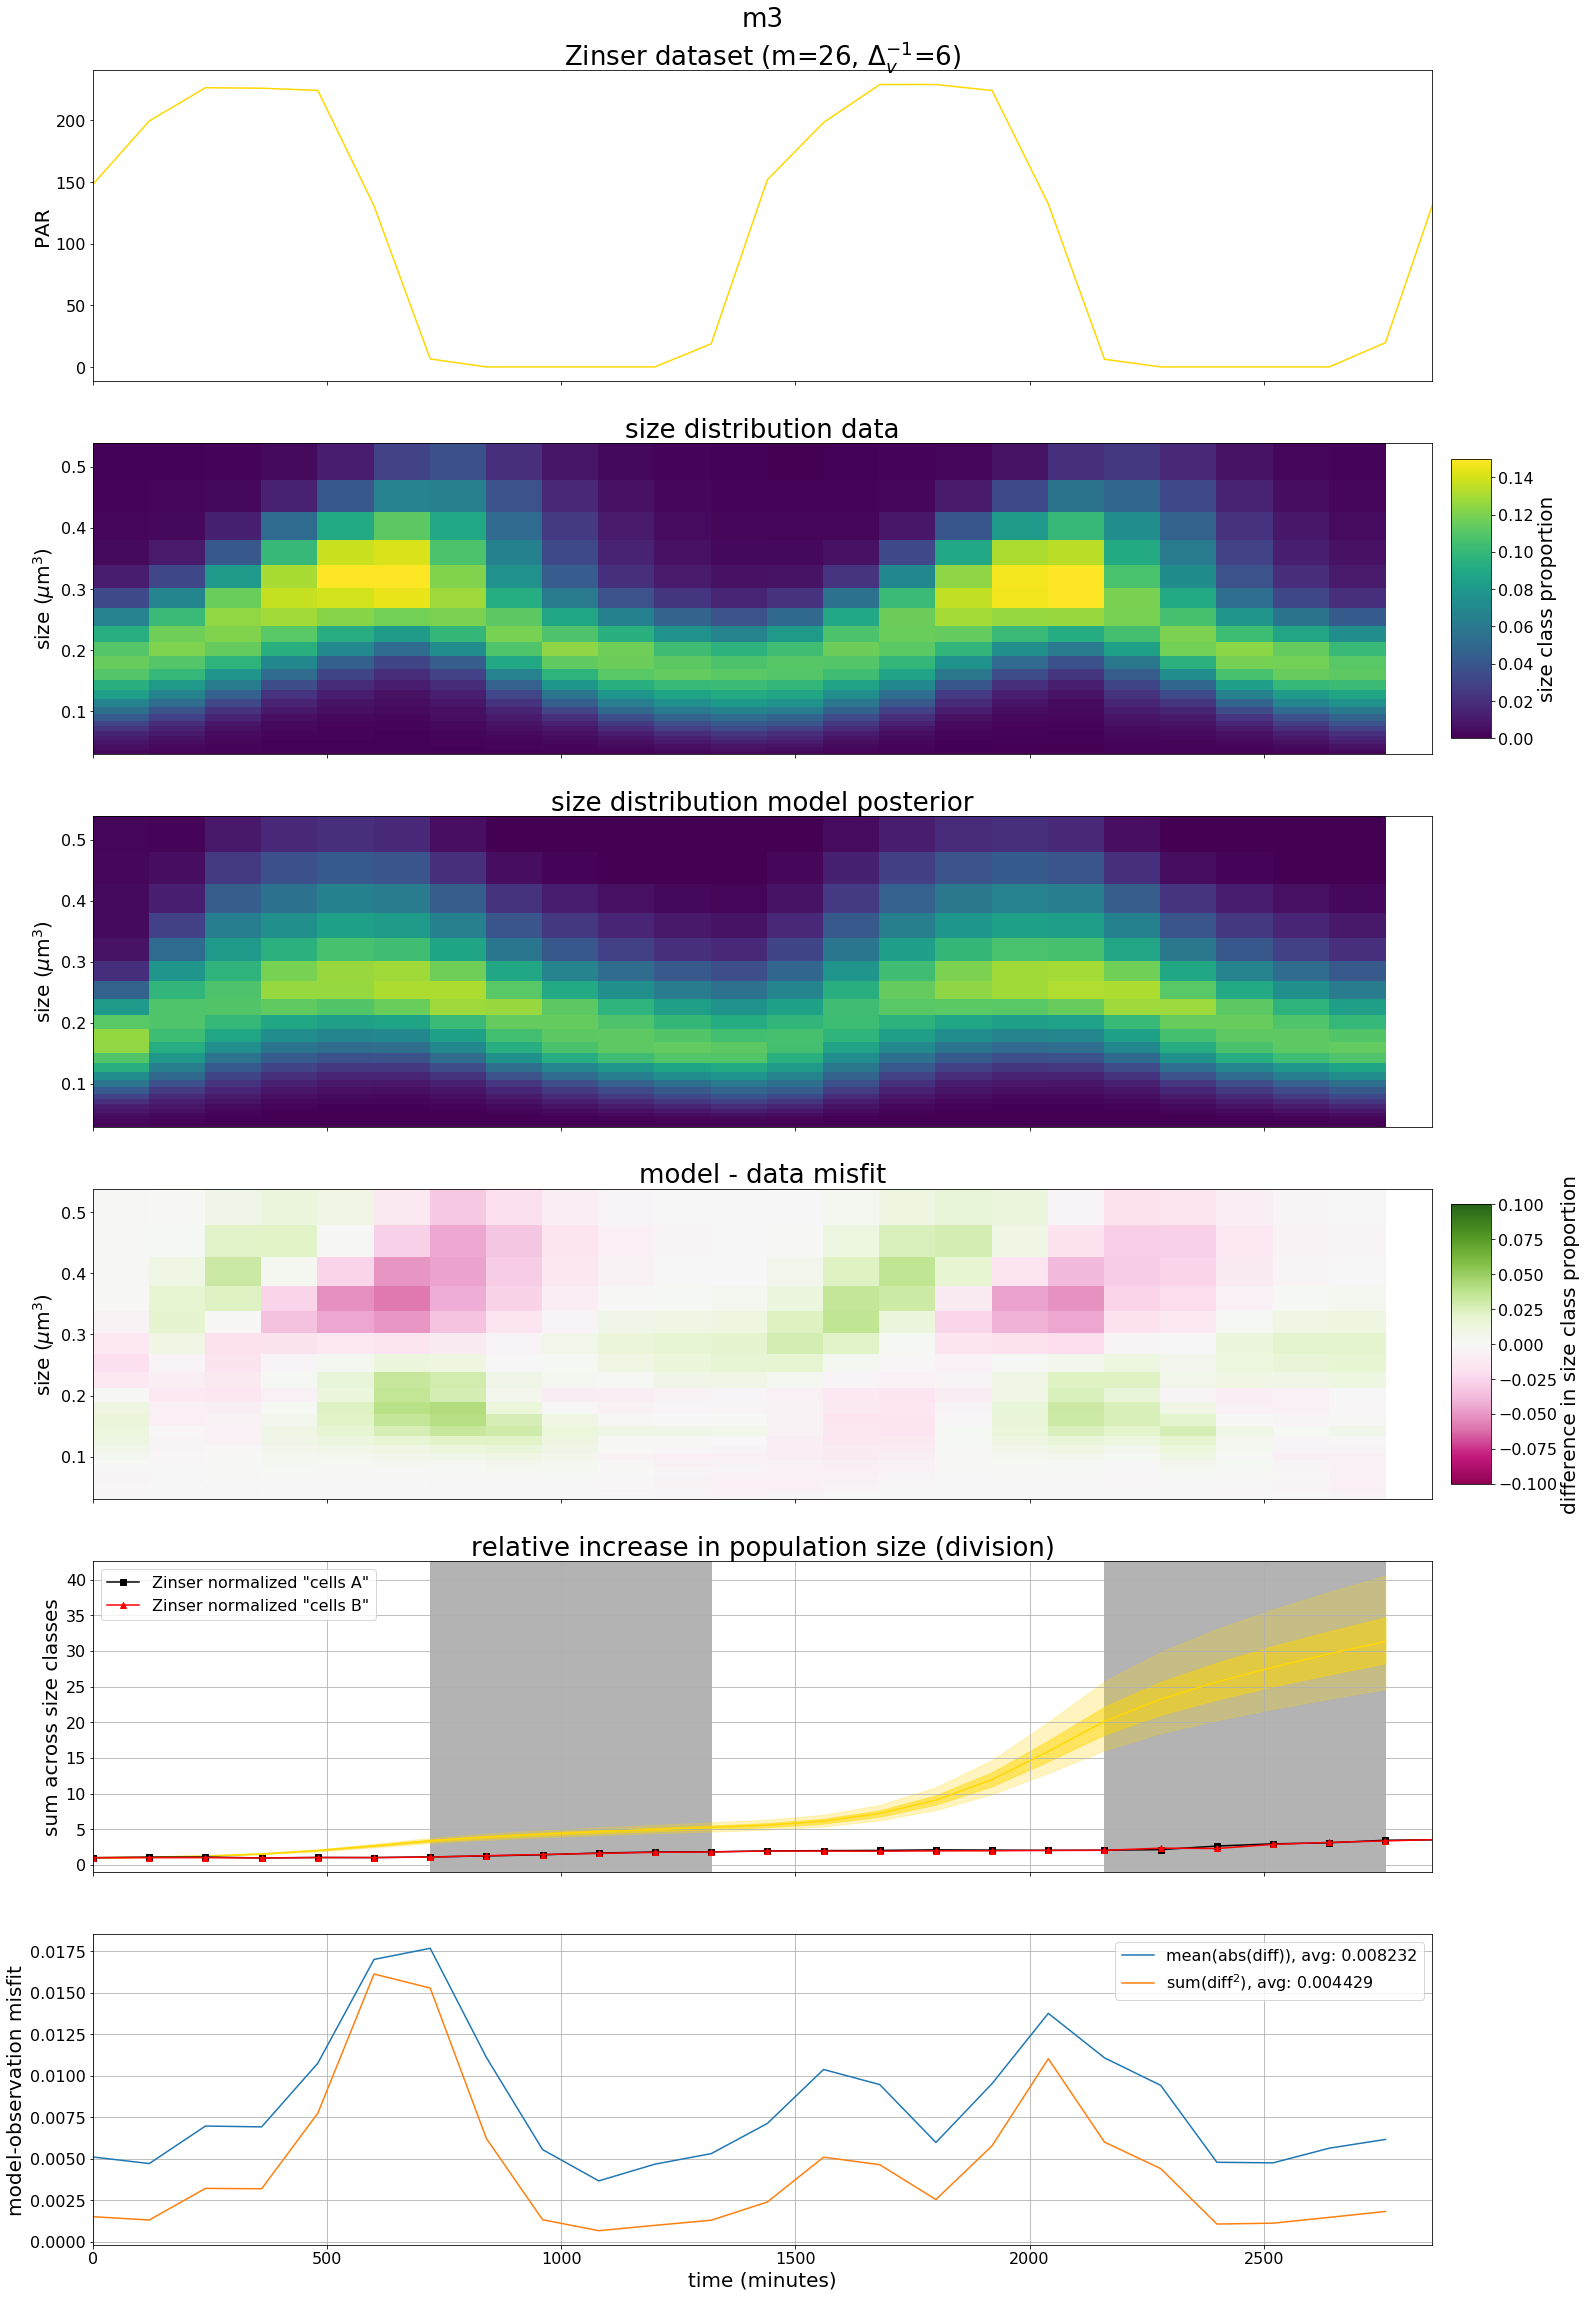

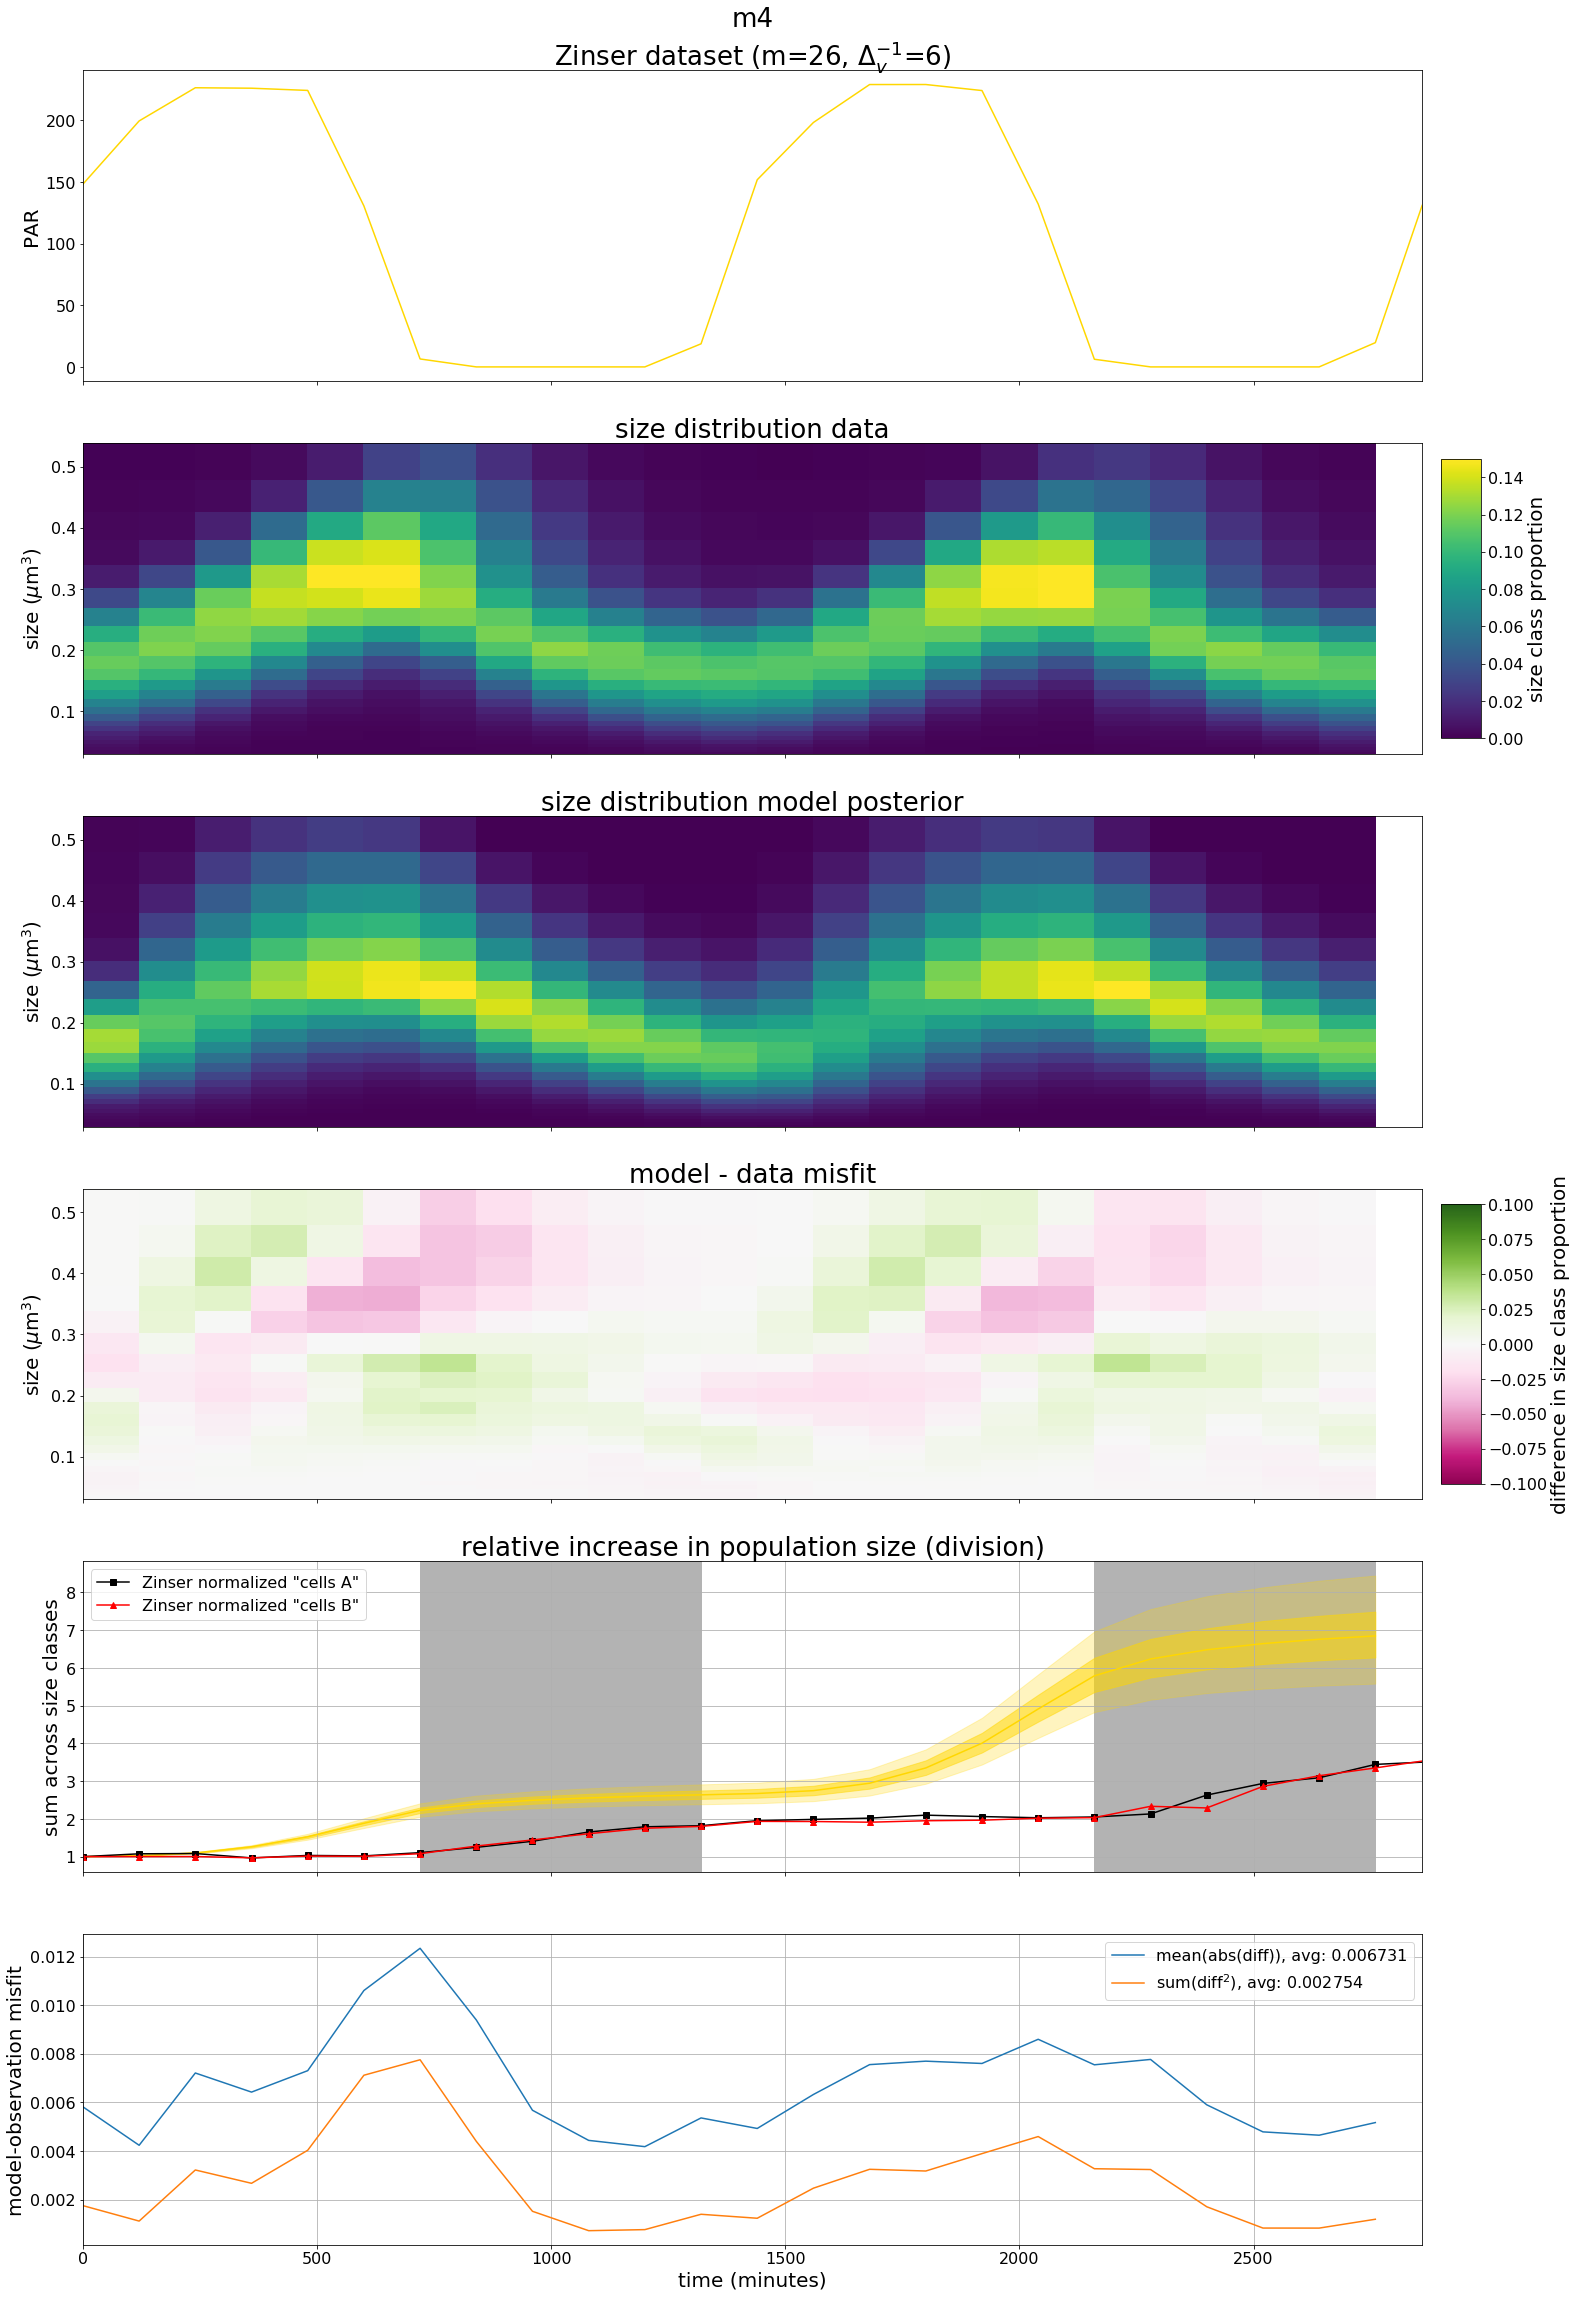

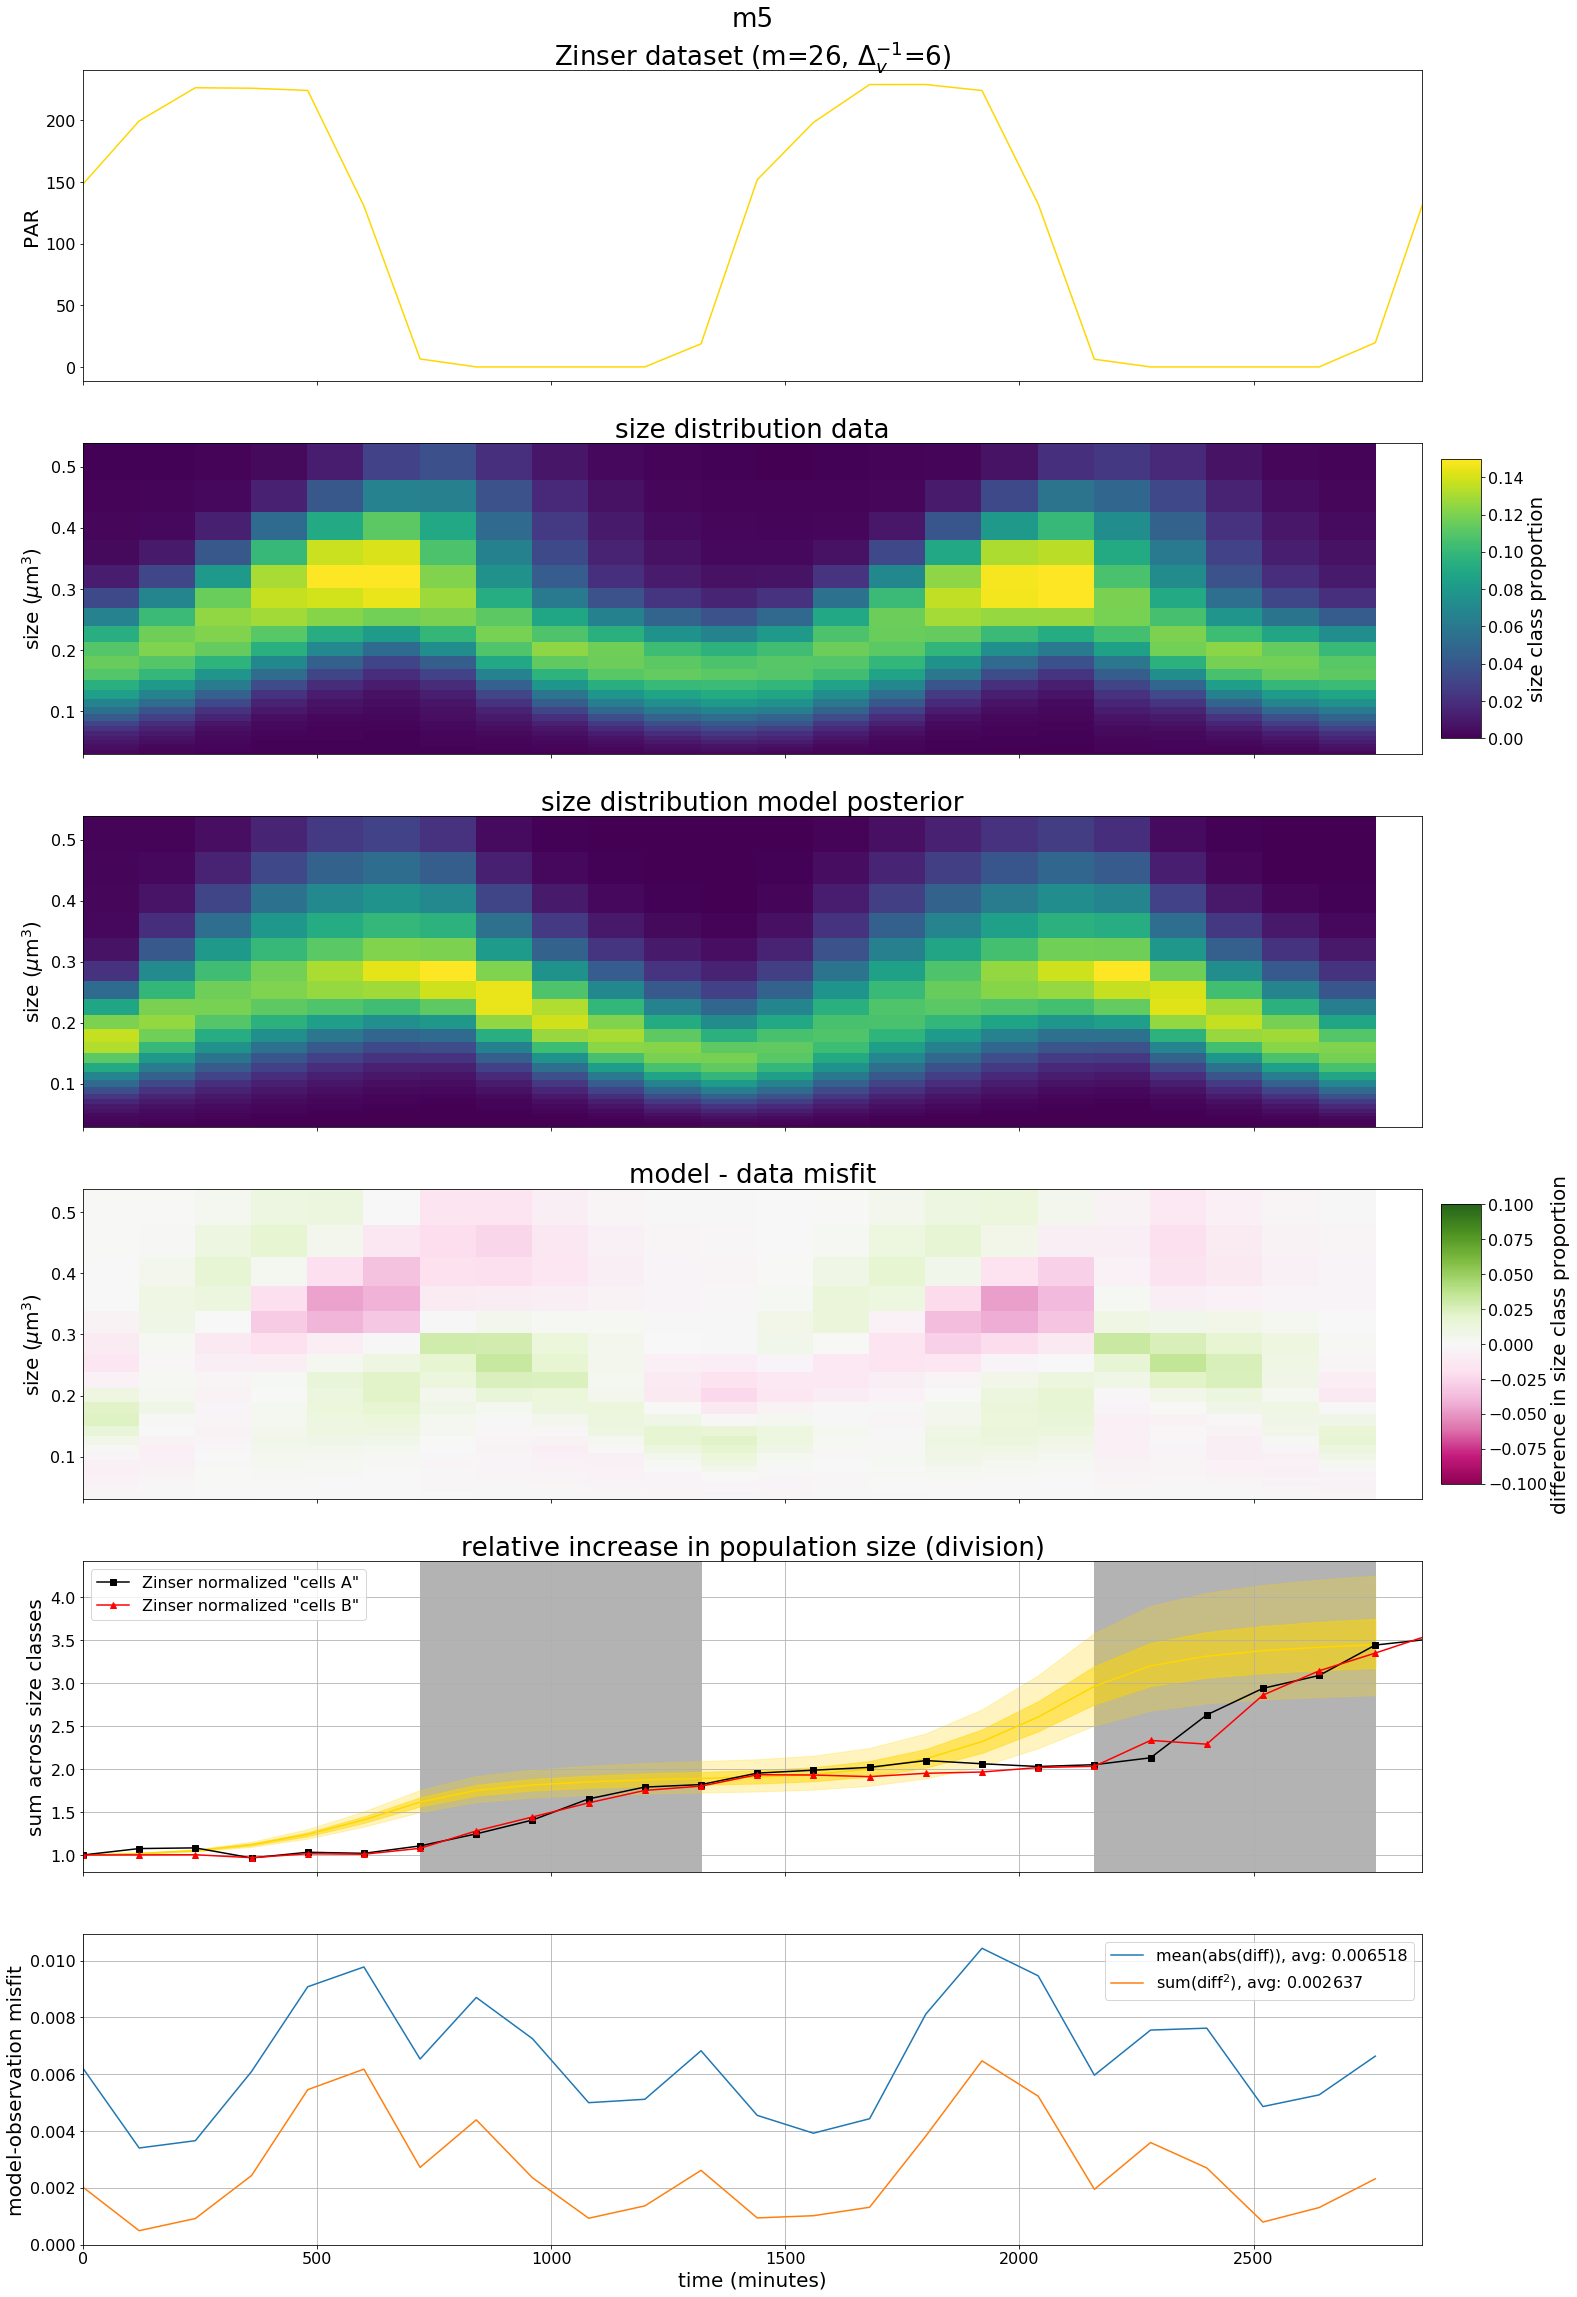

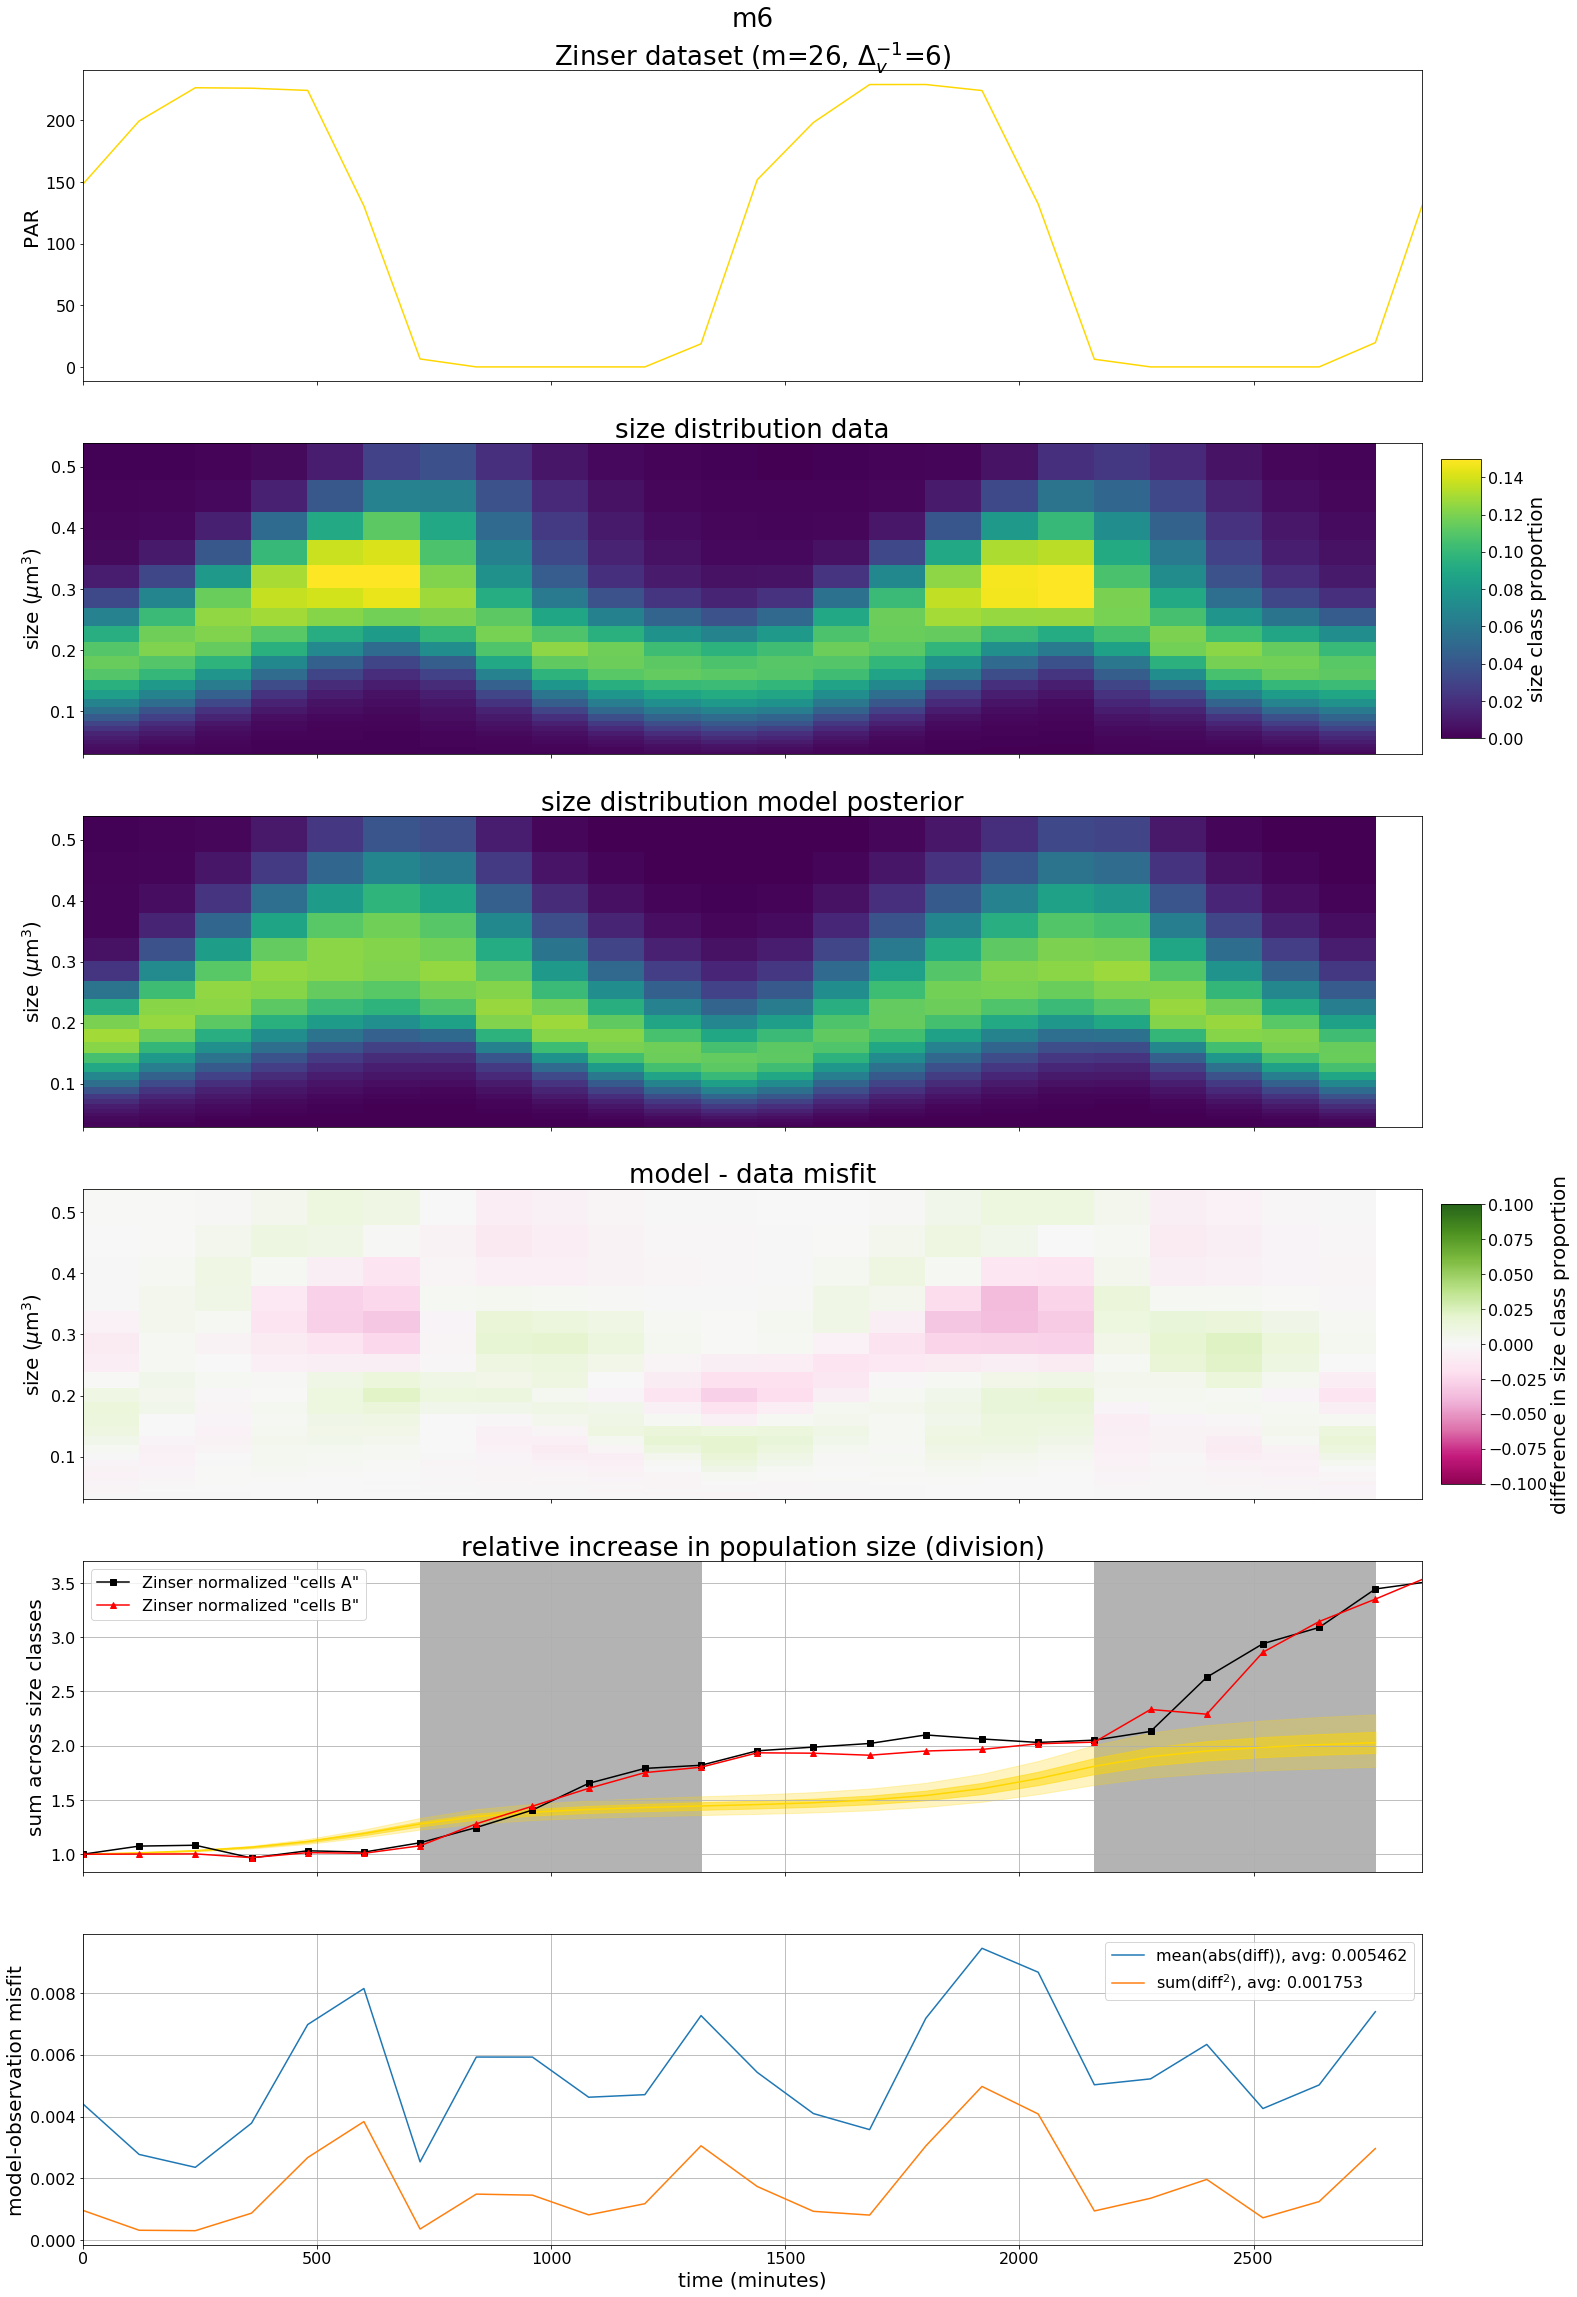

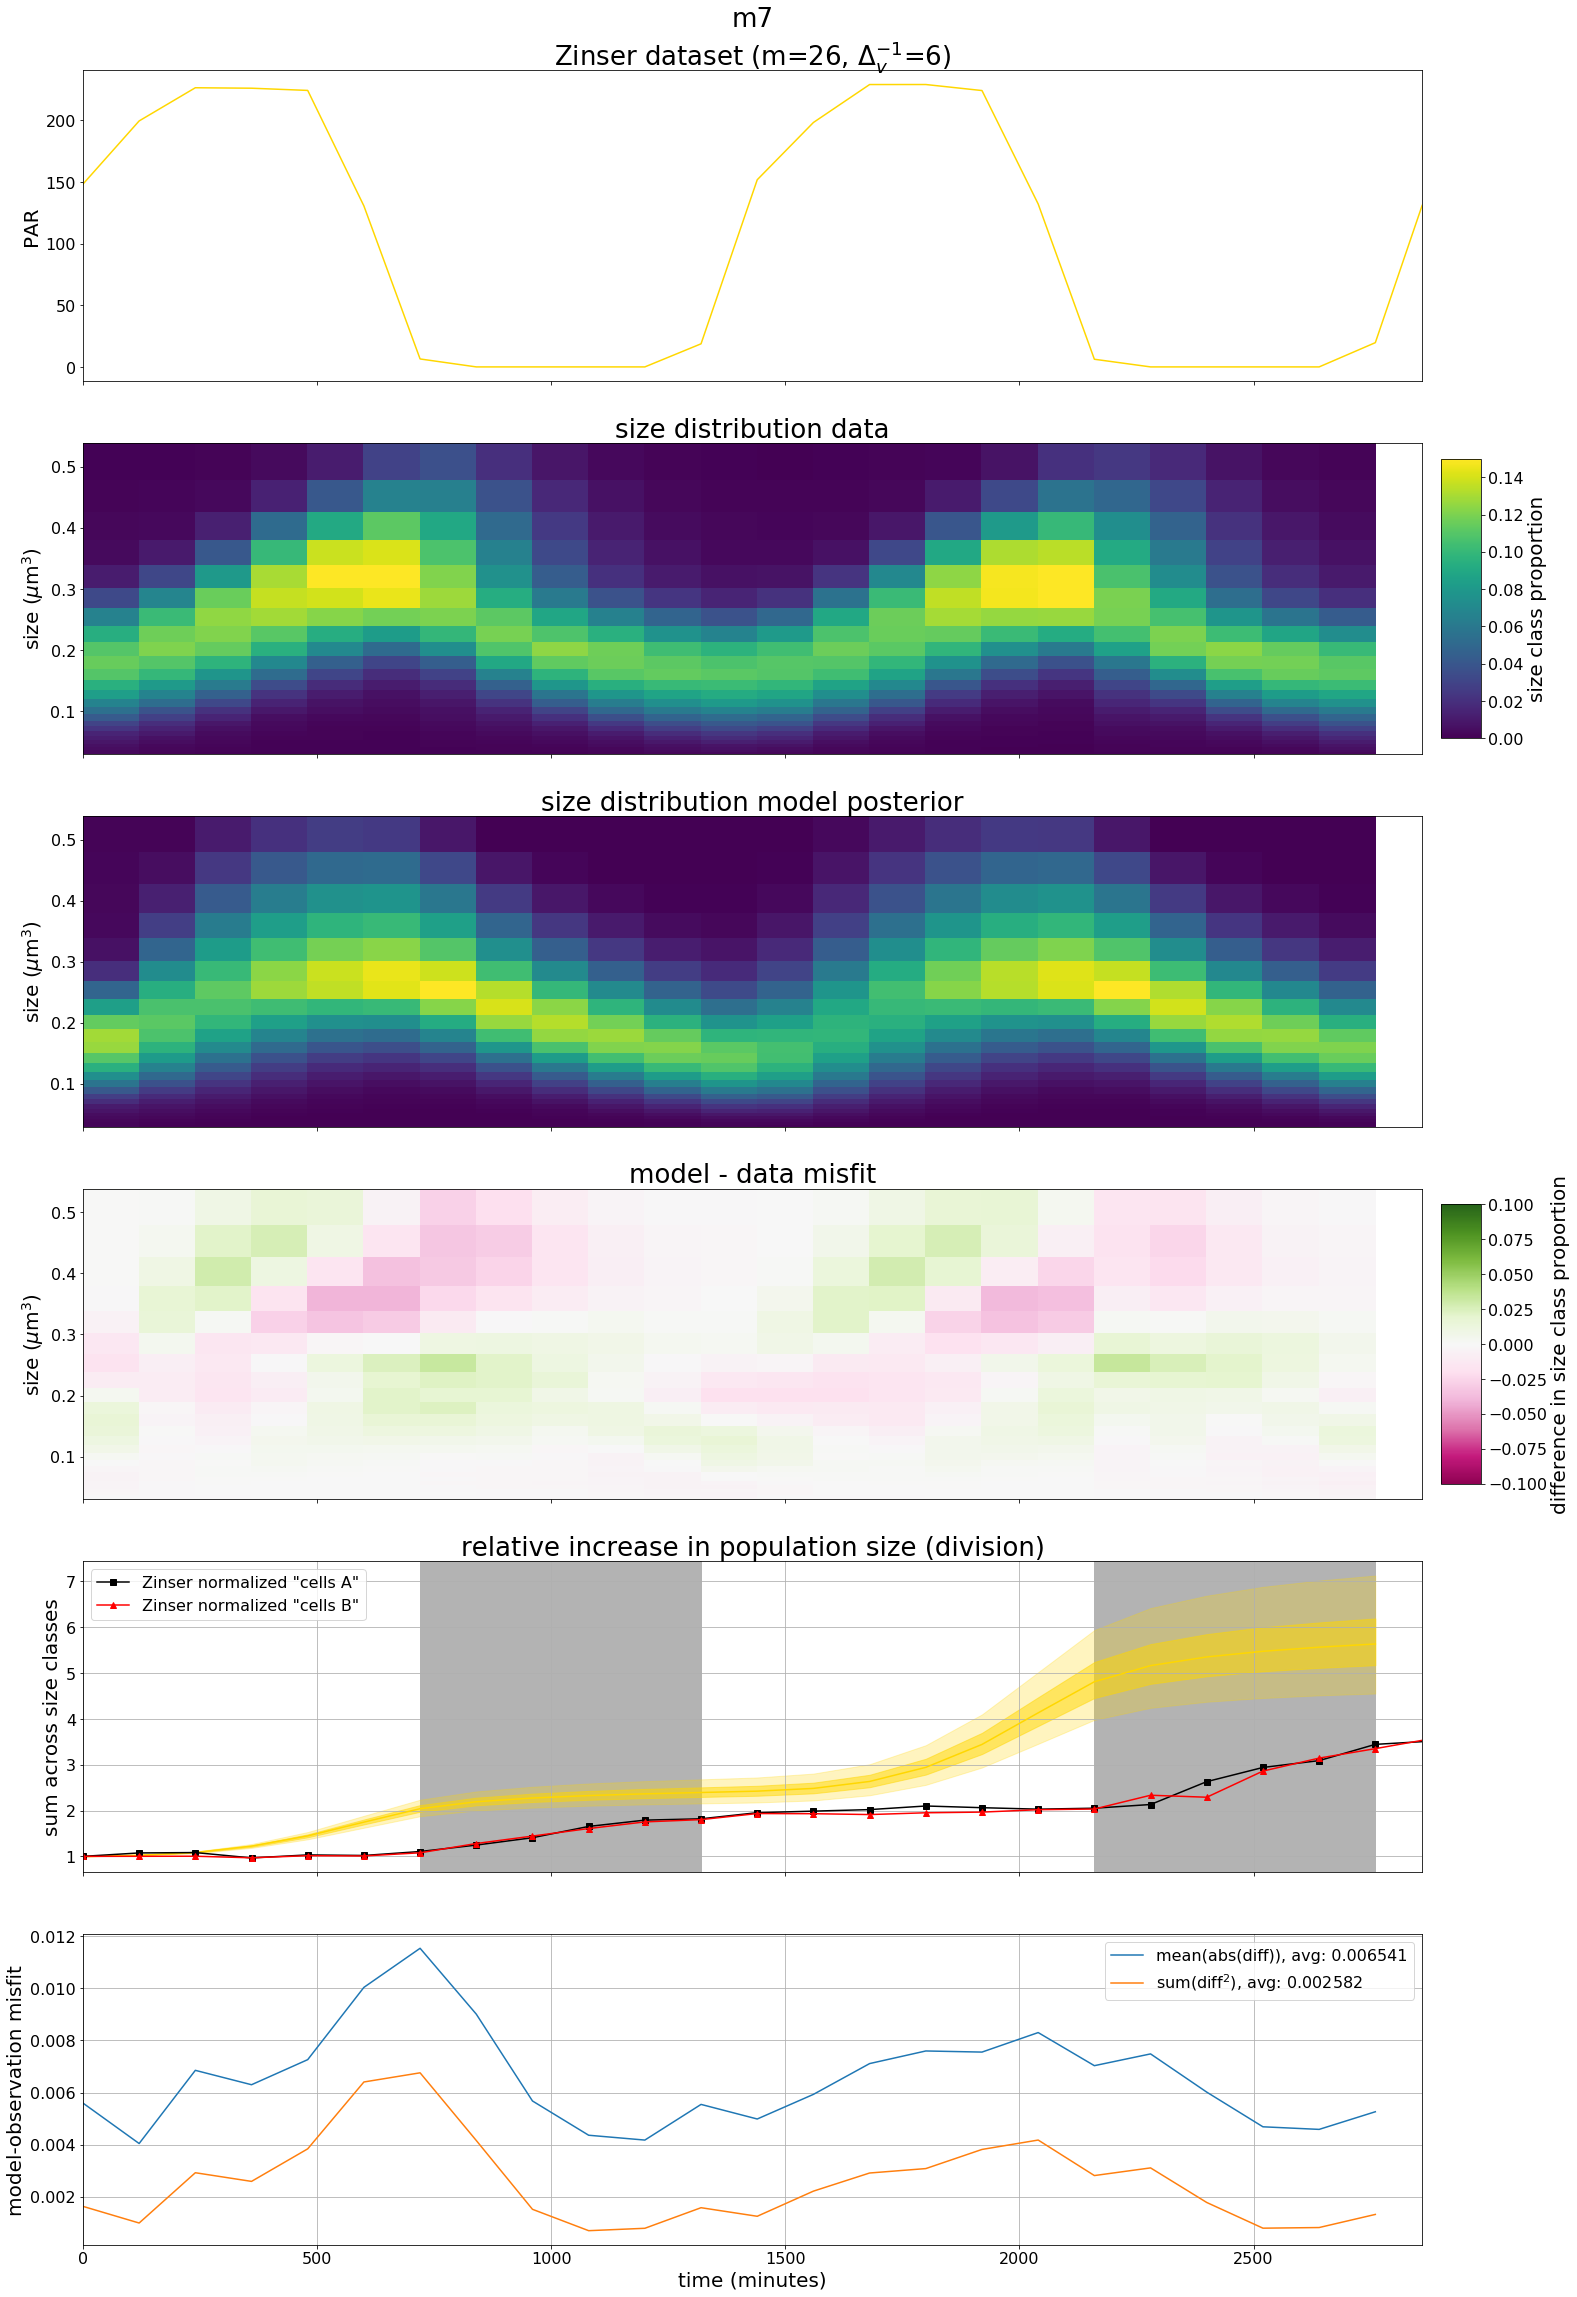

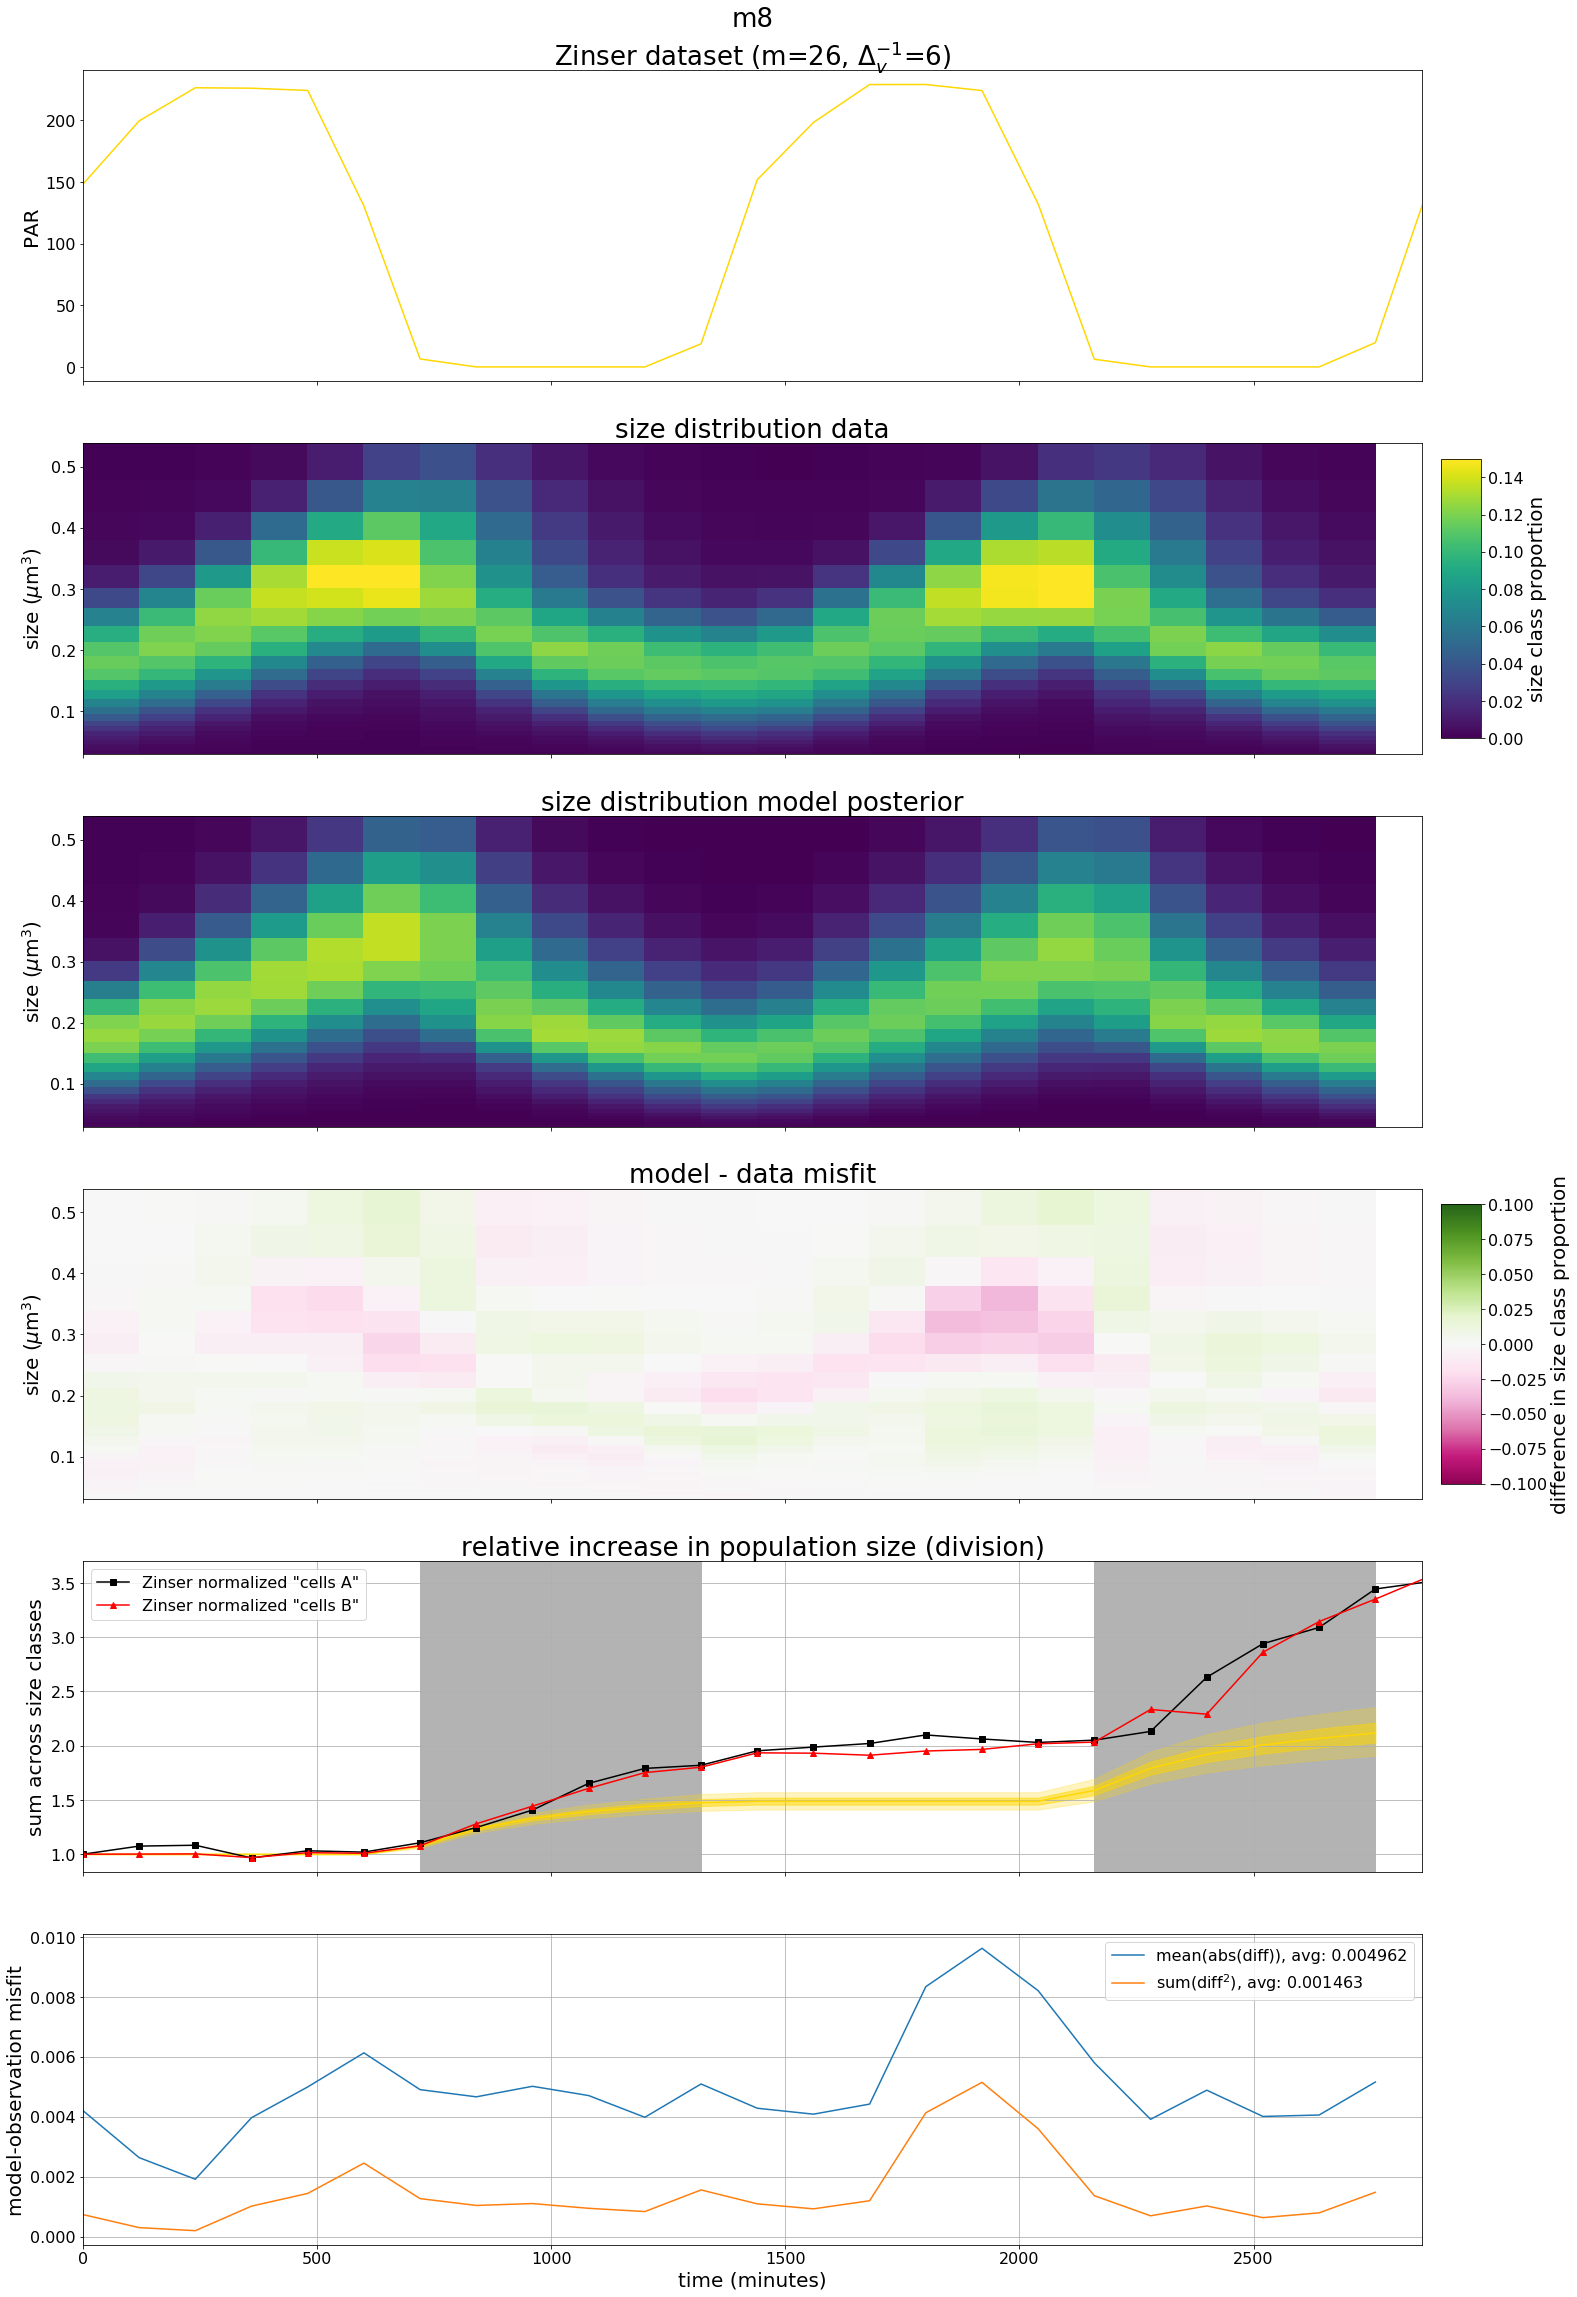

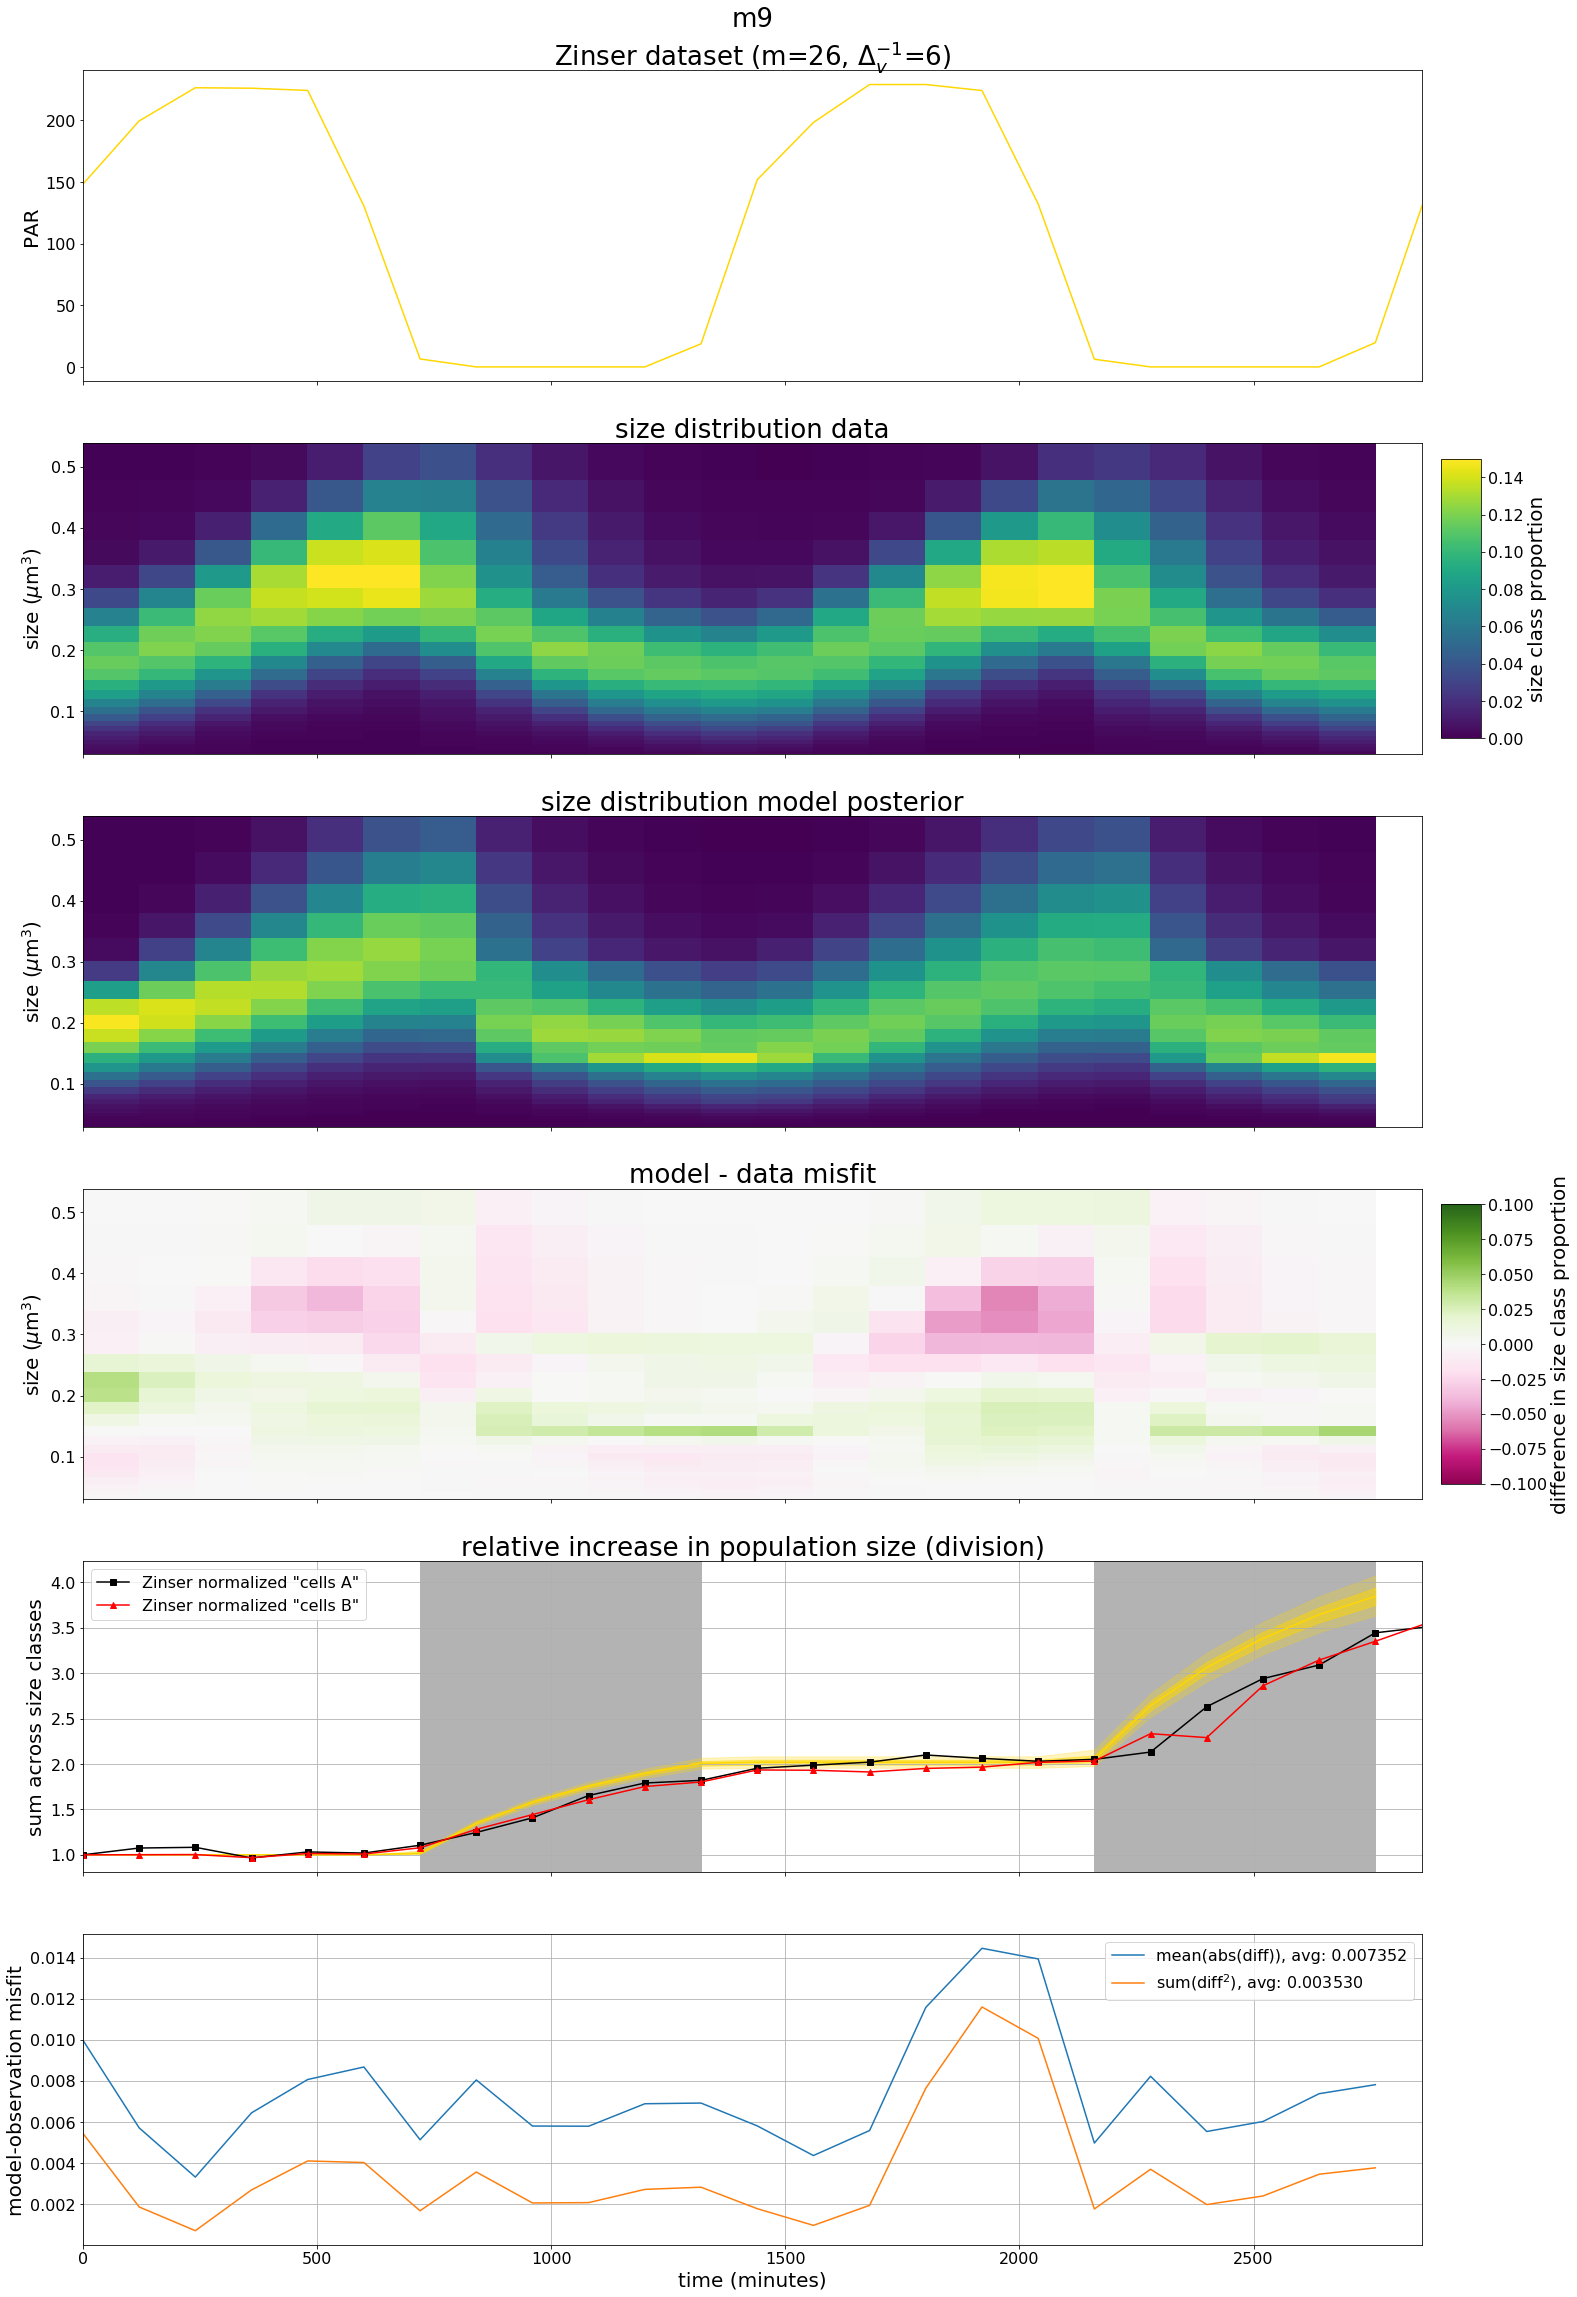

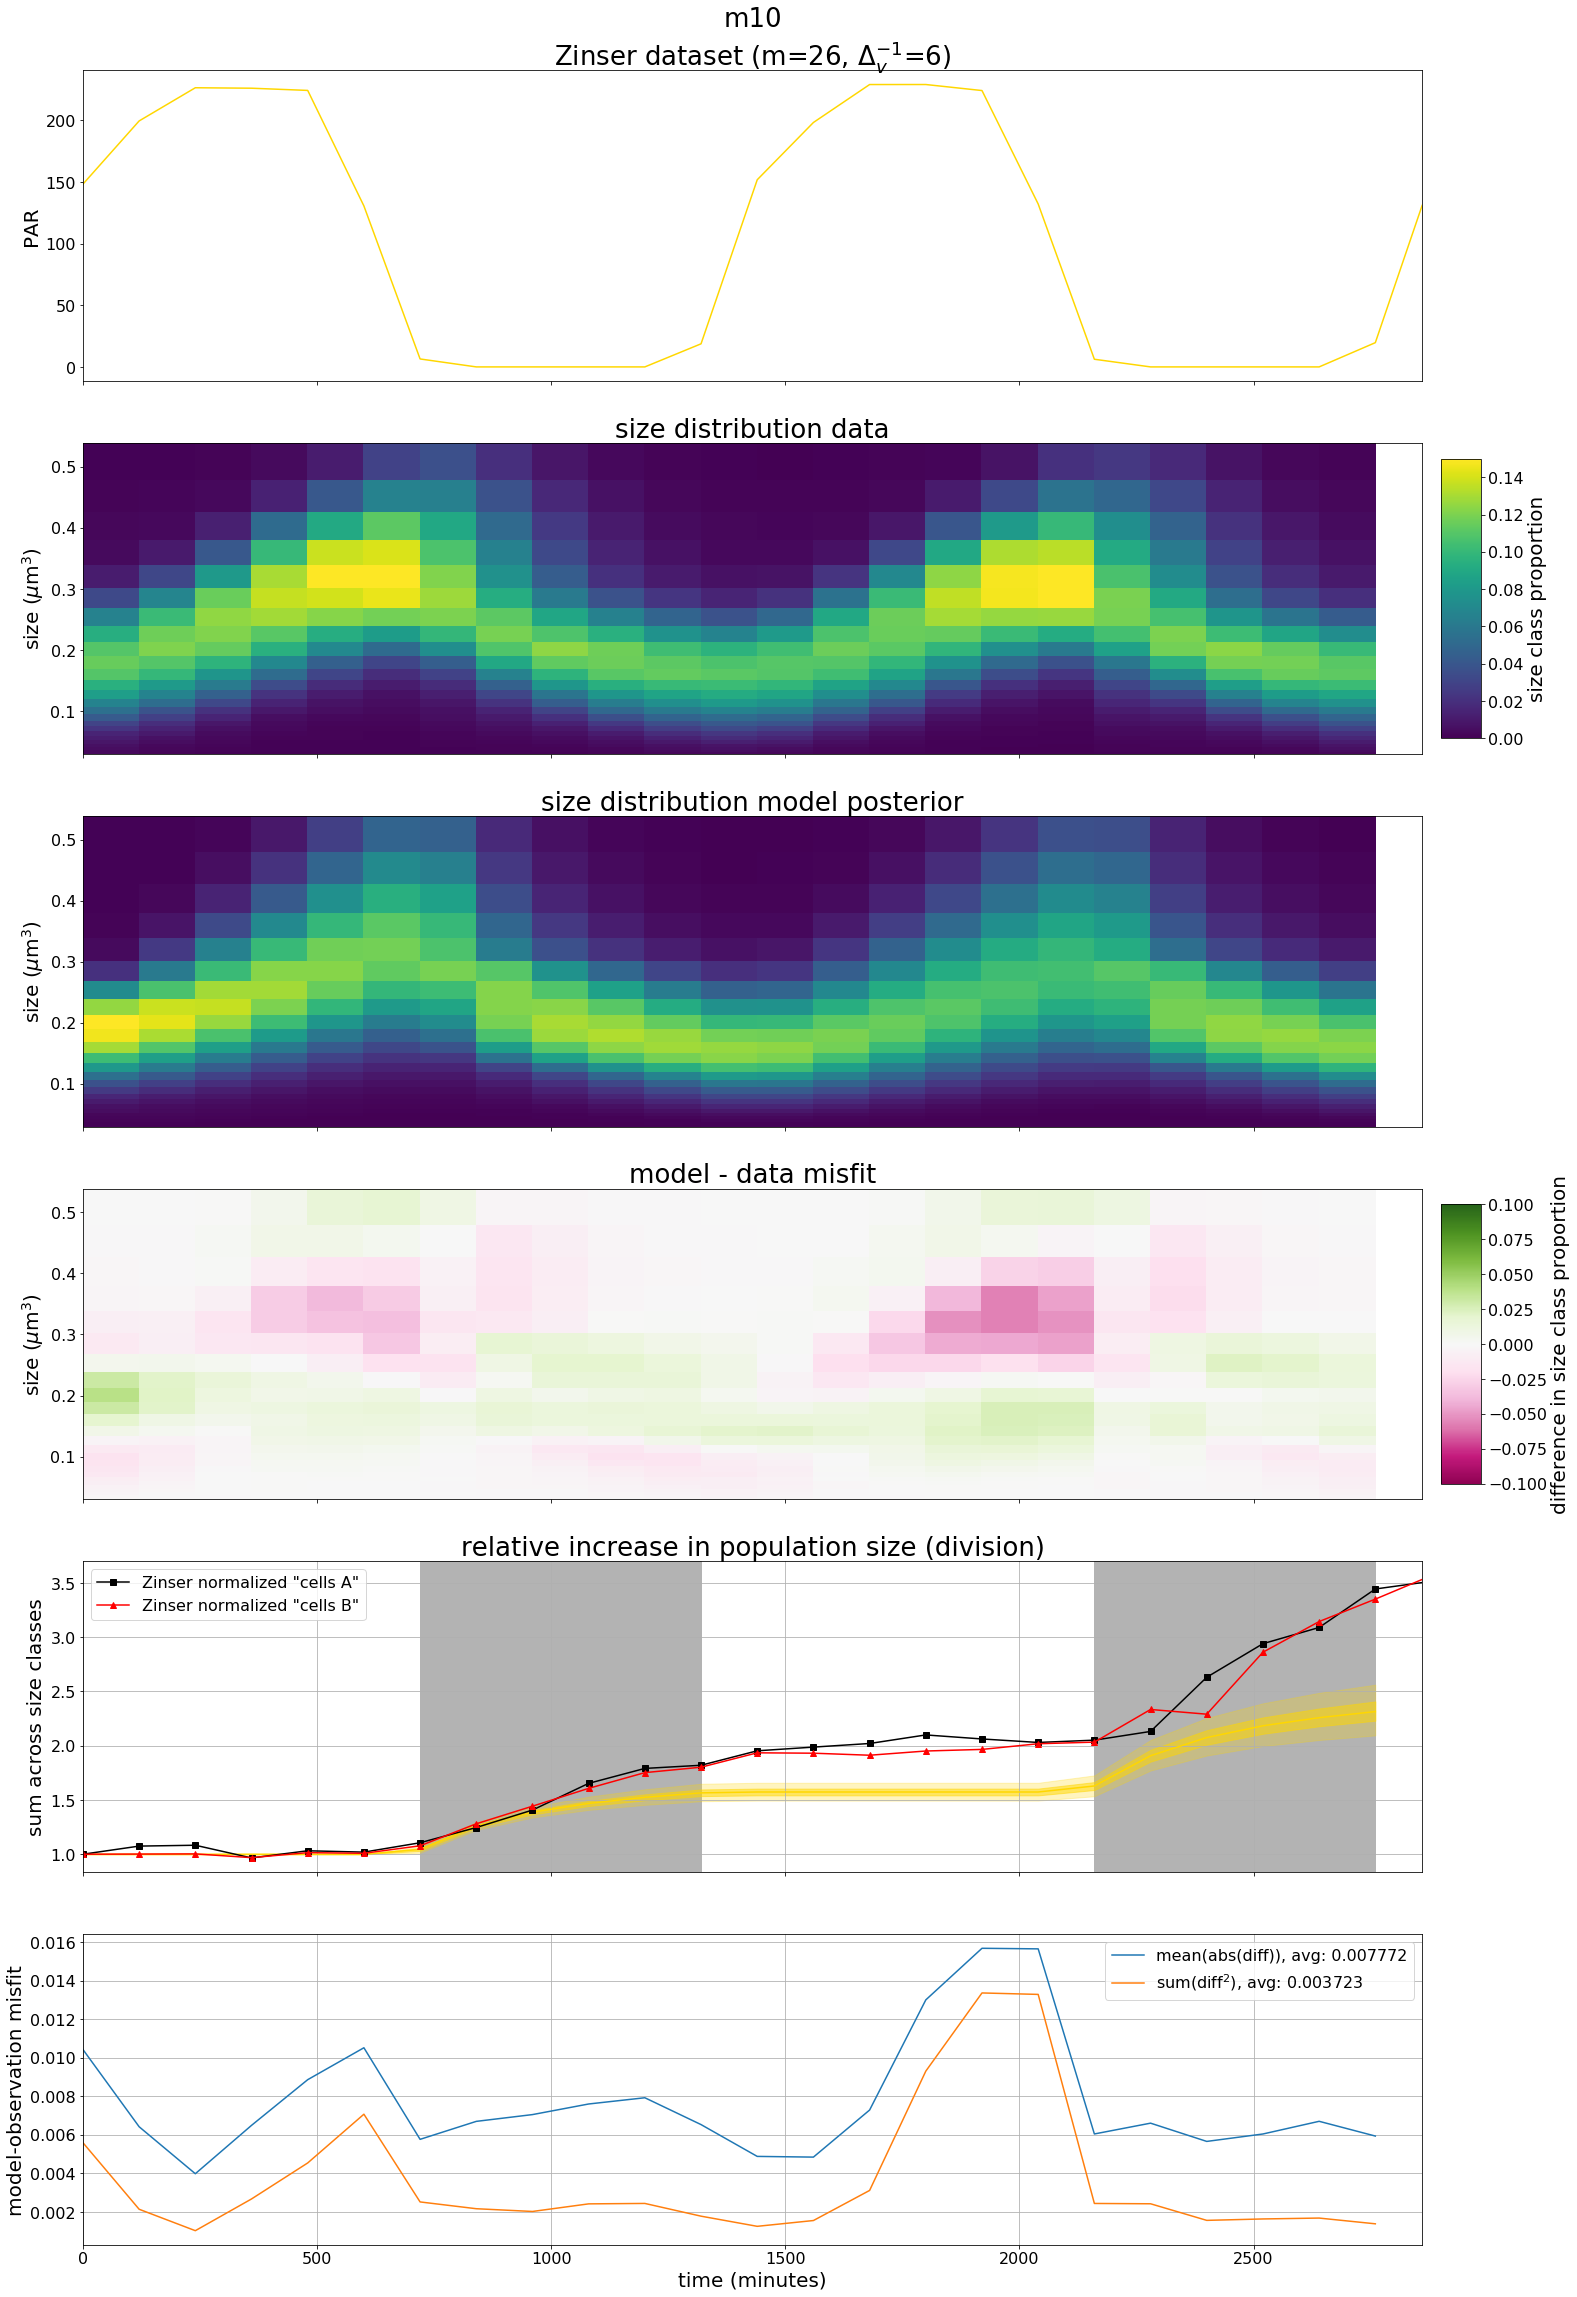

In [15]:
data_fig2a = pd.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.15)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for dataname in data:
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v_ext = data[dataname]['v_min'] * 2**(np.arange(data[dataname]['m']+1)*delta_v) 
    v = v_ext[:-1]
    v_width = v_ext[1:] - v_ext[:-1]
        
    for model,mcmc in mcmcs.items():
        
        res = {'model':np.mean(mcmc[dataname]['mod_obspos'], axis=0), 'obs':data[dataname]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        if maxrhats_final[model][dataname] > 1.1:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.set_title(desc_model[model] + '\n' + desc[dataname])
            ax.set(xticks=[], yticks=[])
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
            continue
        
        fig,axs = plt.subplots(6,1,sharex=True,figsize=(24,40))
        axs[0].set_title(desc_model[model] + '\n' + desc[dataname])

        ax = axs[0]
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(xlim=(data[dataname]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution data')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution model posterior')
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)', title='model - data misfit')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')
        
        qq = np.percentile(np.sum(mcmc[dataname]['mod_obspos'], axis=1), axis=0, q=(5,25,50,75,95))
    
        ax = axs[4]
        ax.fill_between(data[dataname]['t_obs'], qq[0,:], qq[-1,:], alpha=0.25, color='gold')
        ax.fill_between(data[dataname]['t_obs'], qq[1,:], qq[-2,:], alpha=0.5, color='gold')
        ax.plot(data[dataname]['t_obs'], qq[2,:], color='gold')
        if 'zinser' in dataname:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.grid(True)
        ax.set(ylabel='sum across size classes', title='relative increase in population size (division)')

        ax = axs[5]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (minutes)', ylabel='model-observation misfit')
        ax.grid(True)
        ax.legend()

In [16]:
'''
import netCDF4 as nc4

for dataname in data:

    ncname = 'data_exp_zs_20200626_g2_itest_{}.nc'.format(dataname)

    with nc4.Dataset(ncname, 'w') as nc:
        for i,model in enumerate(mcmcs):
            if i == 0:
                nc.createDimension('model', len(mcmcs))
                nc.createDimension('sample', mcmcs[model][dataname]['divrate'].shape[0])
            
                nc.createVariable('divrate', float, ('model','sample'))
                nc.createVariable('sumsqdiff', float, ('model','sample'))
                nc.variables['sumsqdiff'].setncattr('long_name', 'sum of squared column differences')
                
            nc.variables['divrate'][i,:] = mcmcs[model][dataname]['divrate']
            
            obs = data[dataname]['obs']

            tmp = mcmcs[model][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2
            
            if np.all(data[dataname]['i_test'] == 0):
                nc.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp, axis=1), axis=1)
                if i == 0:
                    nc.variables['sumsqdiff'].setncattr('data_used', 'all data')
            else:
                nc.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
                if i == 0:
                    nc.variables['sumsqdiff'].setncattr('data_used', 'testing data')
            
            for iv,v in enumerate(('gamma_max','rho_max','xi','xir','E_star')):
                if i == 0:
                    nc.createVariable(v, float, ('model','sample'))
                if v in mcmcs[model][dataname].flatnames:
                    nc.variables[v][i,:] = mcmcs[model][dataname][v]
'''
None